# IAU Projekt - Fáza 3 - Strojové učenie
Peter Brenkus, Tomáš Brček

Percentuálny podiel: 50/50

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from statsmodels.stats.power import GofChisquarePower
from sklearn.model_selection import train_test_split

In [2]:
# načítanie súborov
connections = pd.read_csv("raw_data/connections.csv", delimiter="\t")
devices = pd.read_csv("raw_data/devices.csv", delimiter="\t")
processes = pd.read_csv("raw_data/processes.csv", delimiter="\t")
profiles = pd.read_csv("raw_data/profiles.csv", delimiter="\t")

# 1.1 Základný opis dát spolu s ich charakteristikami

Analýza štruktúr dát ako súbory (štruktúry a vzťahy, počet, typy, …), záznamy
(štruktúry, počet záznamov, počet atribútov, typy, …)

## B
Analýza jednotlivých atribútov: pre zvolené významné atribúty (min 10) analyzujte
ich distribúcie a základné deskriptívne štatistiky.

### Výber relevantných stĺpcov

Rozhodli sme sa bližšie analyzovať tieto stĺpce:

- **Connections:**
"c.katana", "c.android.gm", "c.android.youtube", "c.android.chrome", "c.dogalize"

- **Devices:**
"store_name", "code", "location"

- **Profiles:**
"company"
  
- **Processes:**
"p.android.gm", "p.android.externalstorage", "p.android.documentsui", "p.system", "p.android.settings", "p.android.packageinstaller", "p.android.chrome"

Keďže súbory devices a profiles nemôžme mergovať dokopy s ostatnými, budeme ich stĺpce analyzovať samostatne.

In [3]:
columns_to_drop = ["c.android.vending", "c.raider", "c.UCMobile.intl", "c.updateassist", "c.UCMobile.x86"]
relevant_connections = connections.drop(columns=columns_to_drop)
columns_to_drop = ["imei", "latitude", "longitude"]
relevant_devices = devices.drop(columns=columns_to_drop)
columns_to_drop = ["p.inputmethod.latin", "p.simulator", "p.android.gms", "p.android.vending", "p.katana", "p.process.gapps", "p.google", "p.olauncher", "p.browser.provider", "p.android.defcontainer", "p.gms.persistent", "p.notifier", "p.dogalize"]
relevant_processes = processes.drop(columns=columns_to_drop)
columns_to_drop = ["imei", "birthdate", "user_id", "registration", "job", "mail", "residence", "current_location", "username", "ssn", "name"]
relevant_profiles = profiles.drop(columns=columns_to_drop)

### Numerické stĺpce

#### Štatistické hodnoty

##### Mean, Median & Mode
- Na tieto štatistiky použijeme zabudované funkcie z knižníc

In [4]:
for ds in [relevant_connections.drop(columns=["mwra", "imei"]), relevant_processes.drop(columns=["mwra", "imei"])]:
    for col in ds.select_dtypes(include=['number']):
        mean_value = round(np.mean(ds[col]), 3)
        median_value = round(np.median(ds[col]), 3)
        mode_result = stats.mode(ds[col])
        try:
            mode_value = mode_result.mode
        except IndexError:
            mode_value = None
        mode_display = mode_value if mode_value is not None else "N/A"
        print(f"{col:30} -> Mean: {mean_value:>8}, Median: {median_value:>8}, Mode: {mode_display:>8}")


c.dogalize                     -> Mean:   12.781, Median:   12.796, Mode: 10.14669
c.android.gm                   -> Mean:   10.308, Median:   10.257, Mode:  6.32849
c.android.chrome               -> Mean:   11.494, Median:   11.607, Mode: 10.82189
c.android.youtube              -> Mean:   10.332, Median:   10.069, Mode: 10.48354
c.katana                       -> Mean:   10.398, Median:   10.232, Mode:  6.78951
p.android.gm                   -> Mean:   10.959, Median:   10.975, Mode:  4.70803
p.android.externalstorage      -> Mean:    11.57, Median:     11.8, Mode:  8.37652
p.android.documentsui          -> Mean:   11.566, Median:   11.836, Mode: 11.52538
p.system                       -> Mean:   12.148, Median:   12.282, Mode:  7.89759
p.android.settings             -> Mean:   10.982, Median:   11.031, Mode: 10.22028
p.android.packageinstaller     -> Mean:   10.408, Median:   10.389, Mode:  7.94377
p.android.chrome               -> Mean:    9.791, Median:    9.636, Mode:  4.96029


##### Skewness & Kurtosis
- Najprv si definujeme funkcie na automatické vyhodnotenie skewness a kurtosis
- Potom pre každý zo zvolených numerických atribútov vypíšeme skewness a kurtosis aj s interpretáciou

In [5]:
# Funkcia pre automaticke vyhodnotenie skewness
def evaluate_skewness(skewness: float) -> str:
    if -0.5 <= skewness <= 0.5:
        return f"Slightly skewed to the {'left' if skewness > 0 else 'right'}"
    elif -1 < skewness < -0.5 or 0.5 < skewness < 1:
        return f"Moderately skewed to the {'left' if skewness > 0 else 'right'}"
    elif skewness <= -1 or skewness >= 1:
        return f"Highly skewed to the {'left' if skewness > 0 else 'right'}"
    else:
        return "Invalid value."

# Funkcia pre automaticke vyhodnotenie kurtosis
def evaluate_kurtosis(kurtosis: float) -> str:
    if kurtosis > 3:
        return "Kurtosis is high."
    elif kurtosis < 3:
        return "Kurtosis is low."

# Loop pre vypočítanie, interpretáciu a vypísanie hodnôt
for ds in [relevant_connections.drop(columns=["mwra", "imei"]), relevant_processes.drop(columns=["mwra", "imei"])]:
    for col in ds.select_dtypes(include=['number']):
        skewness_value = round(stats.skew(ds[col]), 3)
        kurtosis_value = round(stats.kurtosis(ds[col]), 3)
        skewness_eval = evaluate_skewness(skewness_value)
        kurtosis_eval = evaluate_kurtosis(kurtosis_value)

        print(f"{col:27} Skewness: {skewness_value:>8} -> {skewness_eval:<30} Kurtosis: {kurtosis_value:>8} -> {kurtosis_eval}")


c.dogalize                  Skewness:   -0.027 -> Slightly skewed to the right   Kurtosis:    0.203 -> Kurtosis is low.
c.android.gm                Skewness:    0.008 -> Slightly skewed to the left    Kurtosis:    -0.33 -> Kurtosis is low.
c.android.chrome            Skewness:   -0.119 -> Slightly skewed to the right   Kurtosis:   -0.238 -> Kurtosis is low.
c.android.youtube           Skewness:    0.357 -> Slightly skewed to the left    Kurtosis:   -0.125 -> Kurtosis is low.
c.katana                    Skewness:    0.195 -> Slightly skewed to the left    Kurtosis:   -0.254 -> Kurtosis is low.
p.android.gm                Skewness:   -0.009 -> Slightly skewed to the right   Kurtosis:   -0.435 -> Kurtosis is low.
p.android.externalstorage   Skewness:   -0.262 -> Slightly skewed to the right   Kurtosis:   -0.253 -> Kurtosis is low.
p.android.documentsui       Skewness:   -0.397 -> Slightly skewed to the right   Kurtosis:   -0.097 -> Kurtosis is low.
p.system                    Skewness:   

#### Vizualizácia

##### Histogramy

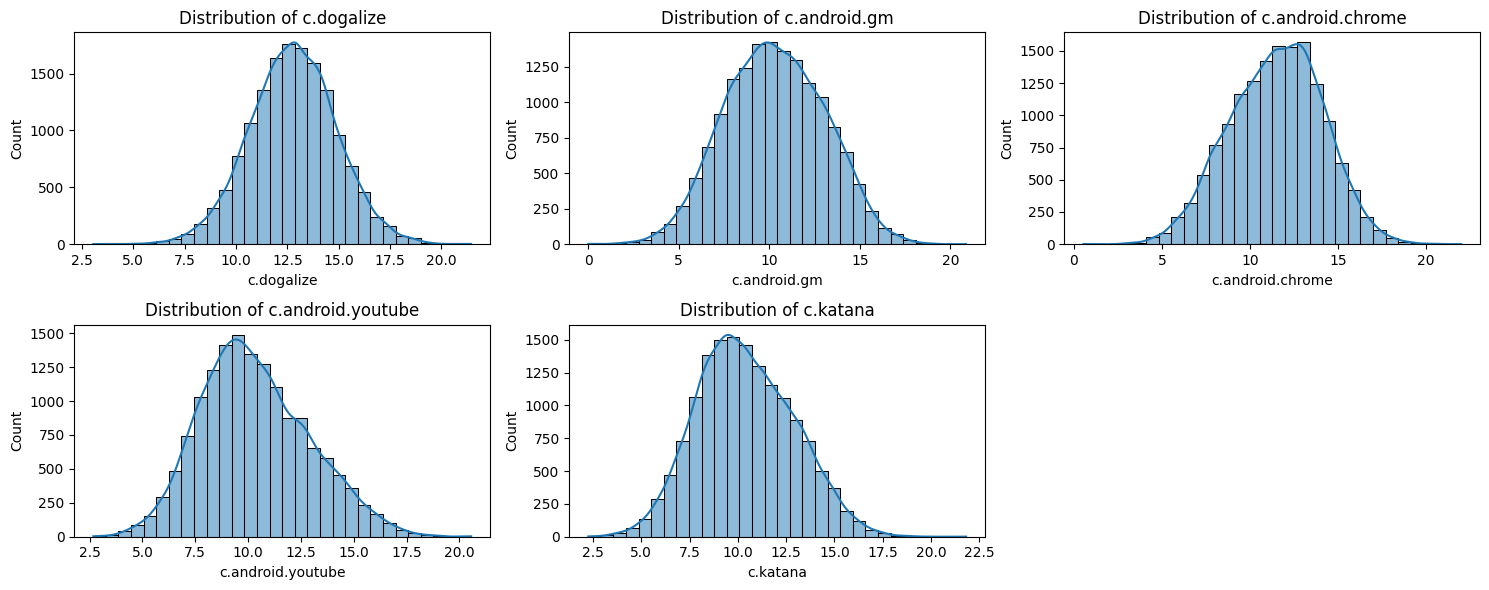

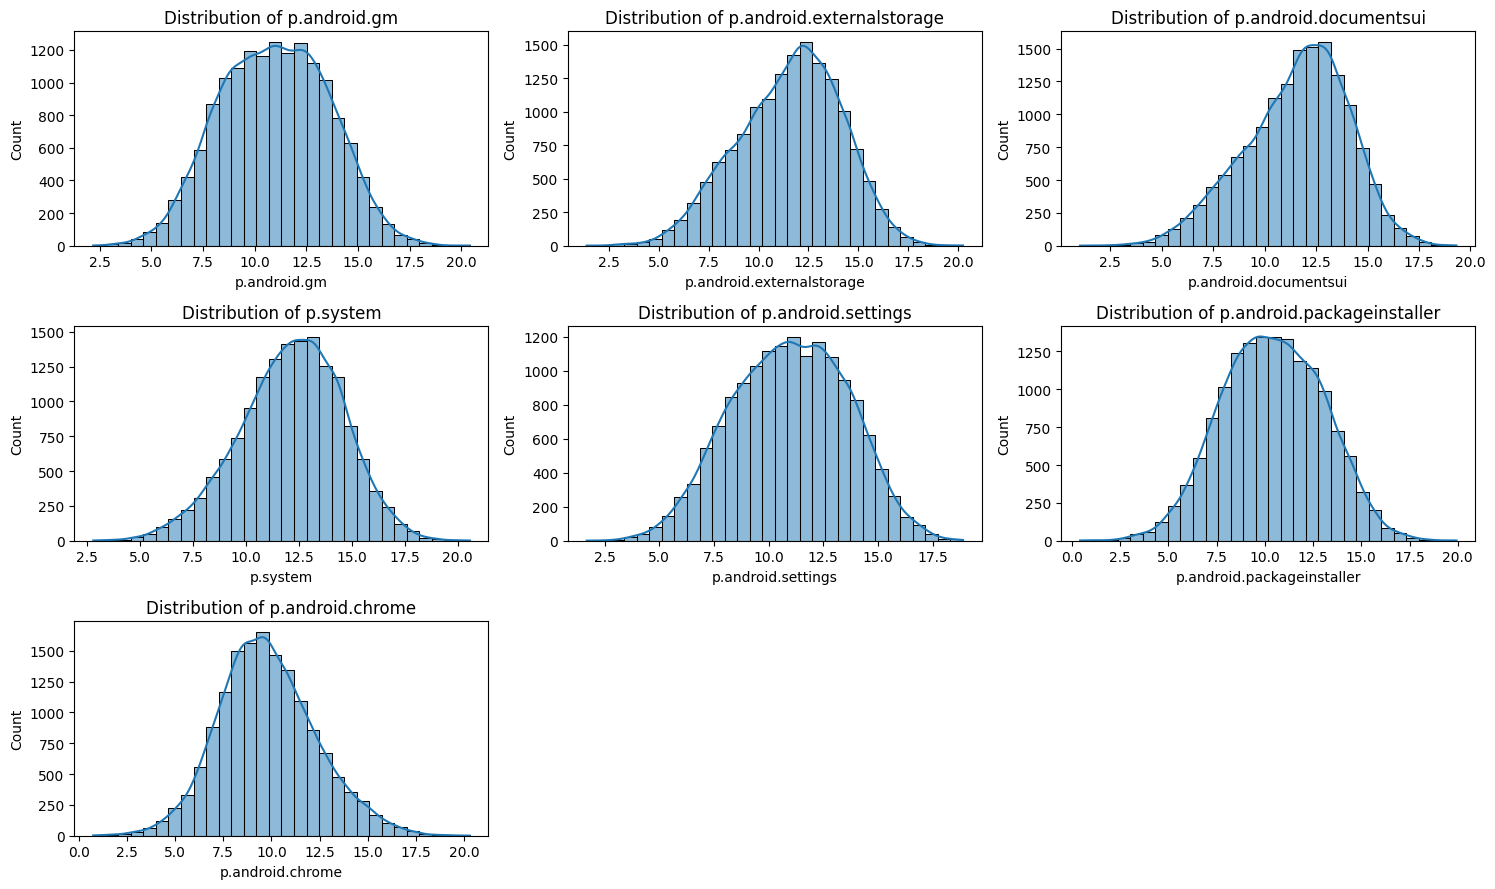

In [6]:
num_cols = 3
for ds in [relevant_connections.drop(columns=["mwra", "imei"]), relevant_processes.drop(columns=["mwra", "imei"])]:
    numeric_cols = ds.select_dtypes(include=['number']).columns
    num_plots = len(numeric_cols)

    num_rows = (num_plots // num_cols) + (num_plots % num_cols > 0)

    if num_rows == 0:
        continue

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 3))

    if num_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(ds[col], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_ylabel('Count')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

##### Boxploty

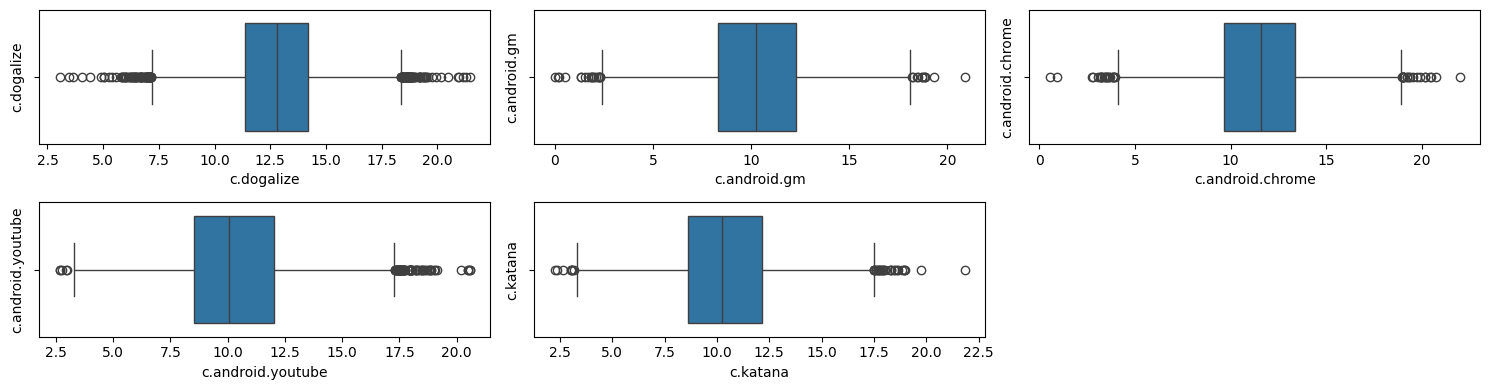

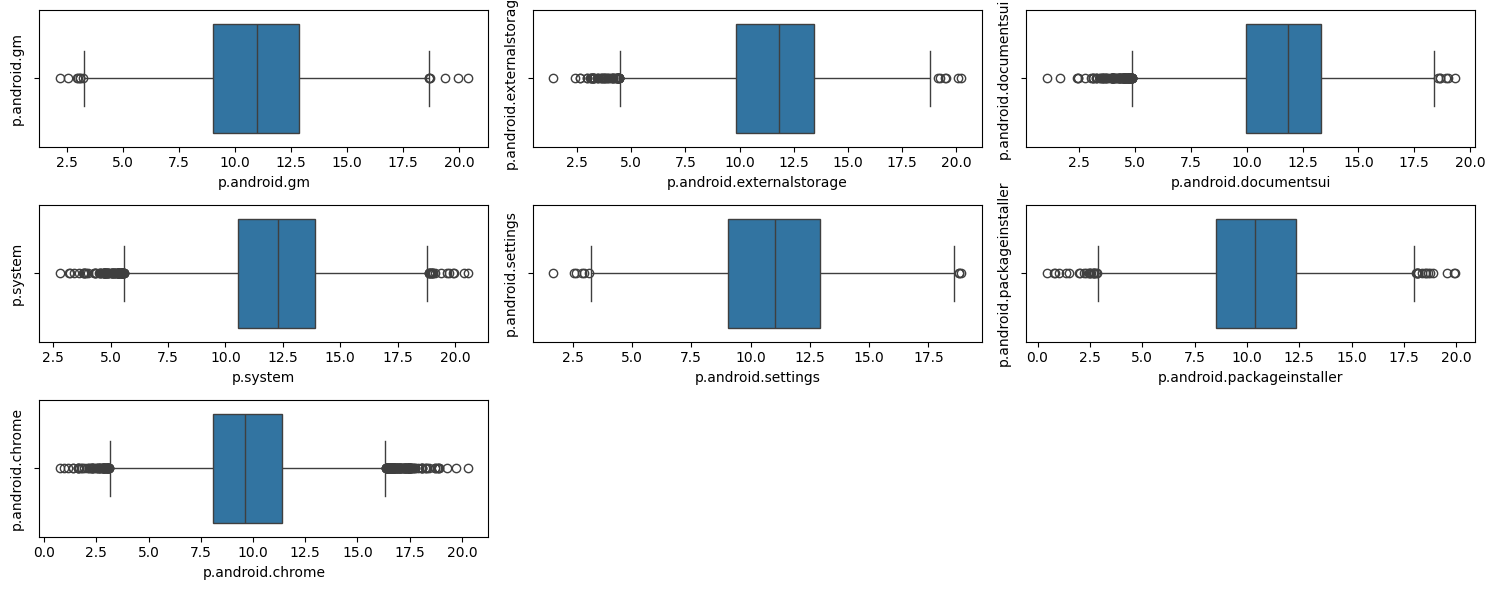

In [7]:
for ds in [relevant_connections.drop(columns=["mwra", "imei"]), relevant_processes.drop(columns=["mwra", "imei"])]:
    numeric_cols = ds.select_dtypes(include=['number']).columns
    num_plots = len(numeric_cols)

    num_rows = (num_plots // num_cols) + (num_plots % num_cols > 0)

    if num_rows == 0:
        continue

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 2))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=col, data=ds, ax=axes[i])
        axes[i].set_ylabel(col)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### Zhrnutie
Zo štatistík a grafov daných numerických premenných, nám vyplýva, že:
- zvolené premenné majú podobnú distribúciu podobnú gaussovej
- ich priemer, stredná hodnota a najčastejšia hodnota sú blízko pri sebe
- ich skewness je poväčšine malá, najvyššia hodnota je 0.397
- ich kurtosis je negatívna oproti gaussovej distribúcii
- na boxplotoch vidíme početný výskyt outlierov v každej premennej

## C
Párová analýza dát: Identifikujte vzťahy a závislostí medzi dvojicami atribútov.

Pre účely párovej analýzy sme sa pokúsili spojiť aspoň datasety processes a connections cez polia "imei" a "ts", aby sme mohli analyzovať párový vplyv premenných medzi súbormi.

In [8]:
pair_df = pd.merge(relevant_connections, relevant_processes, on=['ts', 'imei'], how='left')
print(pair_df.shape[0] - connections.shape[0])

358


Ako môžme ale vidieť, spojením datasetov nám pribudlo 358 riadkov, čo by ovplyvnilo našu analýzu, preto budeme pokračovať v analýze bez spojenia súborov.

### Párová analýza: connections

<Axes: >

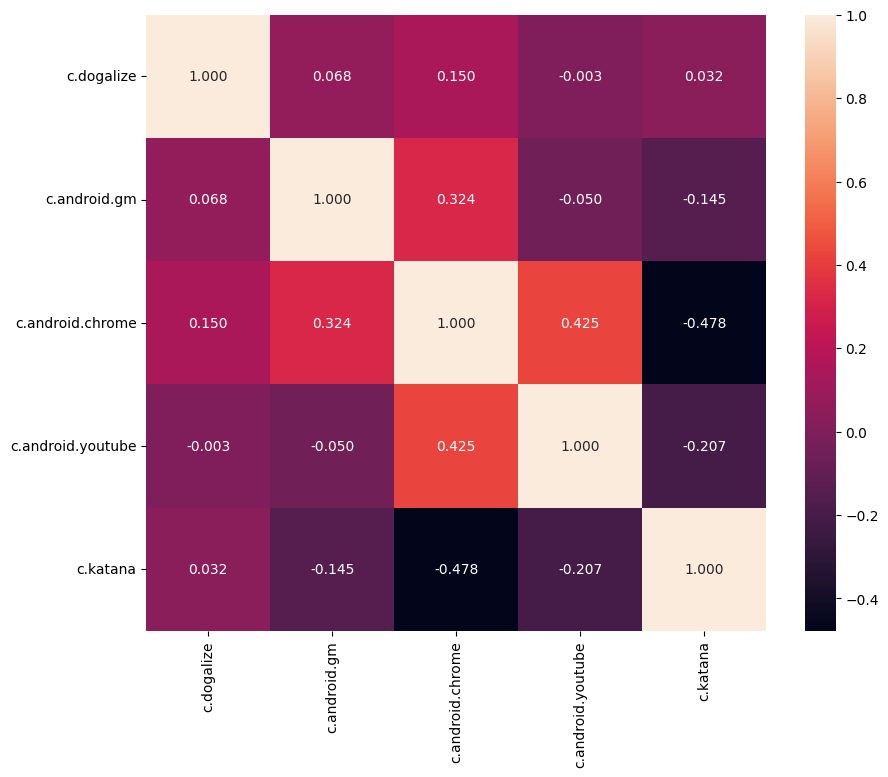

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(relevant_connections.drop(columns=["mwra", "imei", "ts"]).corr(), ax=ax, annot=True, fmt=".3f")

Z tejto mapy vidíme, že väčšina premnených spolu nesúvisí. Najvyššie hodnoty korelácie sú pri pároch:
- c.android.chrome a c.katana
- c.android.chrome a c.android.youtube
- c.android.chrome a c.android.gm

### Párová analýza: processes

<Axes: >

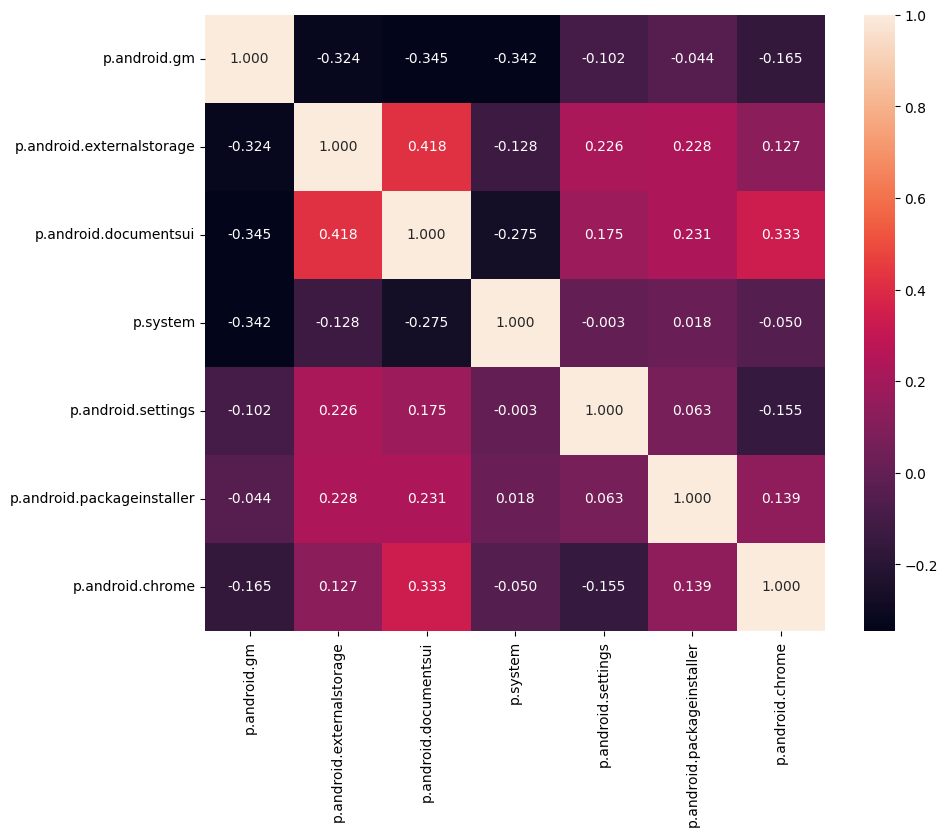

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(relevant_processes.drop(columns=["mwra", "imei", "ts"]).corr(), ax=ax, annot=True, fmt=".3f")

Z tejto mapy vidíme, že najvýznamnejšie negatívne korelácie sú medzi:
- p.android.gm a p.system
- p.android.gm a p.android.documentsui
- p.android.gm a p.android.externalstorage
  
A najvýznamnejšie pozitívne korelácie sú medzi:
- p.android.externalstorage a p.android.documentsui
- p.android.documentsui a p.android.chrome

## D
Párová analýza dát: Identifikujte závislosti medzi predikovanou premennou a
ostatnými premennými (potenciálnymi prediktormi).

### Connections
Analýza závislosti predikovanej premennej od ostatných atribútov v rámci connections

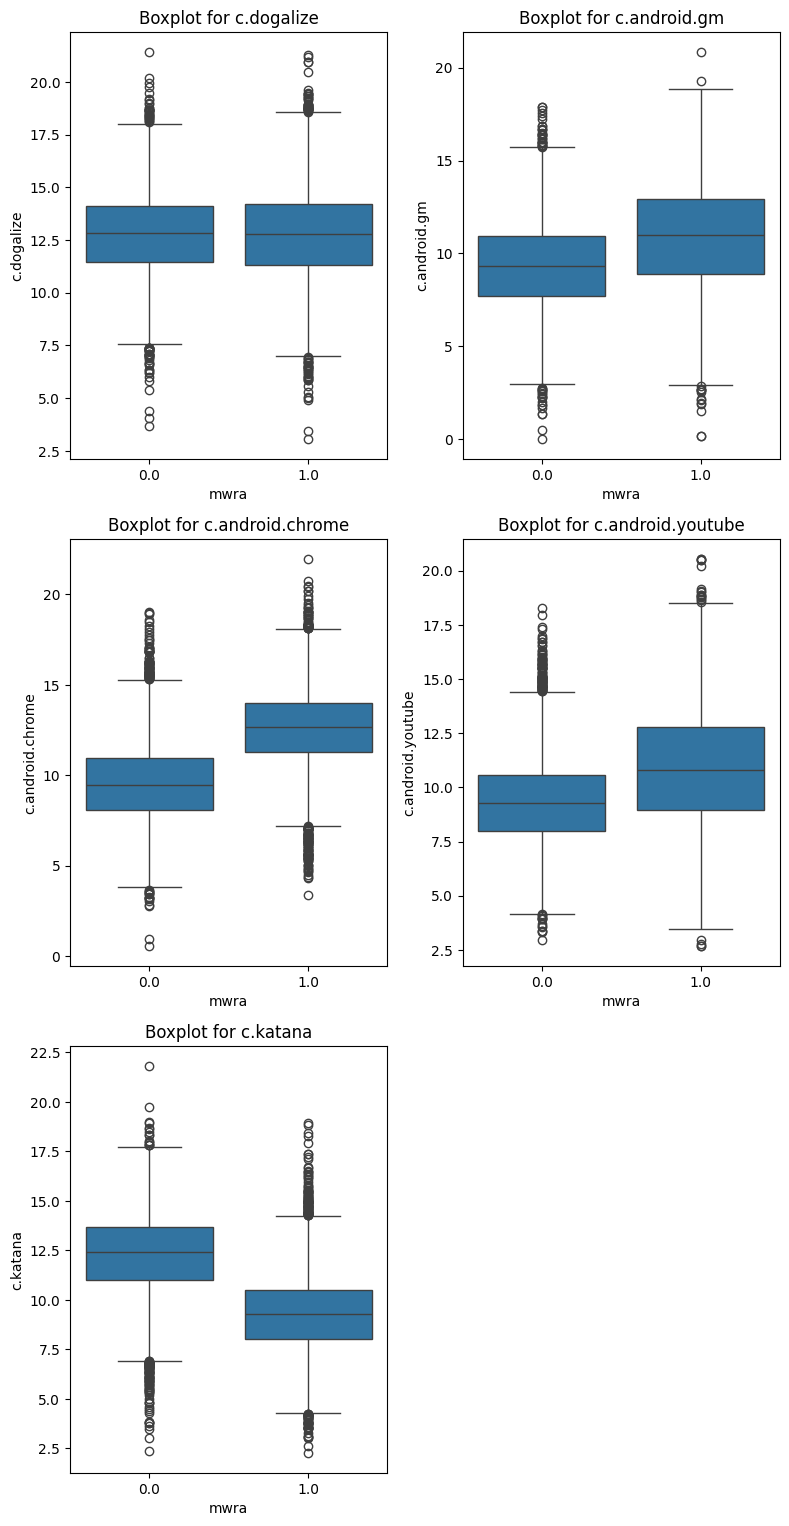

In [11]:
num_cols = len(relevant_connections.columns)
cols = 2
rows = (num_cols // cols) + (num_cols % cols > 0)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, rows * 5))
axes = axes.flatten()

for i, col in enumerate(relevant_connections.drop(columns=["mwra", "imei", "ts"]).columns):
    sns.boxplot(x='mwra', y=col, data=relevant_connections, ax=axes[i])
    axes[i].set_title(f'Boxplot for {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Z týchto grafov môžeme vidieť, že:
- hodnoty c.dogalize sú približne rovnaké, či bola zaznamenaná malvérová aktivita, alebo nie
- hodnoty c.android.youtube a c.android.gm sú trochu vyššie pri mwra = 1
- hodnoty c.android.chrome sú značne vyššie pri mwra = 1
- hodnoty c.katana sú značne nižšie pre mwra = 1

### Processes
Analýza závislosti predikovanej premennej od ostatných atribútov v rámci Processes

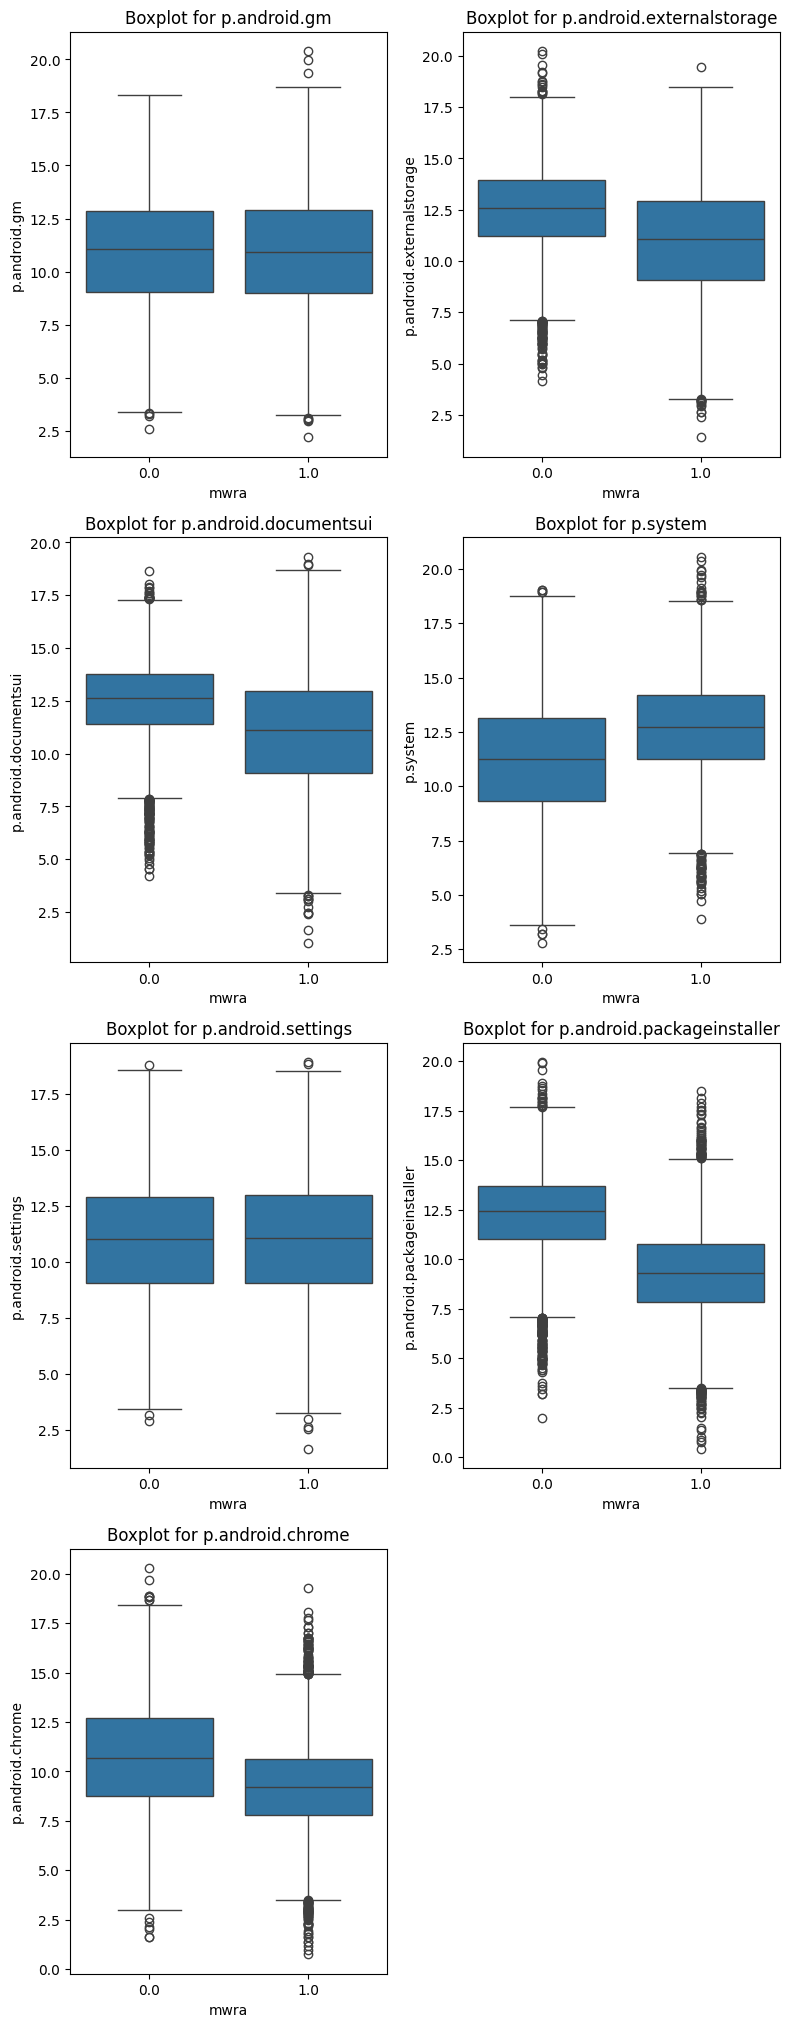

In [12]:
num_cols = len(relevant_processes.columns)
cols = 2
rows = (num_cols // cols) + (num_cols % cols > 0)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, rows * 5))
axes = axes.flatten()

for i, col in enumerate(relevant_processes.drop(columns=["mwra", "imei", "ts"]).columns):
    sns.boxplot(x='mwra', y=col, data=relevant_processes, ax=axes[i])
    axes[i].set_title(f'Boxplot for {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Z týchto grafov môžeme vidieť, že:
- hodnoty p.android.gm a p.android.settings sú približne rovnaké, či bola zaznamenaná malvérová aktivita, alebo nie
- hodnoty p.android.externalstorage, p.android.documentsui a p.android.chrome sú trochu nižšie pri mwra = 1
- hodnoty p.system sú trochu vyššie pri mwra = 1
- hodnoty p.android.packageinstaller sú značne nižšie pre mwra = 1

## E
Dokumentujte Vaše prvotné zamyslenie k riešeniu zadania projektu, napr. sú
niektoré atribúty medzi sebou závislé? od ktorých atribútov závisí predikovaná
premenná? či je potrebné kombinovať záznamy z viacerých súborov?

V rámci párovej analýzy sme našli určité závislosti medzi dvojimcami premenných, ako aj madzi ostatnými premennými a predikovanou premennou mwra. Hlavné párové závislosti sme našli medzi:
- c.android.chrome a c.katana (negatívna korelácia)
- c.android.chrome a c.android.youtube (pozitívna korelácia)
- c.android.chrome a c.android.gm (pozitívna korelácia)
- p.android.gm a p.system (negatívna korelácia)
- p.android.gm a p.android.documentsui (negatívna korelácia)
- p.android.gm a p.android.externalstorage (negatívna korelácia)
- p.android.externalstorage a p.android.documentsui (pozitívna korelácia)
- p.android.documentsui a p.android.chrome (pozitívna korelácia)

Hlavné závislosti medzi predikovanou premennou a ostatnými premennými, ktoré sme našli, sú medzi:
- hodnoty c.android.chrome sú značne vyššie pri mwra = 1
- hodnoty c.katana sú značne nižšie pre mwra = 1
- hodnoty p.android.packageinstaller sú značne nižšie pre mwra = 1

Pre párovú analýzu predikovanej premennej a ostatných premenných zatial nebolo potrebné kombinovať záznamy z viacerých súborov, keďže mwra sa nachádza aj v connections aj v processes. Kombinácia údajov zo súborov však určite poskytne ďaľšie informácie o možných párových závislostiach medzi ostatnými premennými z rôznych súborov, no, ako sme už vyššie uviedli, dáta nieje možné kombinovať dokopy, kým ich v ďalšej časti neprečistíme.

Z boxplotov časti D sa zdá že c.android.chrome by mohol mať vplyv na predikovanú premennú.

# 1.2 Identifikácia problémov, integrácia a čistenie dát

## A
Identifikujte aj prvotne riešte problémy v dátach napr.: nevhodná štruktúra dát,
duplicitné záznamy (riadky, stlpce), nejednotné formáty, chýbajúce hodnoty, vychýlené
hodnoty. V dátach sa môžu nachádzať aj iné, tu nevymenované problémy.

### Connections - problémy

#### Duplicitné záznamy

In [13]:
rows_duplicates = connections[connections.duplicated()]
len(rows_duplicates)

179

V datasete connections sa nachádza 179 duplicitných riadkov, tak ich vymažeme.

In [14]:
connections.drop_duplicates(inplace=True)

In [15]:
columns_duplicates = connections.T[connections.T.duplicated()]
len(columns_duplicates)

0

V datasete connections sa nenachádzajú žiadne duplicitné stĺpce.

#### Unikátne hodnoty

In [16]:
for col in connections.columns:
    print(f"{col:20}: {len(connections[col].unique())}")

ts                  : 14903
imei                : 500
mwra                : 2
c.dogalize          : 14738
c.android.gm        : 14799
c.android.chrome    : 14801
c.android.youtube   : 14767
c.katana            : 14767
c.updateassist      : 14882
c.UCMobile.x86      : 14879
c.android.vending   : 14888
c.raider            : 14892
c.UCMobile.intl     : 14887


V tomto výpise vidíme, koľko unikátnych hodnôt sa vyskytuje v jednotlivých stĺpcoch.

#### Chýbajúce hodnoty

In [17]:
connections.isnull().sum()

ts                   0
imei                 0
mwra                 0
c.dogalize           0
c.android.gm         0
c.android.chrome     0
c.android.youtube    0
c.katana             0
c.updateassist       0
c.UCMobile.x86       0
c.android.vending    0
c.raider             0
c.UCMobile.intl      0
dtype: int64

Môžeme vidieť, že v datasete connections nie sú žiadne chýbajúce hodnoty.

#### Vychýlené hodnoty

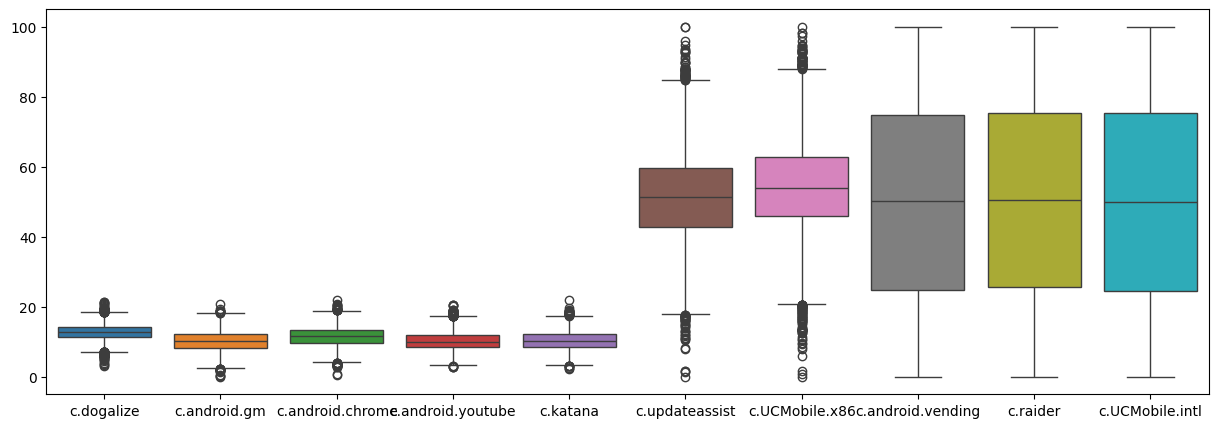

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=connections.drop(columns=["imei", "mwra", "ts"]))
plt.show()

In [19]:
connections_numeric = connections.select_dtypes(include=['number'])

Q1 = connections_numeric.quantile(0.25)
Q3 = connections_numeric.quantile(0.75)

IQR = Q3 - Q1

outliers = ((connections_numeric < (Q1 - 1.5 * IQR)) |
            (connections_numeric > (Q3 + 1.5 * IQR)))

outliers_count = outliers.sum()

print(outliers_count)

imei                   0
mwra                   0
c.dogalize           150
c.android.gm          29
c.android.chrome      43
c.android.youtube     73
c.katana              36
c.updateassist        95
c.UCMobile.x86       136
c.android.vending      0
c.raider               0
c.UCMobile.intl        0
dtype: int64


Môžeme vidieť, že vychýlené hodnoty sa nachádzajú v atribútoch:
- c.dogalize: 150
- c.android.gm: 30
- c.android.chrome: 43
- c.android.youtube: 75
- c.katana: 36
- c.updateassist: 97
- c.UCMobile.x86: 137

### Processes - problémy

#### Duplicitné záznamy

In [20]:
rows_duplicates = processes[processes.duplicated()]
len(rows_duplicates)

179

V datasete processes sa nachádza 179 duplicitných riadkov, tak ich vymažeme.

In [21]:
processes.drop_duplicates(inplace=True)

In [22]:
columns_duplicates = processes.T[processes.T.duplicated()]
len(columns_duplicates)

0

V datasete processes sa nenachádzajú žiadne duplicitné stĺpce.

#### Unikátne hodnoty

In [23]:
for col in processes.columns:
    print(f"{col:30}: {len(processes[col].unique())}")

ts                            : 14903
imei                          : 500
mwra                          : 2
p.android.gm                  : 14782
p.android.externalstorage     : 14795
p.android.documentsui         : 14753
p.system                      : 14774
p.android.settings            : 14793
p.android.packageinstaller    : 14788
p.android.chrome              : 14782
p.android.defcontainer        : 8367
p.gms.persistent              : 14880
p.notifier                    : 14883
p.dogalize                    : 14879
p.inputmethod.latin           : 14891
p.simulator                   : 14894
p.android.gms                 : 14899
p.android.vending             : 14891
p.katana                      : 14895
p.process.gapps               : 14895
p.google                      : 14890
p.olauncher                   : 14888
p.browser.provider            : 14896


V tomto výpise vidíme, koľko unikátnych hodnôt sa vyskytuje v jednotlivých stĺpcoch.

#### Chýbajúce hodnoty

In [24]:
processes.isnull().sum()

ts                            0
imei                          0
mwra                          0
p.android.gm                  0
p.android.externalstorage     0
p.android.documentsui         0
p.system                      0
p.android.settings            0
p.android.packageinstaller    0
p.android.chrome              0
p.android.defcontainer        0
p.gms.persistent              0
p.notifier                    0
p.dogalize                    0
p.inputmethod.latin           0
p.simulator                   0
p.android.gms                 0
p.android.vending             0
p.katana                      0
p.process.gapps               0
p.google                      0
p.olauncher                   0
p.browser.provider            0
dtype: int64

Môžeme vidieť, že v datasete processes nie sú žiadne chýbajúce hodnoty.

#### Vychýlené hodnoty

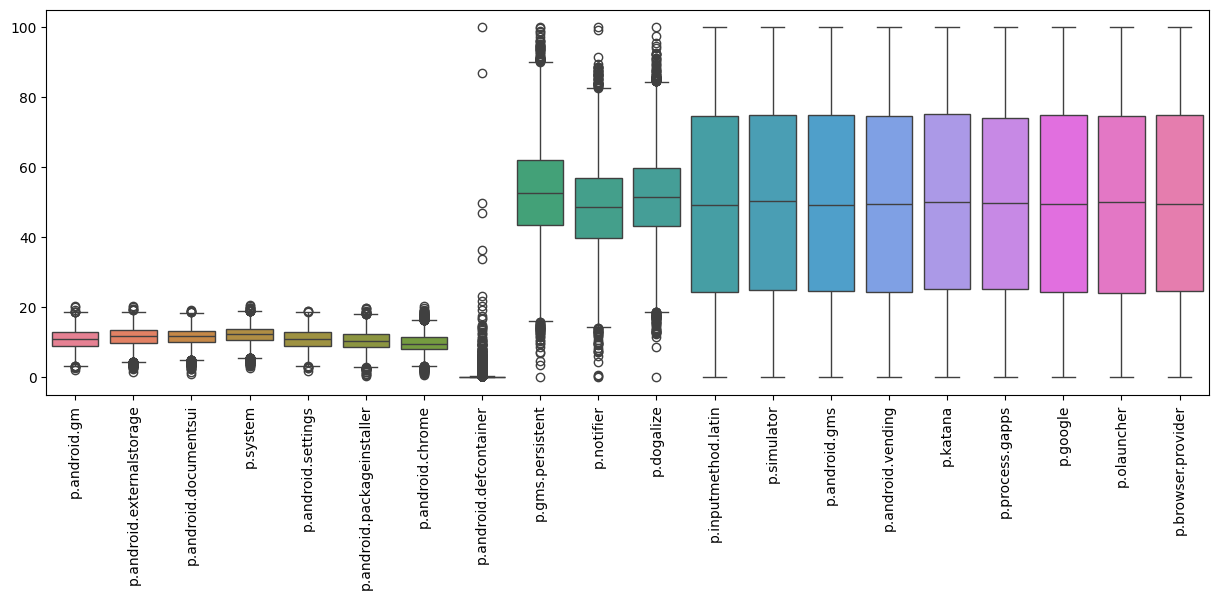

In [25]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=processes.drop(columns=["imei", "mwra", "ts"]), ax=ax)
plt.xticks(rotation=90)
plt.show()

In [26]:
processes_numeric = processes.select_dtypes(include=['number'])

Q1 = processes_numeric.quantile(0.25)
Q3 = processes_numeric.quantile(0.75)

IQR = Q3 - Q1

outliers = ((processes_numeric < (Q1 - 1.5 * IQR)) |
            (processes_numeric > (Q3 + 1.5 * IQR)))

outliers_count = outliers.sum()

print(outliers_count)

imei                             0
mwra                             0
p.android.gm                    15
p.android.externalstorage       53
p.android.documentsui           94
p.system                        96
p.android.settings               9
p.android.packageinstaller      34
p.android.chrome               179
p.android.defcontainer        2106
p.gms.persistent                89
p.notifier                      80
p.dogalize                     119
p.inputmethod.latin              0
p.simulator                      0
p.android.gms                    0
p.android.vending                0
p.katana                         0
p.process.gapps                  0
p.google                         0
p.olauncher                      0
p.browser.provider               0
dtype: int64


Môžeme vidieť, že vychýlené hodnoty sa nachádzajú v atribútoch:
- p.android.gm: 13
- p.android.externalstorage: 56
- p.android.documentsui: 96
- p.system: 96
- p.android.settings: 9
- p.android.packageinstaller: 34
- p.android.chrome: 183
- p.android.defcontainer: 2138
- p.gms.persistent: 90
- p.notifier: 81
- p.dogalize: 121

## B
Chýbajúce hodnoty (missing values): vyskúšajte riešiť problém min. 2 technikami
 - odstránenie pozorovaní s chýbajúcimi údajmi
 - nahradenie chýbajúcej hodnoty napr. mediánom, priemerom, pomerom, interpoláciou, alebo kNN

### Connections - chýbajúce hodnoty

In [27]:
connections.isnull().sum()

ts                   0
imei                 0
mwra                 0
c.dogalize           0
c.android.gm         0
c.android.chrome     0
c.android.youtube    0
c.katana             0
c.updateassist       0
c.UCMobile.x86       0
c.android.vending    0
c.raider             0
c.UCMobile.intl      0
dtype: int64

Môžeme vidieť, že v connections sa nenachádzajú žiadne chýbajúce hodnoty.

### Processes - chýbajúce hodnoty

In [28]:
processes.isnull().sum()

ts                            0
imei                          0
mwra                          0
p.android.gm                  0
p.android.externalstorage     0
p.android.documentsui         0
p.system                      0
p.android.settings            0
p.android.packageinstaller    0
p.android.chrome              0
p.android.defcontainer        0
p.gms.persistent              0
p.notifier                    0
p.dogalize                    0
p.inputmethod.latin           0
p.simulator                   0
p.android.gms                 0
p.android.vending             0
p.katana                      0
p.process.gapps               0
p.google                      0
p.olauncher                   0
p.browser.provider            0
dtype: int64

Môžeme vidieť, že v processes sa nenachádzajú žiadne chýbajúce hodnoty.

## C
 Vychýlené hodnoty (outlier detection), vyskúšajte riešiť problém min. 2 technikami
- odstránenie vychýlených alebo odľahlých pozorovaní
- nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (napr. 5%, 95%)
- vychýlené hodnoty sme našli v datasetoch devices, connections a processes

### Odstránenie vychýlených hodnôt

In [29]:
def drop_outliers(df):
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        df = df[(df[col] >= lower_limit) & (df[col] <= upper_limit)]
    return df

In [30]:
processes_cleaned = drop_outliers(processes)

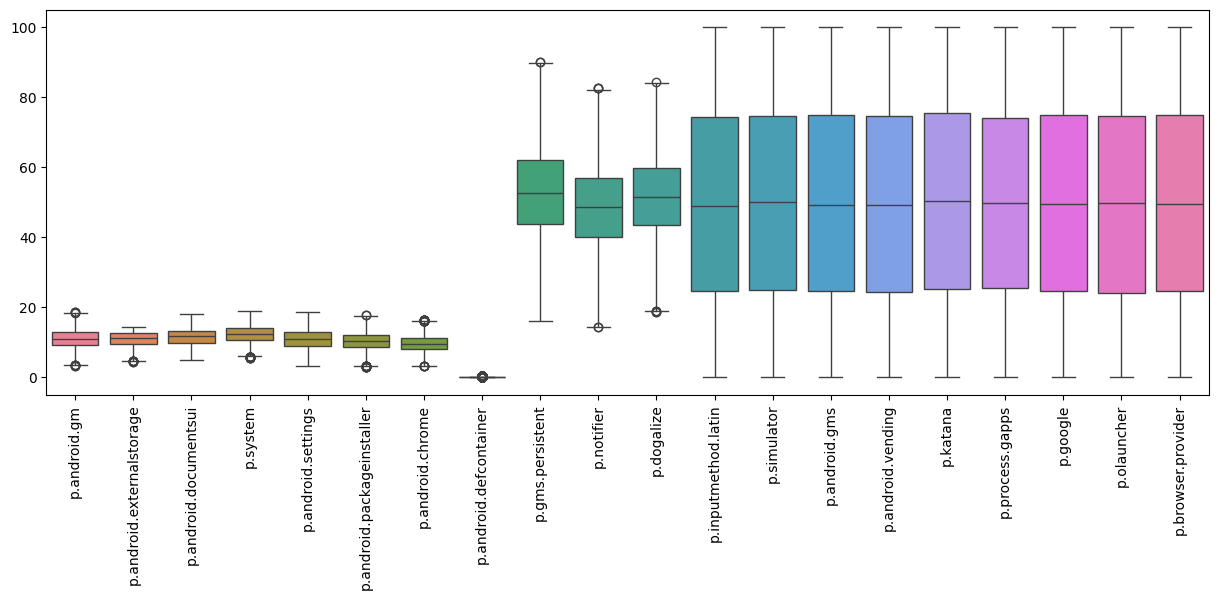

In [31]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=processes_cleaned.drop(columns=["imei", "mwra"]), ax=ax)
plt.xticks(rotation=90)
plt.show()

In [32]:
connections_cleaned = drop_outliers(connections)

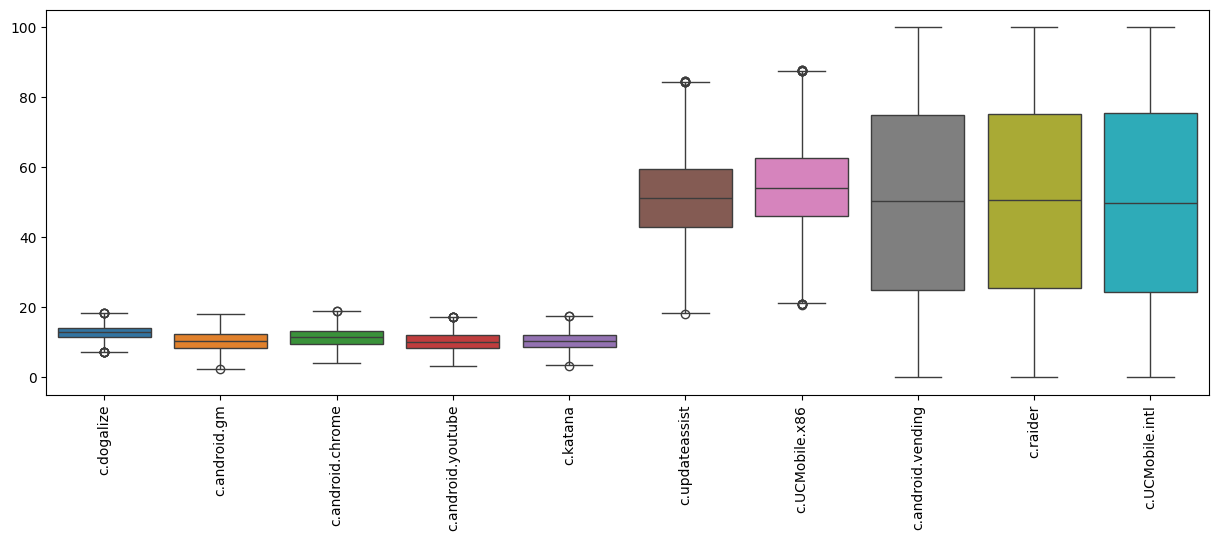

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=connections_cleaned.drop(columns=["imei", "mwra"]), ax=ax)
plt.xticks(rotation=90)
plt.show()

Z grafov vidíme, že distribúcie sa odstránením outlier hodnôt trochu upravili, stále však v každom datasete zostalo zopár outlier hodnôt, ktoré sú akurát pod hranicou odstraňovania. Navyše sa takto vymazali aj dáta z ostatných stĺpcov, čo je nechcené.

### Nahradenie vychýlených hodnôt hraničnými hodnotami

In [34]:
def modify_outliers(df):
    cleaned_data = df.copy()

    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        lower_percentile = df[col].quantile(0.05)
        upper_percentile = df[col].quantile(0.95)

        cleaned_data[col] = df[col].clip(lower=lower_percentile, upper=upper_percentile)

    return cleaned_data

In [35]:
processes_cleaned2 = modify_outliers(processes)

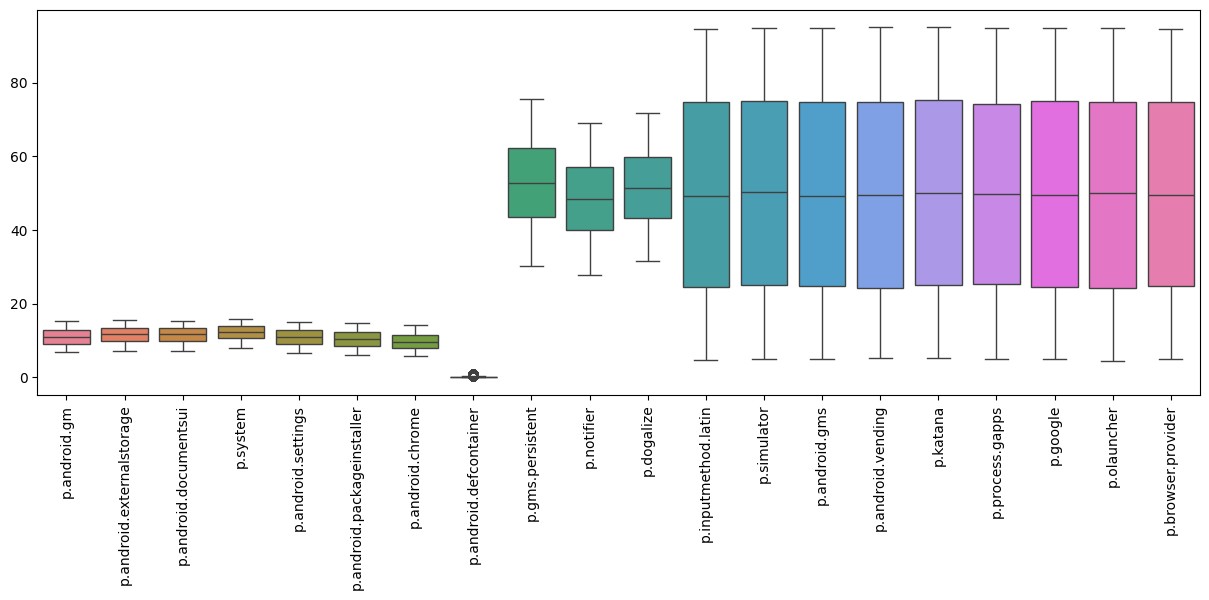

In [36]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=processes_cleaned2.drop(columns=["imei", "mwra"]), ax=ax)
plt.xticks(rotation=90)
plt.show()

In [37]:
connections_cleaned2 = modify_outliers(connections)

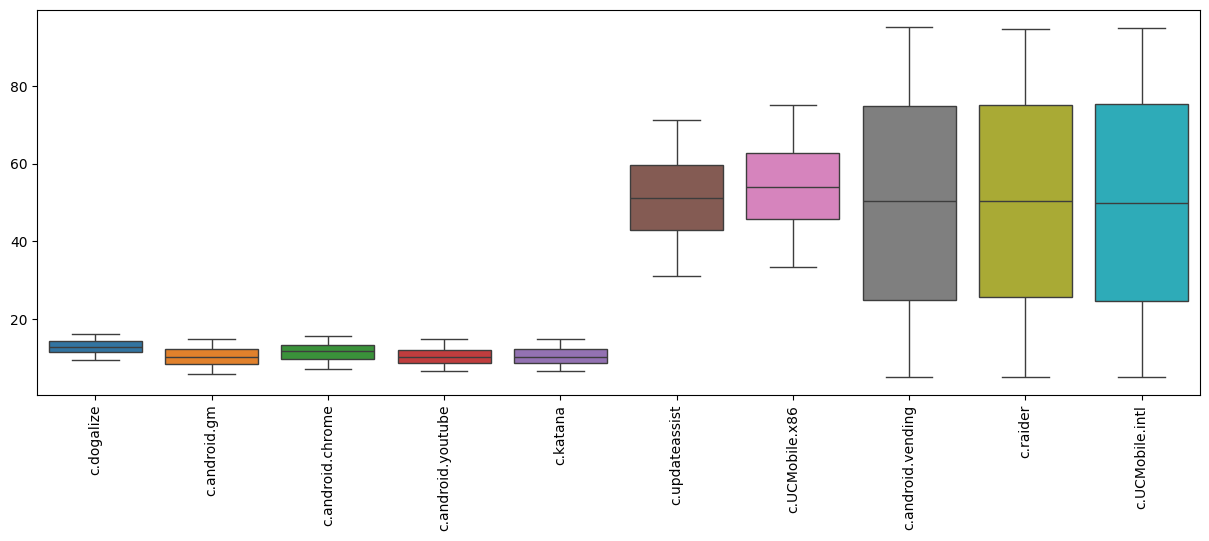

In [38]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=connections_cleaned2.drop(columns=["imei", "mwra"]), ax=ax)
plt.xticks(rotation=90)
plt.show()

Z grafov vidíme, že že týmto spôsobom sa outlier hodnoty skoro všade eliminovali, výnimkou je len stĺpec p.android.defcontainer v datasete processes. Keďže pri tejto metóde neprichádzame o žiadne dáta, je to lepšie ako prvá metóda.

# 1.3 Formulácia a štatistické overenie hypotéz o dátach

## A
Sformulujte dve hypotézy o dátach v kontexte zadanej predikčnej úlohy.
Formulované hypotézy overte vhodne zvolenými štatistickými testami
- hypoteza sa sklada z H0 a Ha

### Hypotéza 1

**$H_0$ (nulová hypotéza)**: Stĺpce c.android.youtube a c.android.chrome majú v priemere **rovnakú** hodnotu v stave mwra = 1.

**$H_1$ (alternatívna hypotéza)**: Stĺpce c.android.youtube a c.android.chrome majú v priemere **odlišnú** hodnotu v stave mwra = 1.

In [39]:
chrome = connections[connections['mwra'] == 1]['c.android.chrome']
youtube = connections[connections['mwra'] == 1]['c.android.youtube']

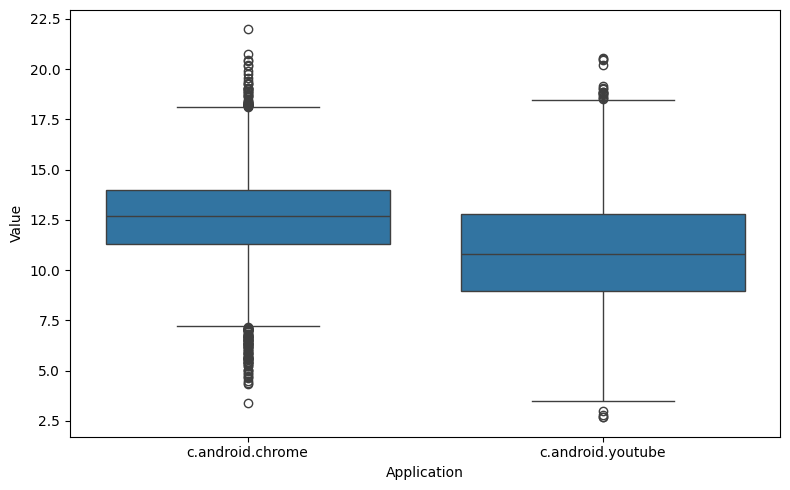

In [40]:
filtered_data = connections[connections['mwra'] == 1]

melted_data = pd.melt(filtered_data, value_vars=['c.android.chrome', 'c.android.youtube'],
                      var_name='Application', value_name='Value')

plt.figure(figsize=(8, 5))
sns.boxplot(data=melted_data, x='Application', y='Value')

plt.tight_layout()
plt.show()

Na základe vizualizácie môžeme vidieť, že v stĺpcoch je rozdiel, ten ale môže byť skreslený početnými vychýlenými hodnotami.

In [41]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)

    return a[(a > upper) | (a < lower)]

In [42]:
chrome_out = identify_outliers(chrome)
chrome = chrome.drop(chrome_out.index)

youtube_out = identify_outliers(youtube)
youtube = youtube.drop(youtube_out.index)

Týmto kódom sme identifikovali a následne odstránili z našich vzoriek odľahlé hodnoty.

#### Kontrola normality dát

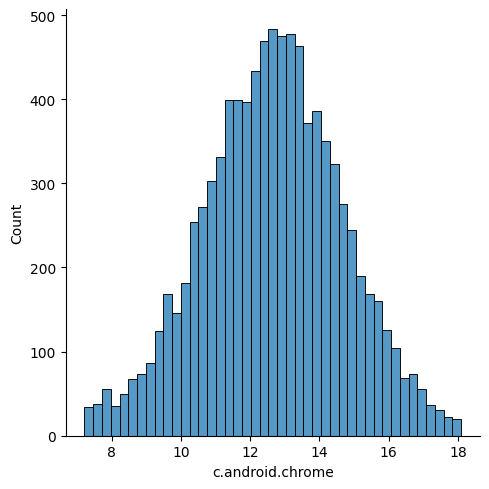

In [43]:
sns.displot(chrome)

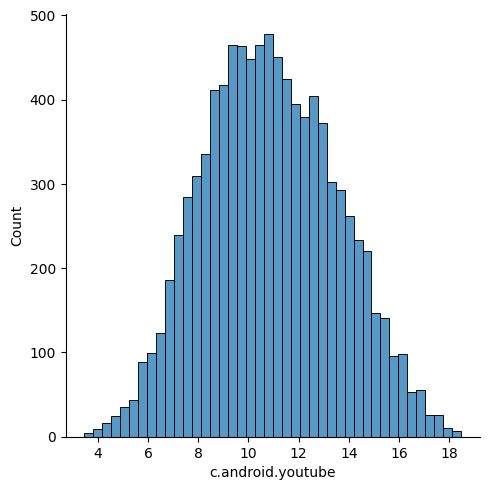

In [44]:
sns.displot(youtube)

##### Shapiro-Wilk test

**$H_0$ (nulová hypotéza)**: Dáta **pochádzajú** z normálneho rozdelenia.

**$H_1$ (alternatívna hypotéza)**: Dáta **nepochádzajú** z normálneho rozdelenia.

ShapiroResult(statistic=np.float64(0.9980794415836104), pvalue=np.float64(2.5604577357932948e-09))
Non-Normal distribution (reject H0)


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9219.
  res = hypotest_fun_out(*samples, **kwds)


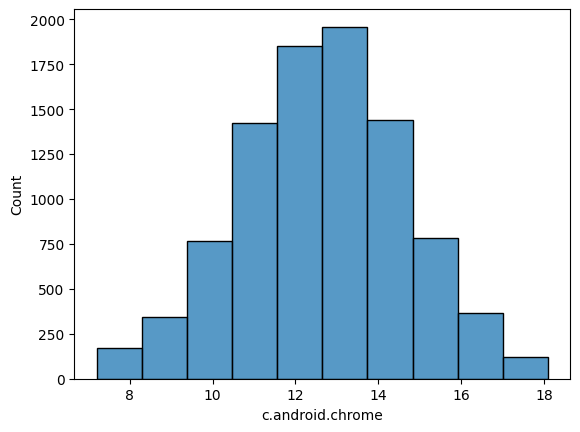

In [45]:
sns.histplot(chrome, bins=10)

shapiro_test = shapiro(chrome)
print(shapiro_test)

alpha = 0.05
if shapiro_test.pvalue > alpha:
    print('Normal distribution (fail to reject H0)')
else:
    print('Non-Normal distribution (reject H0)')

ShapiroResult(statistic=np.float64(0.9951355465353271), pvalue=np.float64(3.1538837492390577e-17))
Non-Normal distribution (reject H0)


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9342.
  res = hypotest_fun_out(*samples, **kwds)


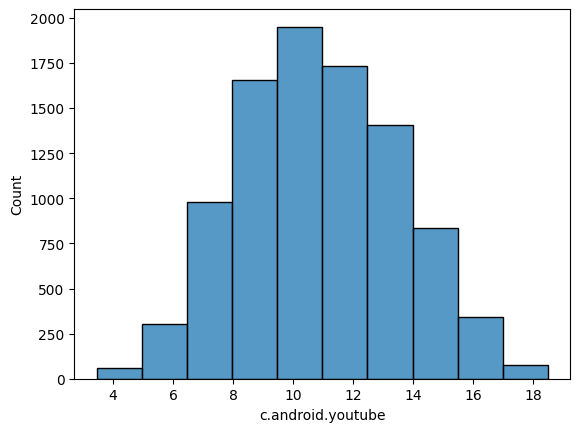

In [46]:
sns.histplot(youtube, bins=10)

shapiro_test = shapiro(youtube)
print(shapiro_test)

alpha = 0.05
if shapiro_test.pvalue > alpha:
    print('Normal distribution (fail to reject H0)')
else:
    print('Non-Normal distribution (reject H0)')

Výsledky z Shapiro-Wilk testu hlásia, že náš sample je väčší, než je prípustné pre stabilné výsledky. Napriek tomu sa výsledky Shapiro-Wilk testu a zobrazenia QQ-plotov zhodujú v tom, že ani jeden z atribútov nepochádza z normálneho rozdelenia, a preto nemôžeme použiť t-test. Namiesto toho musíme použiť neparametrickú verziu tohto testu, teda **Mann-Whitney U-test**.

##### Mann-Whitney U test

**$H_0$ (nulová hypotéza)**: Stĺpce c.android.youtube a c.android.chrome majú v priemere **rovnakú** hodnotu v stave mwra = 1.
**$H_1$ (alternatívna hypotéza)**: Stĺpce c.android.youtube a c.android.chrome majú v priemere **odlišnú** hodnotu v stave mwra = 1.

Statistics=60426854.000, p=0.000
Different distribution (reject H0)


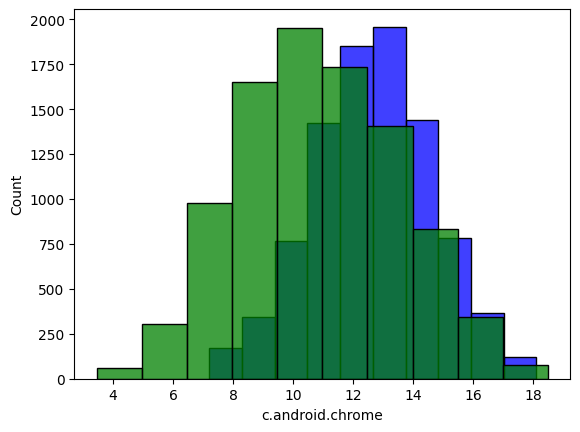

In [47]:
sns.histplot(chrome, bins=10, color="blue")
sns.histplot(youtube, bins=10, color="green")

stat, p = mannwhitneyu(chrome, youtube)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Na základe vykonaného Mann-Whitney U testu môžeme vidieť, že dáta pochadzajú z rôznych distribúcií, teda máme dostatok dôkazov na vyvrátenie nulovej hypotézy.

Stĺpce c.android.youtube a c.android.chrome majú v priemere **odlišnú** hodnotu v stave mwra = 1. Rozdiel medzi stĺpcami s.android.youtube a c.android.chrome v stave mwra = 1 **je štatisticky signifikantný.**

### Hypotéza 2

**$H_0$ (nulová hypotéza)**: Stĺpce p.android.externalstorage a p.android.documentsui majú v priemere **rovnakú** hodnotu v stave mwra = 1.

**$H_1$ (alternatívna hypotéza)**: Stĺpce p.android.externalstorage a p.android.documentsui majú v priemere **odlišnú** hodnotu v stave mwra = 1.

In [48]:
storage = processes[processes['mwra'] == 1]['p.android.externalstorage']
documents = processes[processes['mwra'] == 1]['p.android.documentsui']

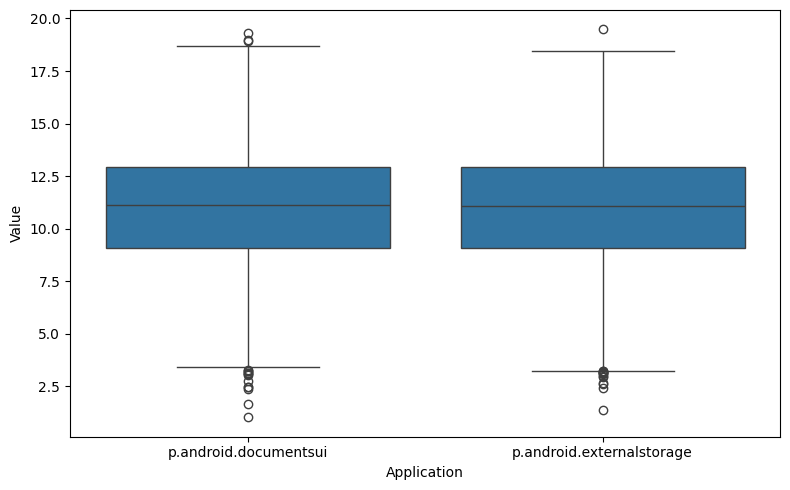

In [49]:
filtered_data = processes[processes['mwra'] == 1]

melted_data = pd.melt(filtered_data, value_vars=['p.android.documentsui', 'p.android.externalstorage'],
                      var_name='Application', value_name='Value')

plt.figure(figsize=(8, 5))
sns.boxplot(data=melted_data, x='Application', y='Value')

plt.tight_layout()
plt.show()

Na základe vizualizácie sa zdá, že v stĺpcoch nie je rozdiel, ale môže to byť skreslené početnými vychýlenými hodnotami.

In [50]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)

    return a[(a > upper) | (a < lower)]

In [51]:
storage_out = identify_outliers(storage)
storage = storage.drop(storage_out.index)

documents_out = identify_outliers(documents)
documents = documents.drop(documents_out.index)

Týmto kódom sme identifikovali a následne odstránili z našich vzoriek odľahlé hodnoty.

#### Kontrola normality dát

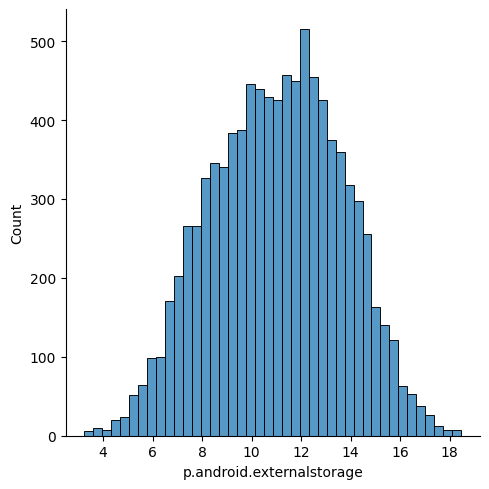

In [52]:
sns.displot(storage)

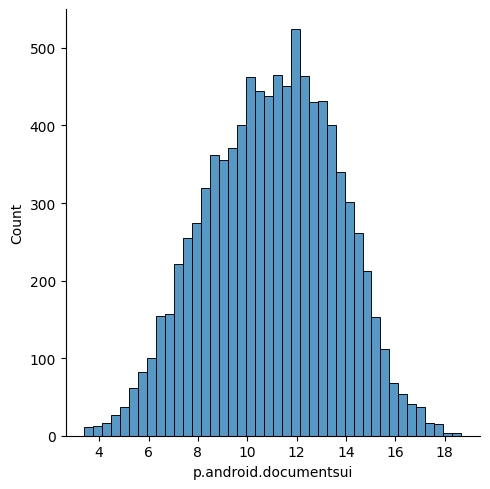

In [53]:
sns.displot(documents)

##### Shapiro-Wilk test

**$H_0$ (nulová hypotéza)**: Dáta **pochádzajú** z normálneho rozdelenia.

**$H_1$ (alternatívna hypotéza)**: Dáta **nepochádzajú** z normálneho rozdelenia.

ShapiroResult(statistic=np.float64(0.9950347259796856), pvalue=np.float64(1.9515099621385092e-17))
Non-Normal distribution (reject H0)


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9348.
  res = hypotest_fun_out(*samples, **kwds)


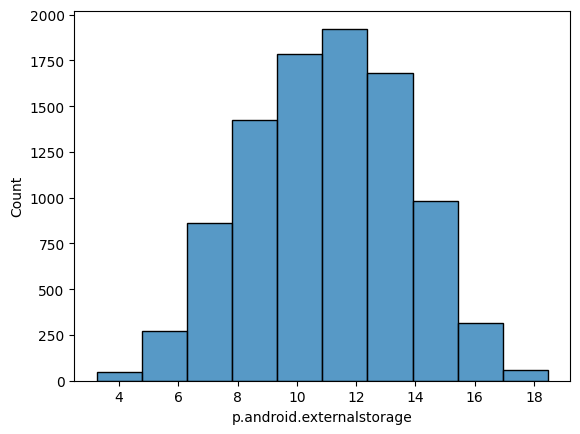

In [54]:
sns.histplot(storage, bins=10)

shapiro_test = shapiro(storage)
print(shapiro_test)

alpha = 0.05
if shapiro_test.pvalue > alpha:
    print('Normal distribution (fail to reject H0)')
else:
    print('Non-Normal distribution (reject H0)')

ShapiroResult(statistic=np.float64(0.9955152880014047), pvalue=np.float64(1.9245050235340473e-16))
Non-Normal distribution (reject H0)


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9346.
  res = hypotest_fun_out(*samples, **kwds)


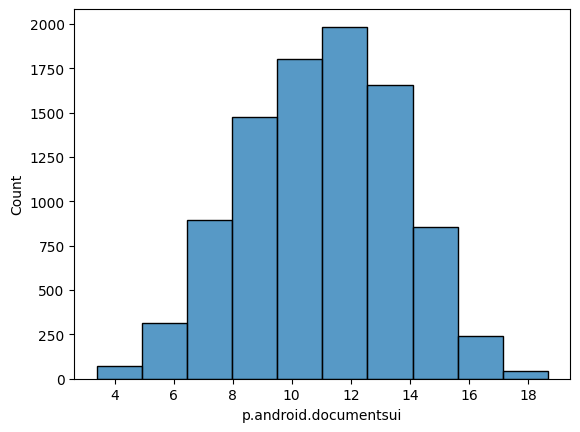

In [55]:
sns.histplot(documents, bins=10)

shapiro_test = shapiro(documents)
print(shapiro_test)

alpha = 0.05
if shapiro_test.pvalue > alpha:
    print('Normal distribution (fail to reject H0)')
else:
    print('Non-Normal distribution (reject H0)')

Výsledky z Shapiro-Wilk testu hlásia, že náš sample je väčší, než je prípustné pre stabilné výsledky. Napriek tomu sa výsledky Shapiro-Wilk testu a zobrazenia QQ-plotov zhodujú v tom, že ani jeden z atribútov nepochádza z normálneho rozdelenia, a preto nemôžeme použiť t-test. Namiesto toho musíme použiť neparametrickú verziu tohto testu, teda **Mann-Whitney U-test**.

##### Mann-Whitney U test

**$H_0$ (nulová hypotéza)**: Stĺpce c.android.youtube a c.android.chrome majú v priemere **rovnakú** hodnotu v stave malware-related-activity.

**$H_1$ (alternatívna hypotéza)**: Stĺpce c.android.youtube a c.android.chrome majú v priemere **odlišnú** hodnotu v stave malware-related-activity.

Statistics=43608183.500, p=0.839
Same distribution (fail to reject H0)


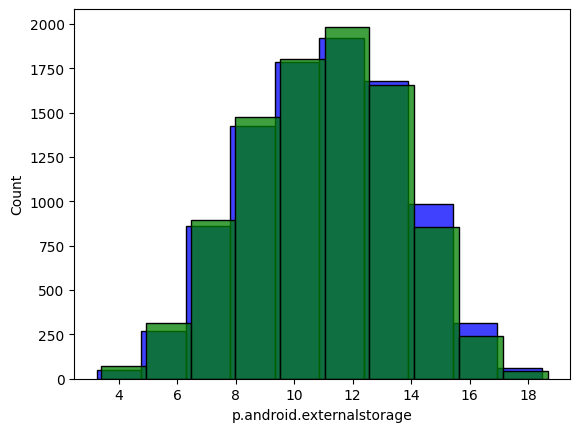

In [56]:
sns.histplot(storage, bins=10, color="blue")
sns.histplot(documents, bins=10, color="green")

stat, p = mannwhitneyu(storage, documents)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Na základe vykonaného Mann-Whitney U testu môžeme vidieť, že nemáme dostatočné dôkazy o tom, že dáta nepochadzajú z rovnakej distribúcie, a teda nenašiel sa dostatok dôkazov na vyvrátenie nulovej hypotézy.

Stĺpce p.android.externalstorage a p.android.documentsui  majú v priemere **rovnakú** hodnotu v stave mwra = 1. Rozdiel medzi stĺpcami p.android.externalstorage a p.android.documentsui v stave mwra = 1 **nie je štatisticky signifikantný.**

## B
Overte či Vaše štatistické testy majú dostatok podpory z dát, teda či majú
dostatočne silnú štatistickú silu

Keďže naše distribúcie nie sú normálne, na výpočet Effect Size použijeme Rank-Biserial Correlation. Na odhadnutie štatistickej sily pre neparametrické testy, ako je Mann-Whiteney U-test nie je v knižniciach priamy spôsob tak ako na parametrické testy, použijeme teda Chi-square power analysis ako blízku náhradu. Chi-square test sa síce používa na kategorické dáta, ale takisto ako Mann-Whiteney U-test dáta delí na skupiny (ranky) a porovnáva rozdiely medzi týmito skupinami.

### Prvá hypotéza


In [57]:
stat, p = mannwhitneyu(chrome, youtube)
n1 = len(chrome)
n2 = len(youtube)

r = 1 - (2 * stat) / (n1 * n2)


alpha = 0.05
power_analysis = GofChisquarePower()
effect_size = abs(r)

power = power_analysis.solve_power(effect_size=effect_size, nobs=n1 + n2, alpha=alpha)
print(f'Effect size: {effect_size:.4f}')
print(f'Significance level: {alpha:.2f}')
print(f'Estimated power: {power:.4f}')
print(f'First sample size: {n1}')
print(f'Second sample size: {n2}')

Effect size: 0.4033
Significance level: 0.05
Estimated power: 1.0000
First sample size: 9219
Second sample size: 9342


Ako môžme vidieť, veľkosť efektu je stredná, to znamená že rozdiel medzi distribúciami je pozorovateľný, ale nie extrémny, čo môžme vidieť aj z grafu. Štatistická sila 100%, aj keď je len odhadovaná pomocou Chi-square power analysis, znamená že máme 100% šancu, že odhalíme rozdiel medzi distribúciami, ak existuje. Táto sila sa dá vysvetliť tým, že máme pomerne veľké samples a stredný Effect size.

### Druhá hypotéza

In [58]:
stat, p = mannwhitneyu(documents, storage)
n1 = len(storage)
n2 = len(documents)

r = 1 - (2 * stat) / (n1 * n2)


alpha = 0.05
power_analysis = GofChisquarePower()
effect_size = abs(r)

power = power_analysis.solve_power(effect_size=effect_size, nobs=n1 + n2, alpha=alpha)
print(f'Effect size: {effect_size:.4f}')
print(f'Significance level: {alpha:.2f}')
print(f'Estimated power: {power:.4f}')
print(f'First sample size: {n1}')
print(f'Second sample size: {n2}')

Effect size: 0.0017
Significance level: 0.05
Estimated power: 0.0563
First sample size: 9348
Second sample size: 9346


Ako môžme vidieť, Effect size je extrémne malý, čo znamená, že rozdiel medzi distribúciami je minimálny. Takýto malý Effect size spôsobuje aj malú štatistickú silu (iba 5%), napriek tomu že samples máme veľké, čo naznačuje, že s tak malým Effect size nám ani veľkosť samplov veľmi nepomôže. Keďže štatistická sila tohto testu je veľmi malá, tak je veľká šanca, že tento test urobí Type II Error, čiže neodmietne nulovú hypotézu, ak nie je pravdivá. Treba však znovu poznamenať, že štatistickú silu sme len odhadli pomocou Chi-square power analysis, keďže pre Mann-Whiteney U-test výpočet štatistickej sily nemáme.

# Záver

V tejto fáze projektu sme sa venovali spracovaniu dát z rôznych datasetov, v ktorých sme hľadali závislosti, korelácie a deskriptívne štatistiky. Okrem toho sme tiež identifikovali problémy v dátach, ako napríklad zlé formátovanie, prítomnosť chýbajúcich či odľahlých hodnôt a duplicitné záznamy. Po prvotnom čistení dát sme vykonali testovanie hypotéz, kde sme otestovali 2 nami vytvorené hypotézy. Pri tomto testovaní sme overili aj to, či majú dáta normálne rozdelenie, pričom sme zistili, že mnohé atribúty toto rozdelenie nevykazujú, čo nám potvrdili výsledky Shapiro-Wilk testu a QQ-ploty. Preto sme namiesto parametricých testov použili neparametrický Mann-Whitney U-test.

V našich dátach sme tiež identifikovali početné vychýlené hodnoty, ktoré sme následne odstránili, prípadne inak nahradili. Párová analýza odhalila závislosti medzi dvojicami atribútov, pričom sme identifikovali niekoľko silných korelácií medzi premennými, napríklad medzi premennými c.android.chrome a c.katana (negatívna korelácia), a medzi p.android.documentsui a p.android.chrome (pozitívna korelácia).

Na základe tejto analýzy môžeme potvrdiť, že niektoré premenné súvisia s predikovanou premennou mwra, pričom konkrétne hodnoty ako c.android.chrome boli výrazne vyššie pri mwra = 1, zatiaľ čo hodnoty ako p.android.packageinstaller boli nižšie pri tejto hodnote.

Celková analýza priniesla množstvo zaujímavých poznatkov o závislostiach medzi atribútmi, ktoré budú užitočné pre ďalšiu predikciu a prácu v ďalších fázach zadania.

# 2.1 Realizácia predspracovania dát

## A
Dáta si rozdeľte na trénovaciu a testovaciu množinu podľa vami preddefinovaného pomeru. Ďalej pracujte len s trénovacím datasetom.

Na základe EDA v prvej fáze projektu sme sa rozhodli, že datasety profiles a devices nie sú potrebné pre účely predikcie predikovanej premennej mwra, keďže sa nedajú nijak rozumne spojiť s ostatnými dvomi datasetmi.

Naopak datasety processes a connections sa po vyčistení duplicitných riadkov v časti 1.2/A dajú pekne spojiť.

In [59]:
print(connections.shape)
print(processes.shape)
pair_df = pd.merge(connections, processes, on=['ts', 'imei'], how='left')
print(pair_df.shape)

(14903, 13)
(14903, 23)
(14903, 34)


Ako môžme vidieť, žiaden nový záznam tu nepribudol. Treba ešte pozrieť prípadnú duplicitu stĺpcov.

In [60]:
columns_duplicates = pair_df.T[pair_df.T.duplicated()]
columns_duplicates

0     1     2     3     4     5     6     7     8     9      ... 14893  \
mwra_y   1.0   1.0   0.0   0.0   0.0   1.0   1.0   0.0   1.0   0.0  ...   0.0   

       14894 14895 14896 14897 14898 14899 14900 14901 14902  
mwra_y   0.0   0.0   1.0   0.0   1.0   0.0   1.0   0.0   1.0  

[1 rows x 14903 columns]

Keďže sme aj v processes aj v connections nechali stĺpec mwra, máme v spojenom datasete teraz dva mwra stĺpce (mwra_x, mwra_y), ktoré majú rovnaké hodnoty. Jeden teda vymažeme a druhý premenujeme naspäť na mwra.

In [61]:
pair_df.drop(columns=['mwra_y'], inplace=True)
pair_df.rename(columns={'mwra_x': 'mwra'}, inplace=True)
pair_df.columns

Index(['ts', 'imei', 'mwra', 'c.dogalize', 'c.android.gm', 'c.android.chrome',
       'c.android.youtube', 'c.katana', 'c.updateassist', 'c.UCMobile.x86',
       'c.android.vending', 'c.raider', 'c.UCMobile.intl', 'p.android.gm',
       'p.android.externalstorage', 'p.android.documentsui', 'p.system',
       'p.android.settings', 'p.android.packageinstaller', 'p.android.chrome',
       'p.android.defcontainer', 'p.gms.persistent', 'p.notifier',
       'p.dogalize', 'p.inputmethod.latin', 'p.simulator', 'p.android.gms',
       'p.android.vending', 'p.katana', 'p.process.gapps', 'p.google',
       'p.olauncher', 'p.browser.provider'],
      dtype='object')

Takto pripravený datset si rozdelíme na trénovaciu a testovaciu množinu v pomere 75/25 trénovacie dáta/testovacie dáta.
Atribút random_state zaručí replikovateľnosť výsledkov.

In [62]:
pair_df.drop(columns=["imei"], inplace=True)
pair_df.head()

ts  mwra  c.dogalize  c.android.gm  c.android.chrome  \
0  2018-05-05 10:00:00   1.0     9.03970      14.35315          13.76020   
1  2018-05-05 10:01:00   1.0     9.41478       7.51650          12.31292   
2  2018-05-05 10:02:00   0.0    13.25806       7.23549          10.30754   
3  2018-05-05 10:03:00   0.0    11.41695       8.09047           8.96150   
4  2018-05-05 10:04:00   0.0    12.47250       9.28802           8.48795   

   c.android.youtube  c.katana  c.updateassist  c.UCMobile.x86  \
0           11.12559   6.73850        66.91554        54.28226   
1           12.55000   7.19936        32.67809        64.59178   
2            7.77630  13.17780        55.29738        36.98063   
3            9.97905  11.82898        38.55251        46.93124   
4            8.60786  11.82816        43.46316        43.94921   

   c.android.vending  ...  p.dogalize  p.inputmethod.latin  p.simulator  \
0           16.75773  ...    42.19751             79.40836     45.40991   
1           29.13667  ...    53.72498             39.27139     13.21933   
2           65.83367  ...    43.77214             36.49072     86.97079   
3           58.06052  ...    55.74452             48.78629      9.34253   
4           47.15770  ...    17.59833             49.69782      7.07021   

   p.android.gms  p.android.vending  p.katana  p.process.gapps  p.google  \
0       87.15437           51.41012  69.25298         20.06545  13.62688   
1       74.91757           30.24281  53.84815         21.26466   7.85091   
2       96.17420            7.71312  78.90782          8.32312  41.12966   
3       63.25140           61.82840  43.90015         83.45260  61.63458   
4       73.27845           46.34725  91.91502         19.71363  12.49803   

   p.olauncher  p.browser.provider  
0     21.52231            84.08213  
1      1.76933            40.47904  
2     75.38385            68.61776  
3     13.99080            62.90951  
4     80.71499             3.93994  

[5 rows x 32 columns]

Odstránenie stĺpca imei, keďže ho už ďalej nepotrebujeme. Poslúžil nám len na spojenie tabuliek.

In [63]:
train_df, test_df = train_test_split(pair_df, test_size=0.25, random_state=42)
train_df_backup = train_df
test_df_backup = test_df
print(train_df.shape)
print(test_df.shape)

(11177, 32)
(3726, 32)


## B
Transformujte dáta na vhodný formát pre ML t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte (encoding). Iteratívne integrujte aj kroky v predspracovaní dát z prvej fázy (missing values, outlier detection) ako celok.

Ako už vieme z predošlej fázy tohto projektu, náš trénovací dataset neobsahuje žiadne chýbajúce hodnoty.

### Transformácia na numerické hodnoty

In [64]:
train_df.head()

ts  mwra  c.dogalize  c.android.gm  c.android.chrome  \
11326  2018-05-13 06:46:00   1.0    11.82644      12.02021          12.73005   
8129   2018-05-11 01:29:00   1.0    13.11939       9.95731          10.32225   
10095  2018-05-12 10:15:00   1.0    14.96469      14.54640          13.17785   
4013   2018-05-08 04:53:00   0.0    14.31807      12.51089           5.69705   
11308  2018-05-13 06:28:00   0.0    13.87514      13.74394           7.07837   

       c.android.youtube  c.katana  c.updateassist  c.UCMobile.x86  \
11326            6.03340  11.03078        58.98033        33.72205   
8129             7.27321  10.62366        65.33153        77.69383   
10095            9.67398   9.48241        43.00198        45.65383   
4013             6.74804  11.48848        65.15448        56.97192   
11308            8.04491  13.29374        41.47281        43.98544   

       c.android.vending  ...  p.dogalize  p.inputmethod.latin  p.simulator  \
11326           25.17653  ...    47.91529             59.30167     85.15675   
8129            70.78853  ...    46.49915             45.89783     81.64641   
10095            5.34764  ...    63.92775             47.69768      9.32962   
4013            67.54933  ...    36.31379             49.33267     98.73879   
11308            3.03501  ...    32.52766             16.19424     51.94714   

       p.android.gms  p.android.vending  p.katana  p.process.gapps  p.google  \
11326       48.14953           47.12802  67.56882         46.13480  23.28195   
8129        11.55043           28.79036   8.42307         28.54506  93.96282   
10095       50.50064           79.78888  81.87942         16.65814  14.99045   
4013        12.96813           12.21756  58.56042         48.30965  26.69688   
11308       71.11071           10.16002   5.29301         72.93988  15.24421   

       p.olauncher  p.browser.provider  
11326     12.16911            41.40013  
8129       8.10096            52.52304  
10095     87.26814            55.03587  
4013      22.44654            81.57825  
11308     51.10565            68.09132  

[5 rows x 32 columns]

Stĺpec timestamp má typ string, všetky ostatné stĺpce majú typ float. Keďže časové údaje záznamov nám môžu potenciálne poskytnúť informácie o predikovanej premennej, najprv tento stĺpec prevedieme do numerických hodnôt a to tak, že vyrobíme nové stĺpce rok, mesiac, deň hodina, minúta a sekunda. Potom pozrieme ich hodnoty, a či sú dané stĺpce potrebné.

In [65]:
train_df['ts'] = pd.to_datetime(train_df['ts'], errors='raise')
train_df['year'] = train_df['ts'].dt.year
train_df['month'] = train_df['ts'].dt.month
train_df['day'] = train_df['ts'].dt.day
train_df['hour'] = train_df['ts'].dt.hour
train_df['minute'] = train_df['ts'].dt.minute
train_df['second'] = train_df['ts'].dt.second
train_df = train_df.drop(columns=['ts'])

print(train_df.head())

       mwra  c.dogalize  c.android.gm  c.android.chrome  c.android.youtube  \
11326   1.0    11.82644      12.02021          12.73005            6.03340   
8129    1.0    13.11939       9.95731          10.32225            7.27321   
10095   1.0    14.96469      14.54640          13.17785            9.67398   
4013    0.0    14.31807      12.51089           5.69705            6.74804   
11308   0.0    13.87514      13.74394           7.07837            8.04491   

       c.katana  c.updateassist  c.UCMobile.x86  c.android.vending  c.raider  \
11326  11.03078        58.98033        33.72205           25.17653  79.89133   
8129   10.62366        65.33153        77.69383           70.78853  98.69200   
10095   9.48241        43.00198        45.65383            5.34764  55.02601   
4013   11.48848        65.15448        56.97192           67.54933  83.84994   
11308  13.29374        41.47281        43.98544            3.03501  52.36255   

       ...  p.process.gapps  p.google  p.olauncher

In [66]:
print(train_df["second"].unique())
print(train_df["year"].unique())
print(train_df["month"].unique())

[0]
[2018]
[5]


Ako môžme vidieť, v stĺpcoch second, year a month je iba jedna unikátna hodnota, čiže tieto stĺpce môžme dropnúť.

In [67]:
train_df = train_df.drop(columns=["second", "year", "month"])

## Vychýlené hodnoty
Keďže už máme všetky stĺpce prevedené na numerické typy, môžme sa pozrieť na vychýlené hodnoty.

In [68]:
def get_outlier_columns(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
    outliers_count = outliers.sum()

    outlier_columns = []
    for column, count in outliers_count.items():
        if count > 0:
            outlier_columns.append(column)
            print(f'Stĺpec: {column:28} Počet outlierov: {count}')

    return outlier_columns

outlier_columns = get_outlier_columns(train_df)

Stĺpec: c.dogalize                   Počet outlierov: 115
Stĺpec: c.android.gm                 Počet outlierov: 21
Stĺpec: c.android.chrome             Počet outlierov: 32
Stĺpec: c.android.youtube            Počet outlierov: 54
Stĺpec: c.katana                     Počet outlierov: 26
Stĺpec: c.updateassist               Počet outlierov: 74
Stĺpec: c.UCMobile.x86               Počet outlierov: 106
Stĺpec: p.android.gm                 Počet outlierov: 10
Stĺpec: p.android.externalstorage    Počet outlierov: 38
Stĺpec: p.android.documentsui        Počet outlierov: 62
Stĺpec: p.system                     Počet outlierov: 68
Stĺpec: p.android.settings           Počet outlierov: 9
Stĺpec: p.android.packageinstaller   Počet outlierov: 31
Stĺpec: p.android.chrome             Počet outlierov: 133
Stĺpec: p.android.defcontainer       Počet outlierov: 1576
Stĺpec: p.gms.persistent             Počet outlierov: 70
Stĺpec: p.notifier                   Počet outlierov: 59
Stĺpec: p.dogalize         

Keďže vychýlených hodnôt tu je celkom dosť, vymazávanie riadkov s týmito hodnotami by viedlo k strate podstatnej časti dát.
Pomocou boxplotov sa ešte pozrieme sa  bližšie na to, aké tieto vychýlené hodnoty sú.

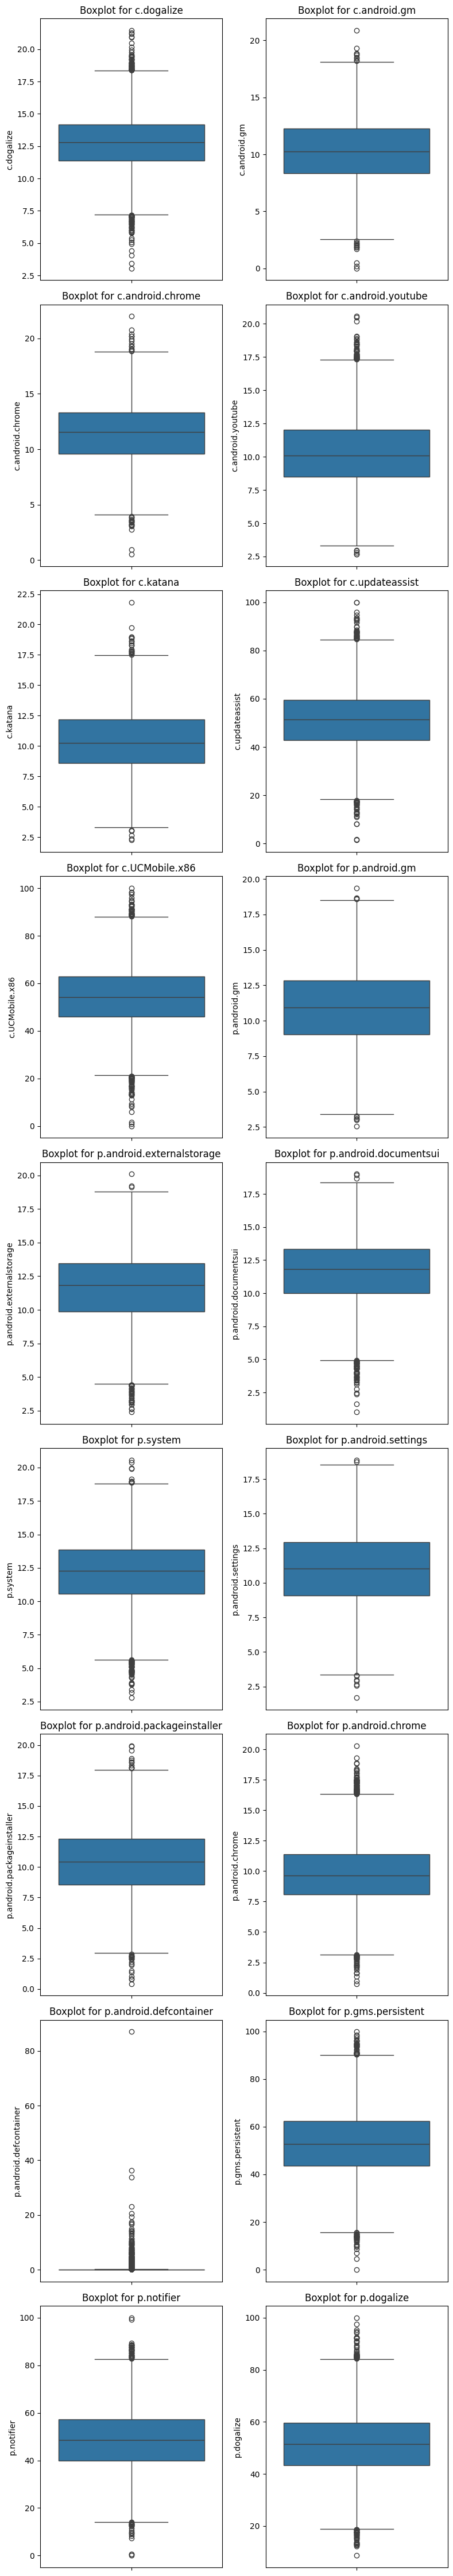

<Figure size 640x480 with 0 Axes>

In [69]:
num_cols = len(outlier_columns)
cols = 2
rows = (num_cols // cols) + (num_cols % cols > 0)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, rows * 5))
axes = axes.flatten()

for i, col in enumerate(outlier_columns):
    sns.boxplot(y=col, data=train_df, ax=axes[i])
    axes[i].set_title(f'Boxplot for {col}')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [70]:
def replace_outliers(df):
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

    return df

train_df = replace_outliers(train_df)
_ = get_outlier_columns(train_df)

Ako môžme vidieť, funkcia už nevykazuje žiadne vychýlené hodnoty, nahradili sme ich hraničnými hodnotami.

## C
Transformujte atribúty dát pre strojové učenie podľa dostupných techník minimálne: scaling (2 techniky), transformers (2 techniky) a ďalšie. Cieľom je aby ste testovali efekty a vhodne kombinovali v dátovom pipeline (od časti 2.3 a v 3. fáze).

### Scaling

#### Standard Scaler

In [71]:
from sklearn.preprocessing import StandardScaler

y = train_df["mwra"]
X = train_df.drop(columns=["mwra"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
standard_scaled = pd.concat([y.reset_index(drop=True), X_scaled_df], axis=1)

standard_scaled.head()

mwra  c.dogalize  c.android.gm  c.android.chrome  c.android.youtube  \
0   1.0   -0.456284      0.634160          0.487978          -1.688131   
1   1.0    0.162452     -0.125458         -0.433186          -1.201000   
2   1.0    1.045514      1.564374          0.659295          -0.257718   
3   0.0    0.736076      0.814842         -2.202671          -1.407343   
4   0.0    0.524114      1.268886         -1.674212          -0.897793   

   c.katana  c.updateassist  c.UCMobile.x86  c.android.vending  c.raider  ...  \
0  0.250899        0.633007       -1.641417          -0.862377  1.023517  ...   
1  0.088089        1.152268        1.863964           0.715310  1.673957  ...   
2 -0.368305       -0.673351       -0.690229          -1.548245  0.163260  ...   
3  0.433937        1.137793        0.212036           0.603269  1.160472  ...   
4  1.155873       -0.798373       -0.823231          -1.628237  0.071114  ...   

   p.android.gms  p.android.vending  p.katana  p.process.gapps  p.google  \
0      -0.054384          -0.084029  0.598368        -0.122259 -0.910004   
1      -1.314545          -0.718540 -1.442489        -0.734399  1.525265   
2       0.026568           1.046087  1.092163        -1.148075 -1.195683   
3      -1.265732          -1.291984  0.287528        -0.046572 -0.792345   
4       0.736203          -1.363178 -1.550493         0.810583 -1.186940   

   p.olauncher  p.browser.provider       day      hour    minute  
0    -1.277904           -0.287053  0.960471 -0.807851  0.963726  
1    -1.417876            0.098455  0.296761 -1.536942 -0.019852  
2     1.306003            0.185547  0.628616 -0.224579 -0.829857  
3    -0.924292            1.105478 -0.698805 -1.099488  1.368729  
4     0.061773            0.638035  0.960471 -0.807851 -0.077709  

[5 rows x 34 columns]

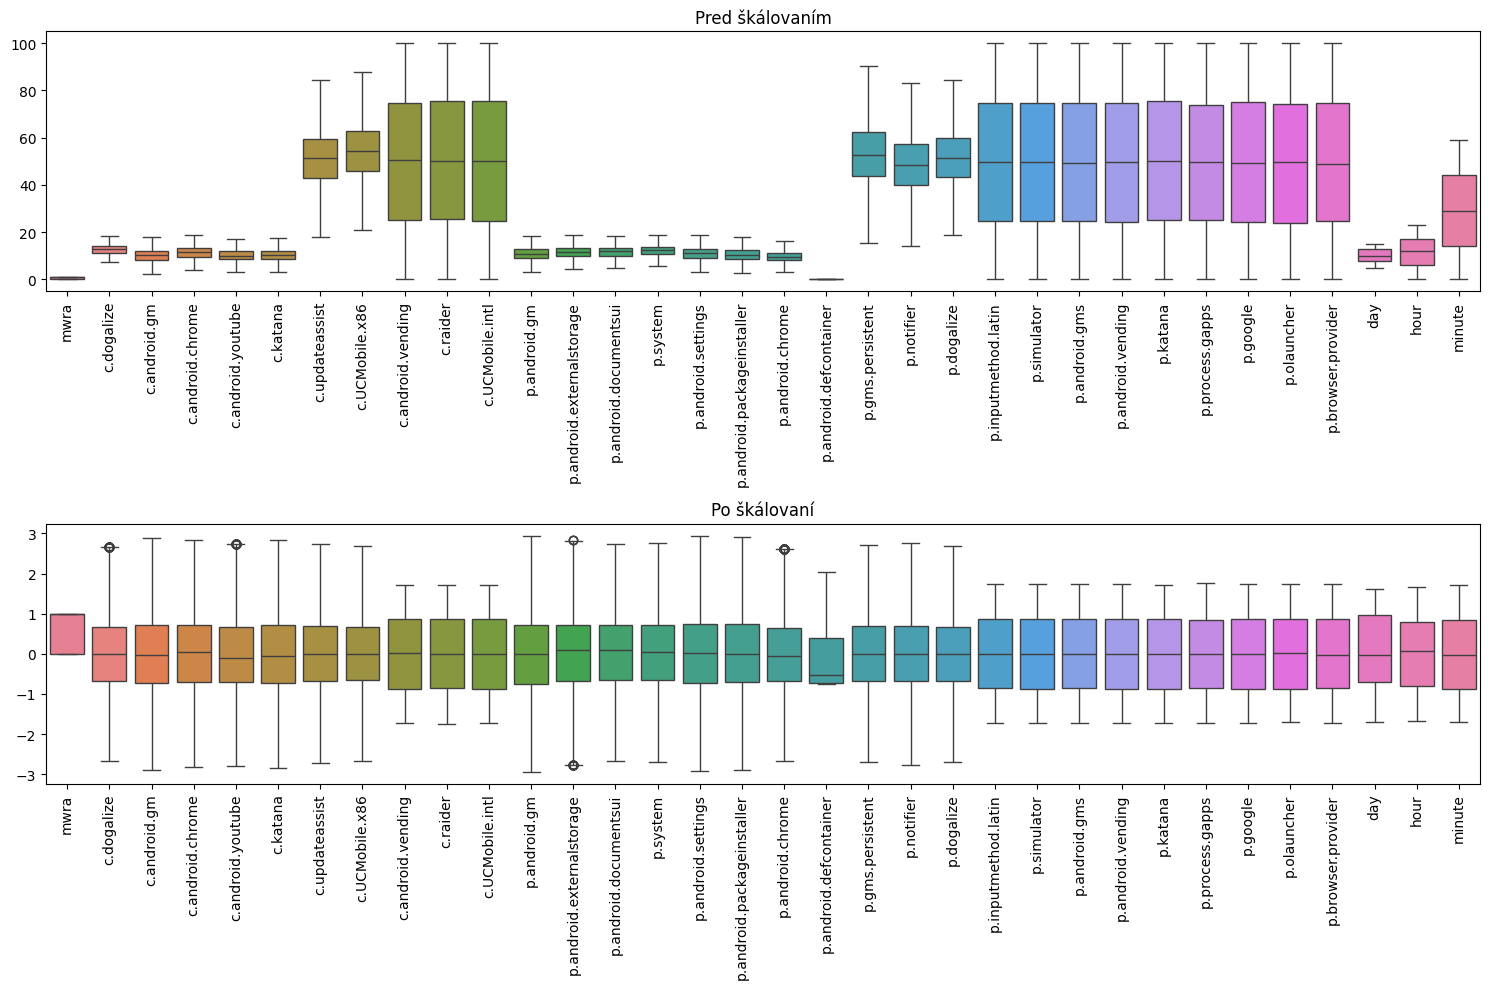

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

sns.boxplot(data=train_df, ax=axes[0])
axes[0].set_title("Pred škálovaním")
axes[0].tick_params(axis='x', rotation=90)

sns.boxplot(data=standard_scaled, ax=axes[1])
axes[1].set_title("Po škálovaní")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

**Graf Pred škálovaním**: Zobrazuje rozdelenie atribútov v pôvodných údajoch bez aplikácie škálovania. Z grafu môžeme vidieť, že niektoré atribúty majú široký rozsah hodnôt a tiež to, že rôzne atribúty majú rôzne rozsahy hodnôt.

**Graf Po škálovaní**: Zobrazuje rozdelenie atribútov po aplikácii MinMax škálovania, ktoré normalizuje všetky hodnoty medzi 0 a 1. Po škálovaní sú hodnoty oveľa koncentrovanejšie a extrémy sú potlačené.

#### Robust Scaling

In [73]:
from sklearn.preprocessing import RobustScaler

y = train_df["mwra"]

X = train_df.drop(columns=["mwra"])

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
robust_scaled = pd.concat([y.reset_index(drop=True), X_scaled_df], axis=1)

robust_scaled.head()

mwra  c.dogalize  c.android.gm  c.android.chrome  c.android.youtube  \
0   1.0   -0.345892      0.456431          0.313735          -1.147210   
1   1.0    0.117267     -0.069648         -0.336982          -0.794965   
2   1.0    0.778288      1.100659          0.434754          -0.112878   
3   0.0    0.546656      0.581564         -1.586958          -0.944172   
4   0.0    0.387990      0.896016         -1.213652          -0.575716   

   c.katana  c.updateassist  c.UCMobile.x86  c.android.vending  c.raider  ...  \
0  0.221061        0.458861       -1.222184          -0.508190  0.593198  ...   
1  0.106664        0.839861        1.400929           0.407008  0.970378  ...   
2 -0.214016       -0.499661       -0.510400          -0.906054  0.094348  ...   
3  0.349670        0.829240        0.164775           0.342014  0.672616  ...   
4  0.856931       -0.591394       -0.609927          -0.952456  0.040914  ...   

   p.android.gms  p.android.vending  p.katana  p.process.gapps  p.google  \
0      -0.023167          -0.047408  0.348645        -0.073034 -0.511525   
1      -0.752952          -0.411461 -0.822353        -0.435430  0.879594   
2       0.023714           0.601000  0.631974        -0.680333 -0.674715   
3      -0.724683          -0.740477  0.170292        -0.028227 -0.444313   
4       0.434678          -0.781324 -0.884324         0.479223 -0.669721   

   p.olauncher  p.browser.provider  day      hour    minute  
0    -0.741783           -0.153236  0.6 -0.545455  0.566667  
1    -0.822533            0.069271  0.2 -1.000000  0.000000  
2     0.748889            0.119538  0.4 -0.181818 -0.466667  
3    -0.537782            0.650501 -0.4 -0.727273  0.800000  
4     0.031085            0.380704  0.6 -0.545455 -0.033333  

[5 rows x 34 columns]

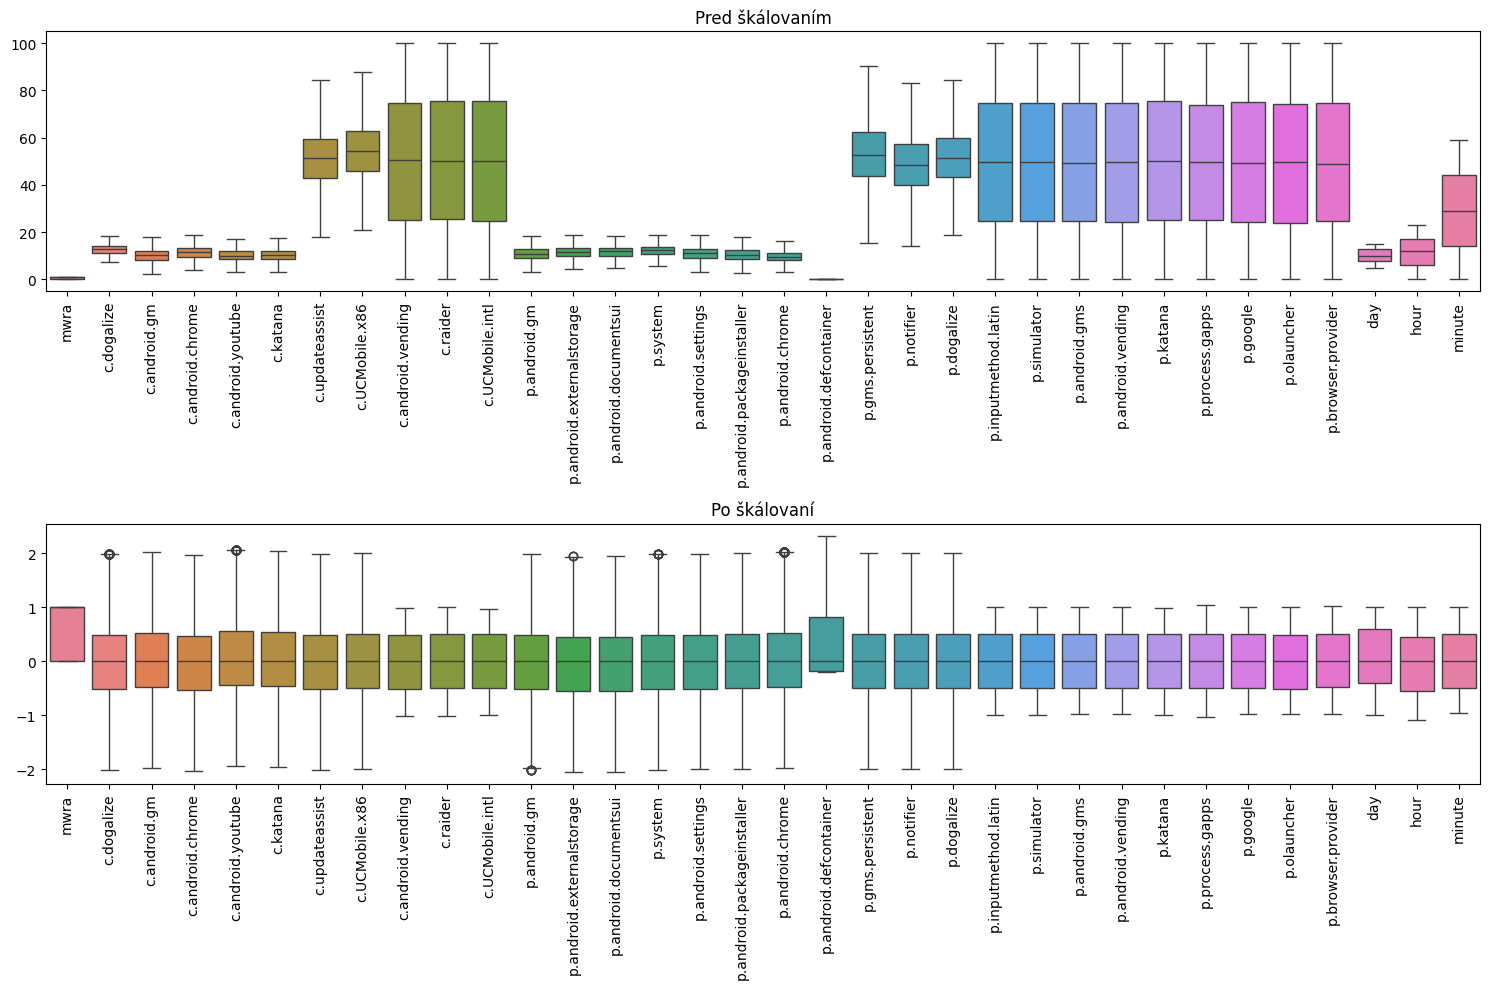

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

sns.boxplot(data=train_df, ax=axes[0])
axes[0].set_title("Pred škálovaním")
axes[0].tick_params(axis='x', rotation=90)

sns.boxplot(data=robust_scaled, ax=axes[1])
axes[1].set_title("Po škálovaní")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

**Graf Pred škálovaním**: Zobrazuje rozdelenie atribútov v pôvodných údajoch bez aplikácie škálovania. Z grafu môžeme vidieť, že niektoré atribúty majú široký rozsah hodnôt a tiež to, že rôzne atribúty majú rôzne rozsahy hodnôt.

**Graf Po škálovaní**: Zobrazuje efekty RobustScaler, ktorý je robustný voči outlierom. Vidíme, že rozdelenie hodnôt je menej ovplyvnené extrémnymi hodnotami, čím sa zabezpečuje lepšia stabilita modelov.

#### Scaling - porovnanie

- **StandardScaler** transformuje hodnoty tak, aby mali strednú hodnotu 0 a smerodajnú odchýlku 1. Táto škálovacia metóda je vhodná pre modely, ktoré predpokladajú normálne rozdelenie dát, pretože štandardizuje atribúty tak, aby boli symetricky rozložené okolo nuly.
- **RobustScaler** je odolnejší voči outlierom a lepšie zachováva základné rozdelenie atribútov, čo je výhodné v prípade, že údaje obsahujú extrémne hodnoty.

Keďže pre účely machine learningu potrebujeme, aby dáta mali čo najnormálnejšie rozdelenia, budeme ďalej používať **StandardScaler**.

### Transformers

#### Power Transformers

In [75]:
from numpy import exp
from numpy.random import randn
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot

train_df_transform = train_df.drop(columns=["mwra"])

power = PowerTransformer(method='yeo-johnson', standardize=True)
data_power_transformer = power.fit_transform(train_df_transform)

data_power_transformer = pd.DataFrame(data_power_transformer, columns=train_df_transform.columns)

data_power_transformer.insert(0, "mwra", train_df["mwra"].values)

data_power_transformer.head()

mwra  c.dogalize  c.android.gm  c.android.chrome  c.android.youtube  \
0   1.0   -0.456580      0.640132          0.476060          -1.853184   
1   1.0    0.162127     -0.113127         -0.450504          -1.242163   
2   1.0    1.045580      1.546749          0.651654          -0.195729   
3   0.0    0.735950      0.817497         -2.129782          -1.493983   
4   0.0    0.523889      1.260455         -1.644458          -0.888485   

   c.katana  c.updateassist  c.UCMobile.x86  c.android.vending  c.raider  ...  \
0  0.283569        0.634201       -1.642272          -0.796035  0.997494  ...   
1  0.123396        1.151108        1.862694           0.736167  1.527356  ...   
2 -0.335637       -0.671606       -0.689876          -1.710206  0.241645  ...   
3  0.461561        1.136713        0.212510           0.639006  1.111594  ...   
4  1.144015       -0.797045       -0.822974          -1.853190  0.155809  ...   

   p.android.gms  p.android.vending  p.katana  p.process.gapps  p.google  \
0       0.046024           0.019580  0.634903        -0.023178 -0.847589   
1      -1.363525          -0.630147 -1.542552        -0.651571  1.399848   
2       0.122584           1.015743  1.054388        -1.138857 -1.202141   
3      -1.295443          -1.336014  0.358350         0.049417 -0.712450   
4       0.755828          -1.438851 -1.715049         0.818455 -1.190587   

   p.olauncher  p.browser.provider       day      hour    minute  
0    -1.311591           -0.181975  0.959521 -0.745207  0.947408  
1    -1.517092            0.188441  0.323177 -1.665597  0.076891  
2     1.224141            0.268903  0.644085 -0.137552 -0.756676  
3    -0.861572            1.064724 -0.678645 -1.081633  1.278075  
4     0.157578            0.671449  0.959521 -0.745207  0.021783  

[5 rows x 34 columns]

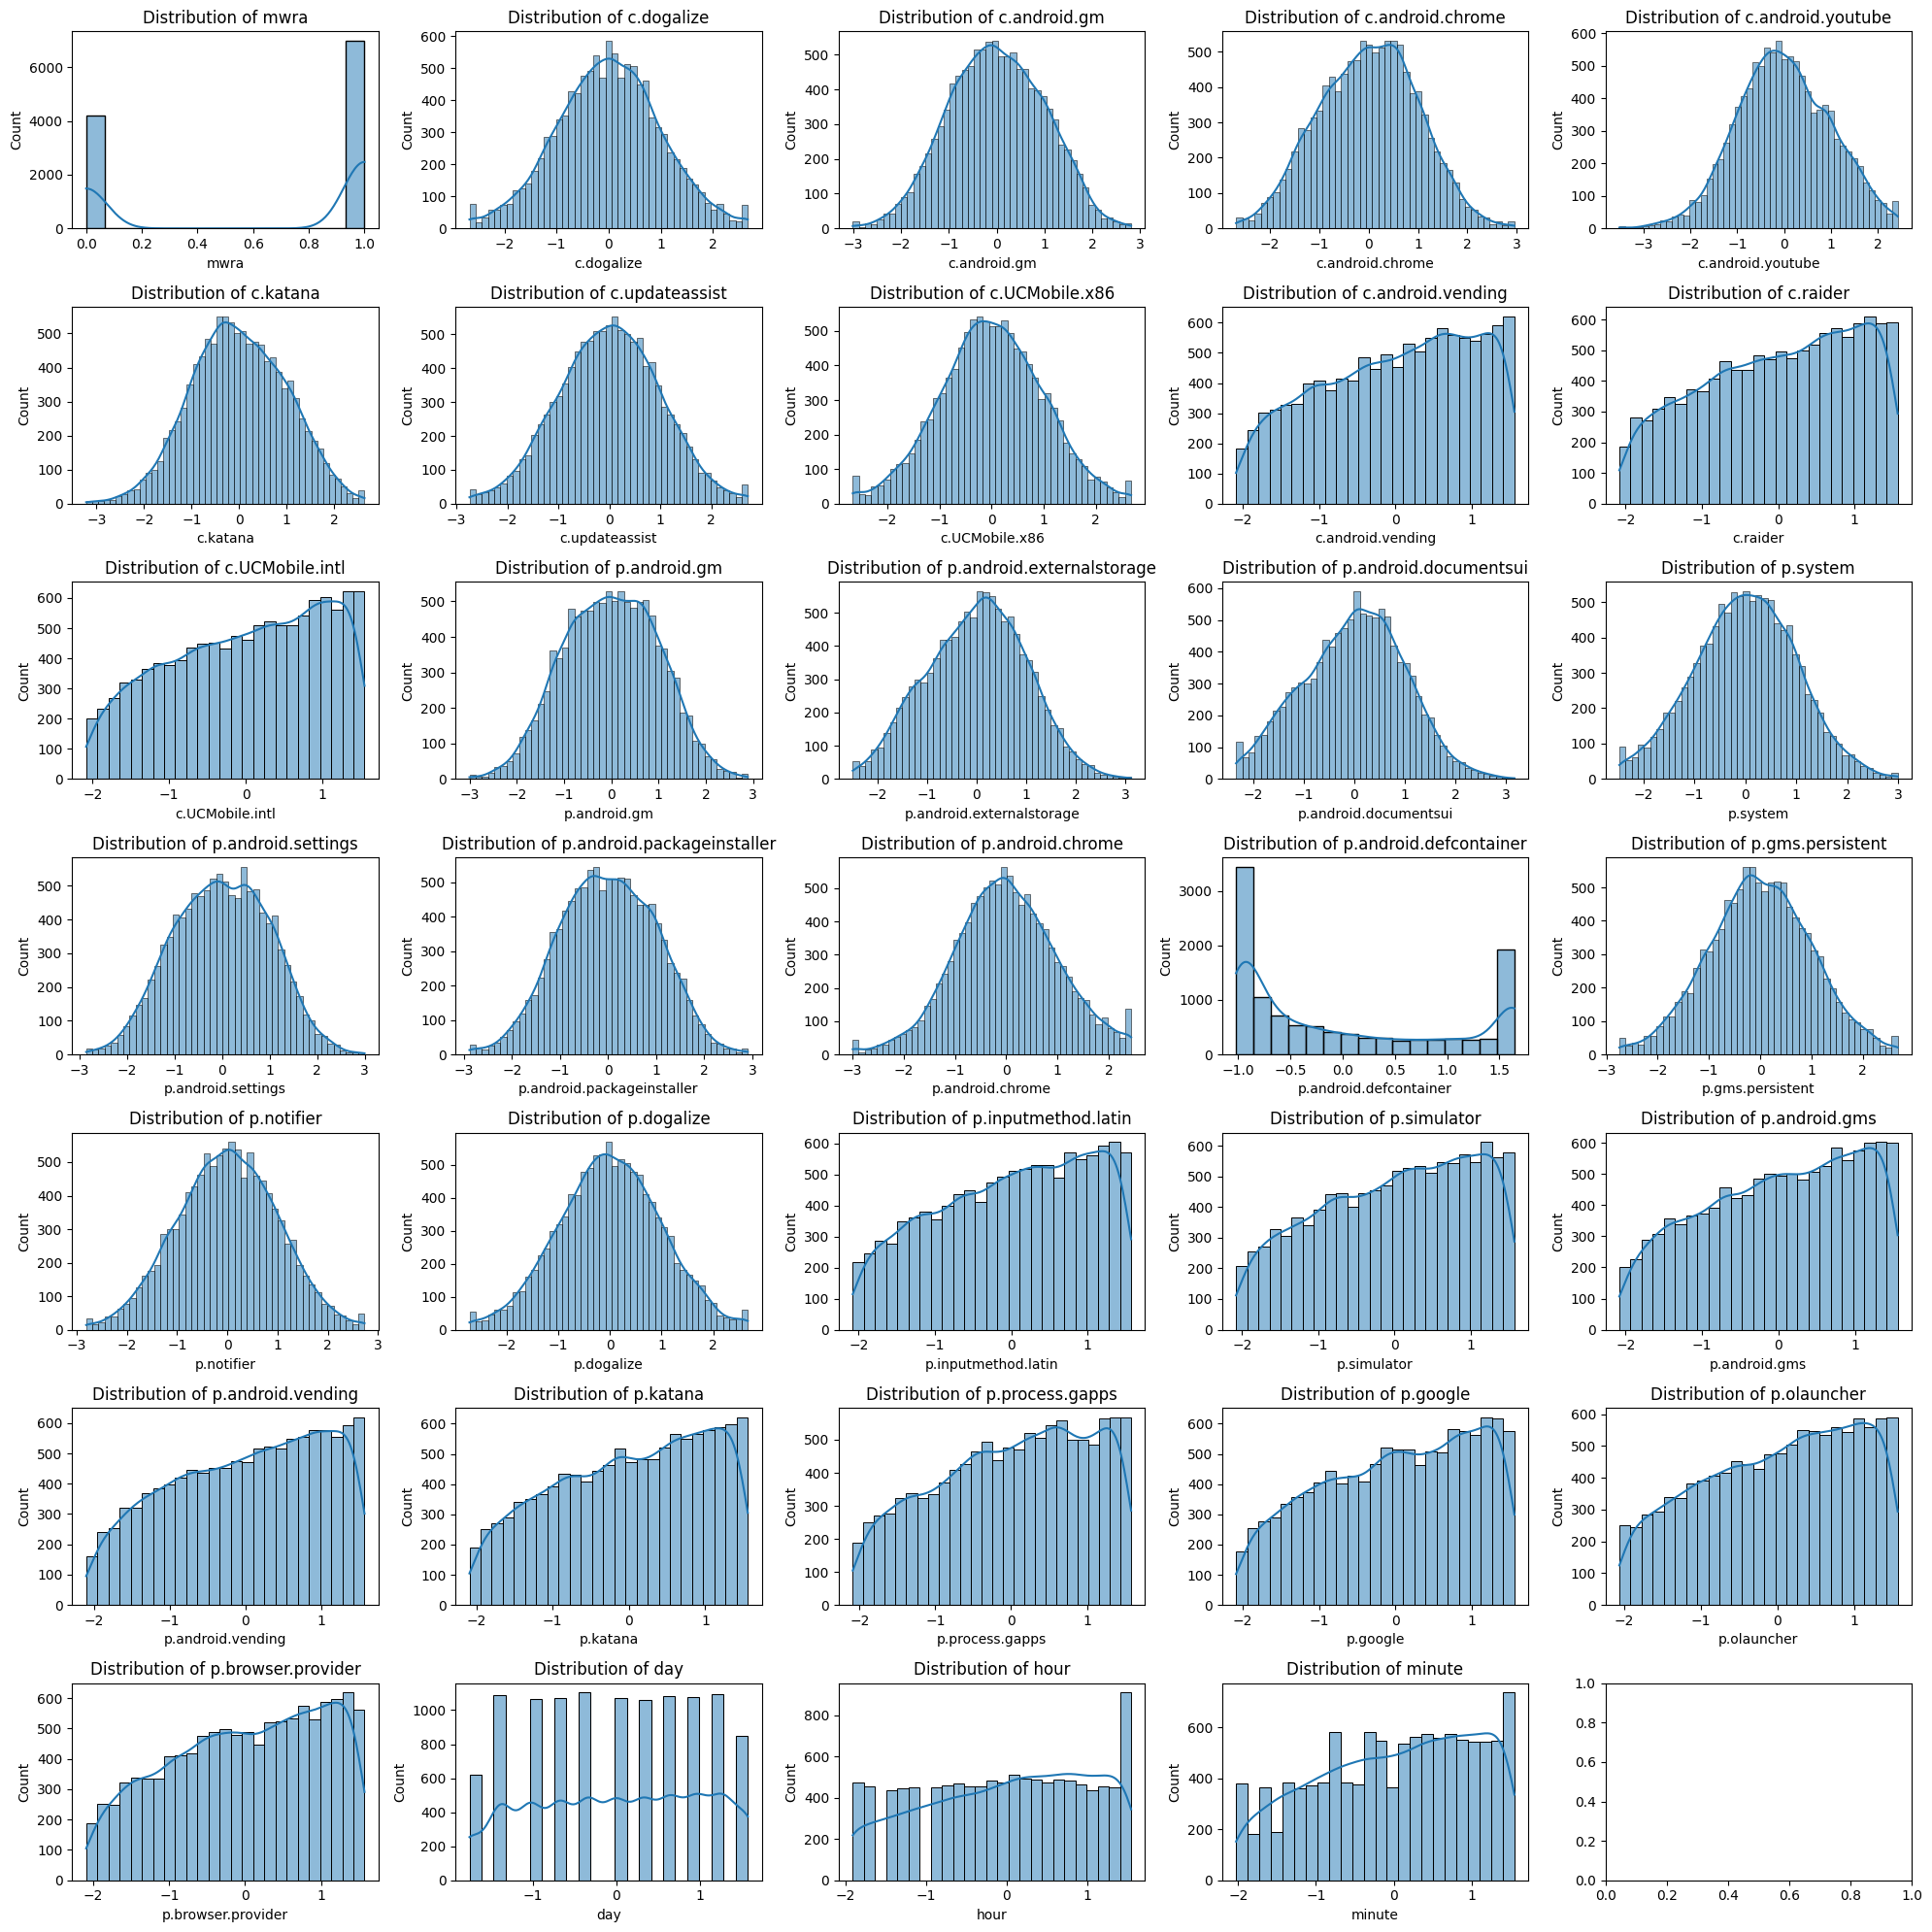

In [76]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(data_power_transformer.columns):
    sns.histplot(data_power_transformer[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

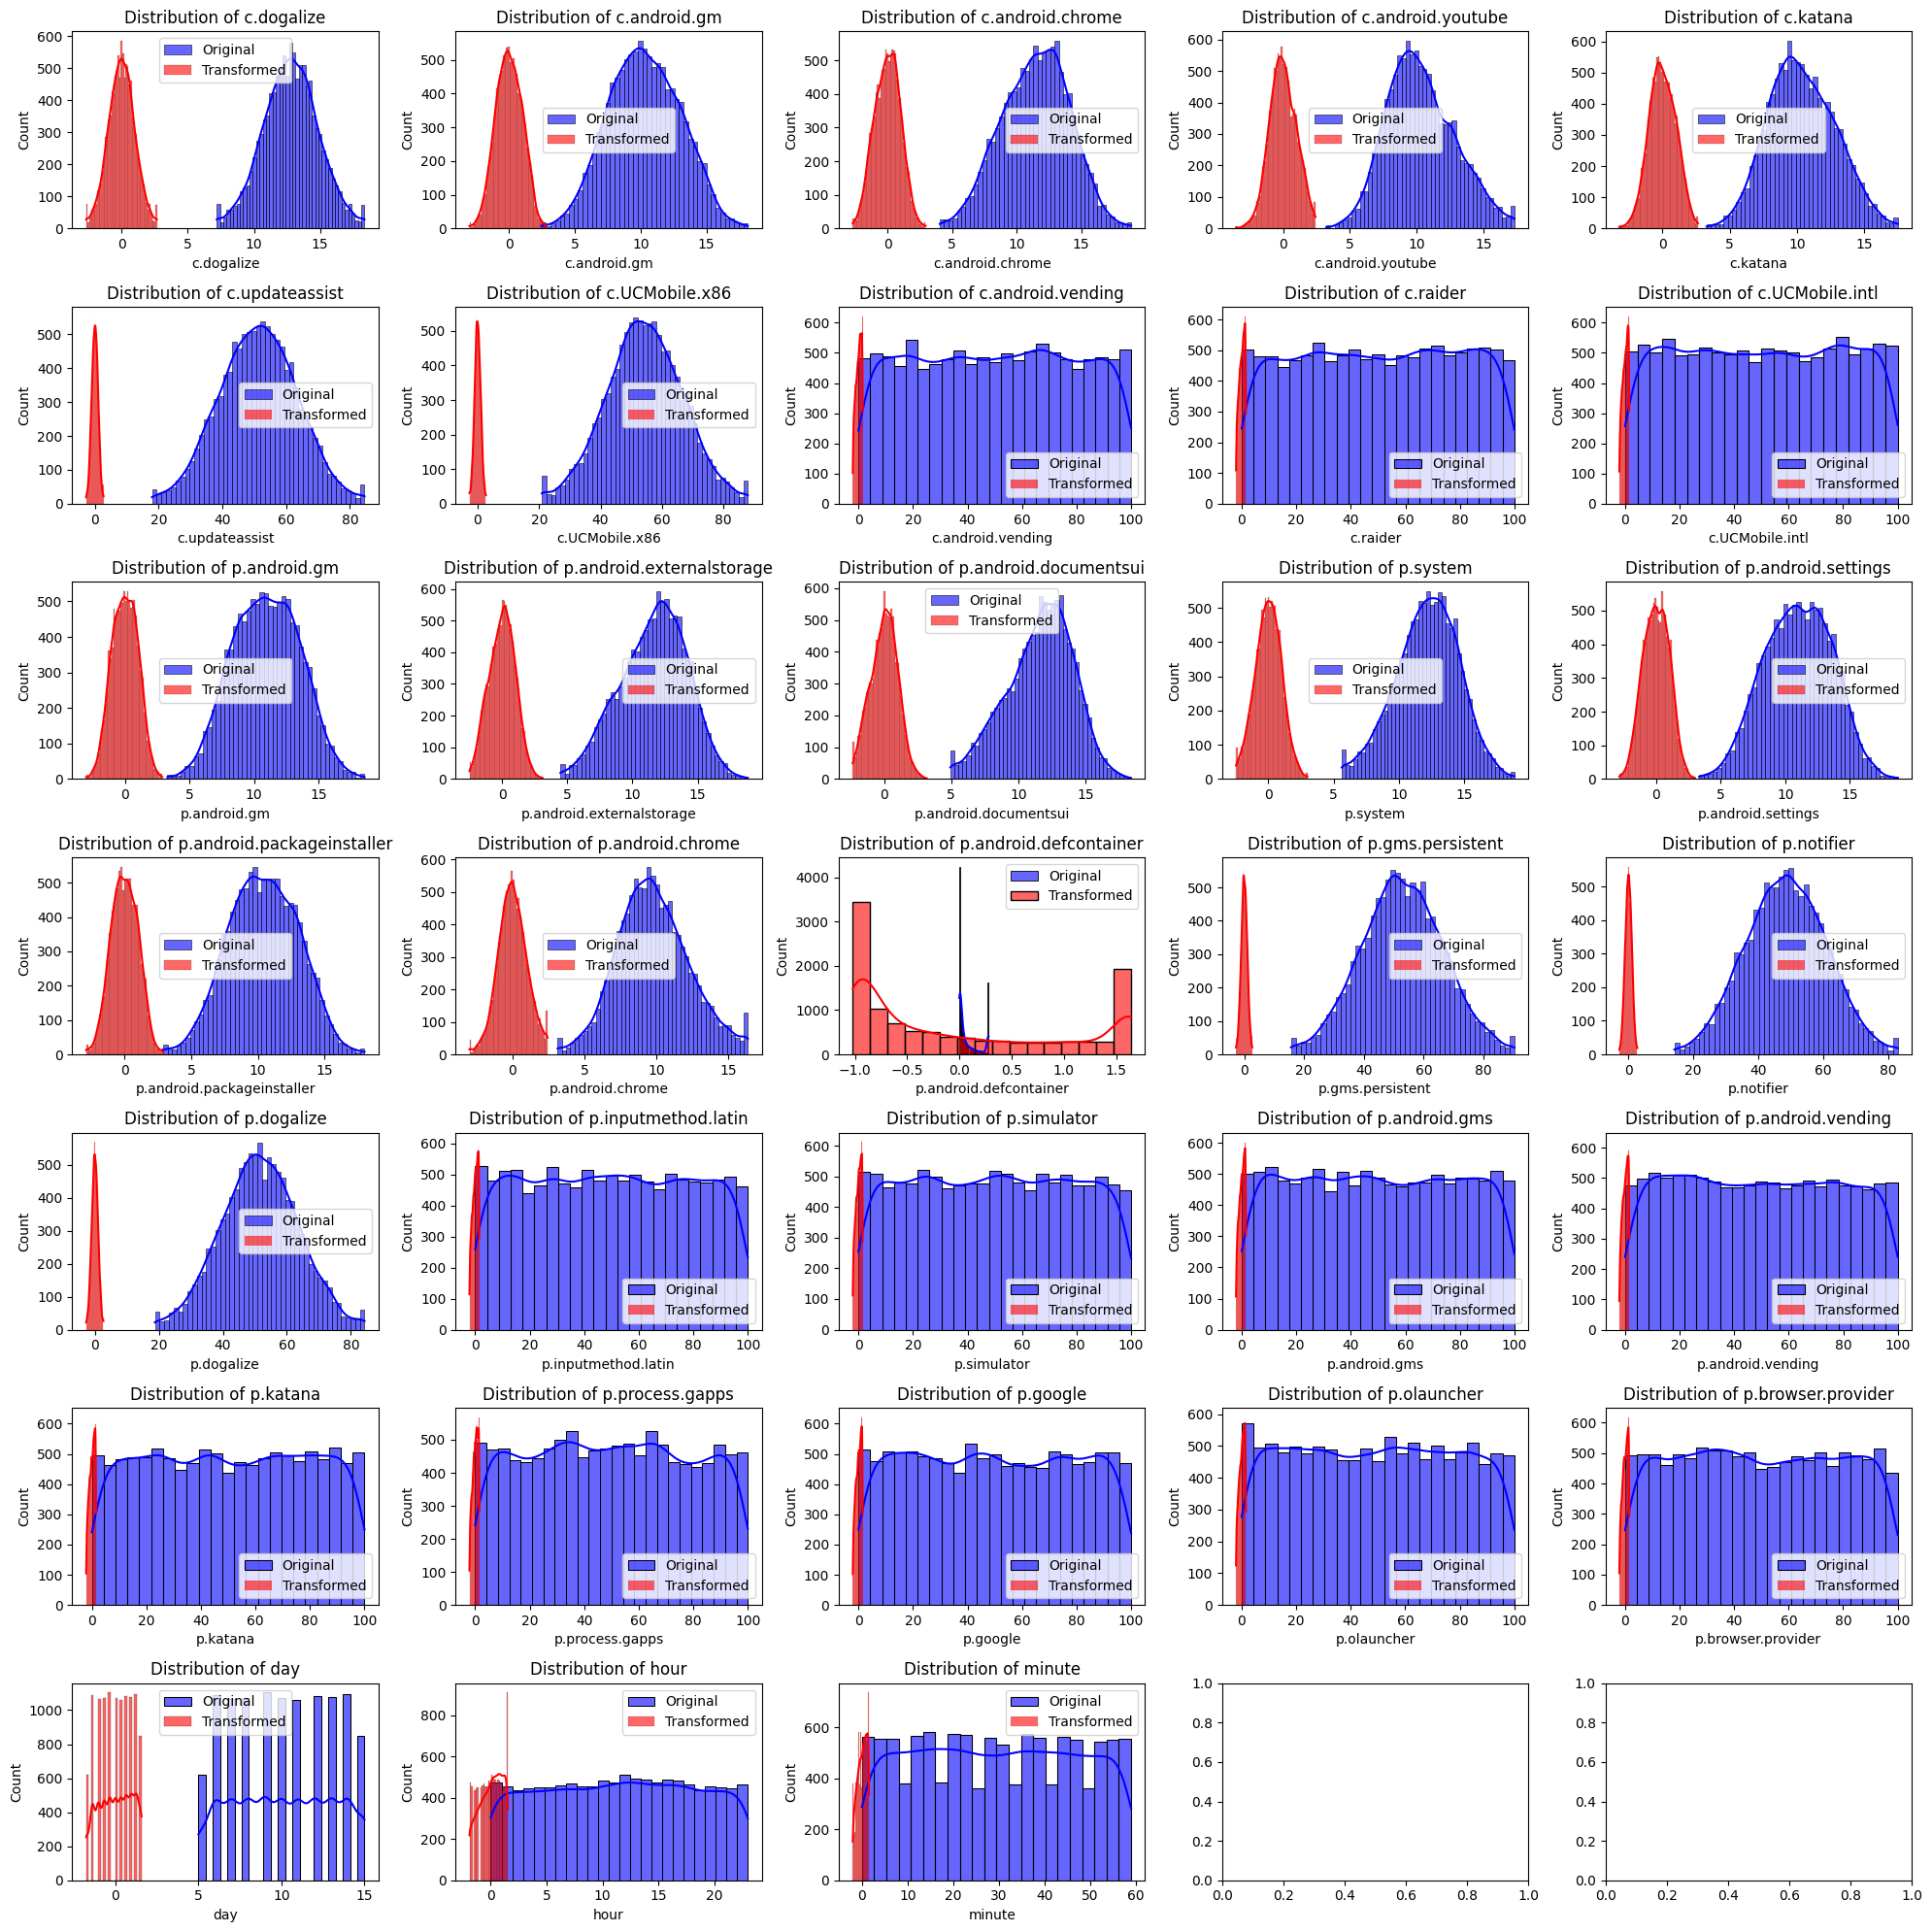

In [77]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(train_df_transform.columns):
    sns.histplot(train_df_transform[col], kde=True, ax=axes[i], color='blue', label='Original', alpha=0.6)
    sns.histplot(data_power_transformer[col], kde=True, ax=axes[i], color='red', label='Transformed', alpha=0.6)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].legend()

plt.tight_layout()
plt.show()

Grafy vyššie zobrazujú rozdelenie atribútov po aplikovaní PowerTransformer metódy Yeo-Johnson. Môžeme si všimnúť, že distribúcie hodnôt sú viac symetrické a bližšie k normálnemu rozdeleniu, čo zlepšuje ich spracovanie v modeloch strojového učenia.

#### Quantile Transformer

In [78]:
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import QuantileTransformer

train_df_transform = train_df.drop(columns=["mwra"])

qt = QuantileTransformer(n_quantiles=10, random_state=0)
data_quantile_transformer = qt.fit_transform(train_df_transform)

data_quantile_transformer = pd.DataFrame(data_quantile_transformer, columns=train_df_transform.columns)

data_quantile_transformer.insert(0, "mwra", train_df["mwra"].values)

data_quantile_transformer.head()

mwra  c.dogalize  c.android.gm  c.android.chrome  c.android.youtube  \
0   1.0    0.323307      0.722596          0.663923           0.075351   
1   1.0    0.566274      0.462585          0.330474           0.108719   
2   1.0    0.847999      0.909418          0.730603           0.435764   
3   0.0    0.775178      0.778559          0.045358           0.094584   
4   0.0    0.700699      0.889177          0.083493           0.192921   

   c.katana  c.updateassist  c.UCMobile.x86  c.android.vending  c.raider  ...  \
0  0.612657        0.727979        0.079196           0.251764  0.798267  ...   
1  0.557986        0.866781        0.937968           0.707477  0.987097  ...   
2  0.384137        0.253781        0.245731           0.053096  0.546594  ...   
3  0.672987        0.863295        0.589588           0.673835  0.838823  ...   
4  0.861337        0.215591        0.207216           0.030134  0.520450  ...   

   p.android.gms  p.android.vending  p.katana  p.process.gapps  p.google  \
0       0.485550           0.477905  0.668883         0.468528  0.238315   
1       0.122063           0.296019  0.084006         0.285592  0.940280   
2       0.509393           0.800090  0.813261         0.168406  0.152631   
3       0.135985           0.122636  0.580836         0.490504  0.272479   
4       0.710039           0.101426  0.052789         0.738355  0.155273   

   p.olauncher  p.browser.provider       day      hour    minute  
0     0.132159            0.421735  0.777778  0.259259  0.777778  
1     0.089165            0.529127  0.555556  0.055556  0.492063  
2     0.877885            0.552922  0.666667  0.444444  0.259259  
3     0.236350            0.815677  0.333333  0.185185  0.888889  
4     0.517337            0.682341  0.777778  0.259259  0.476190  

[5 rows x 34 columns]

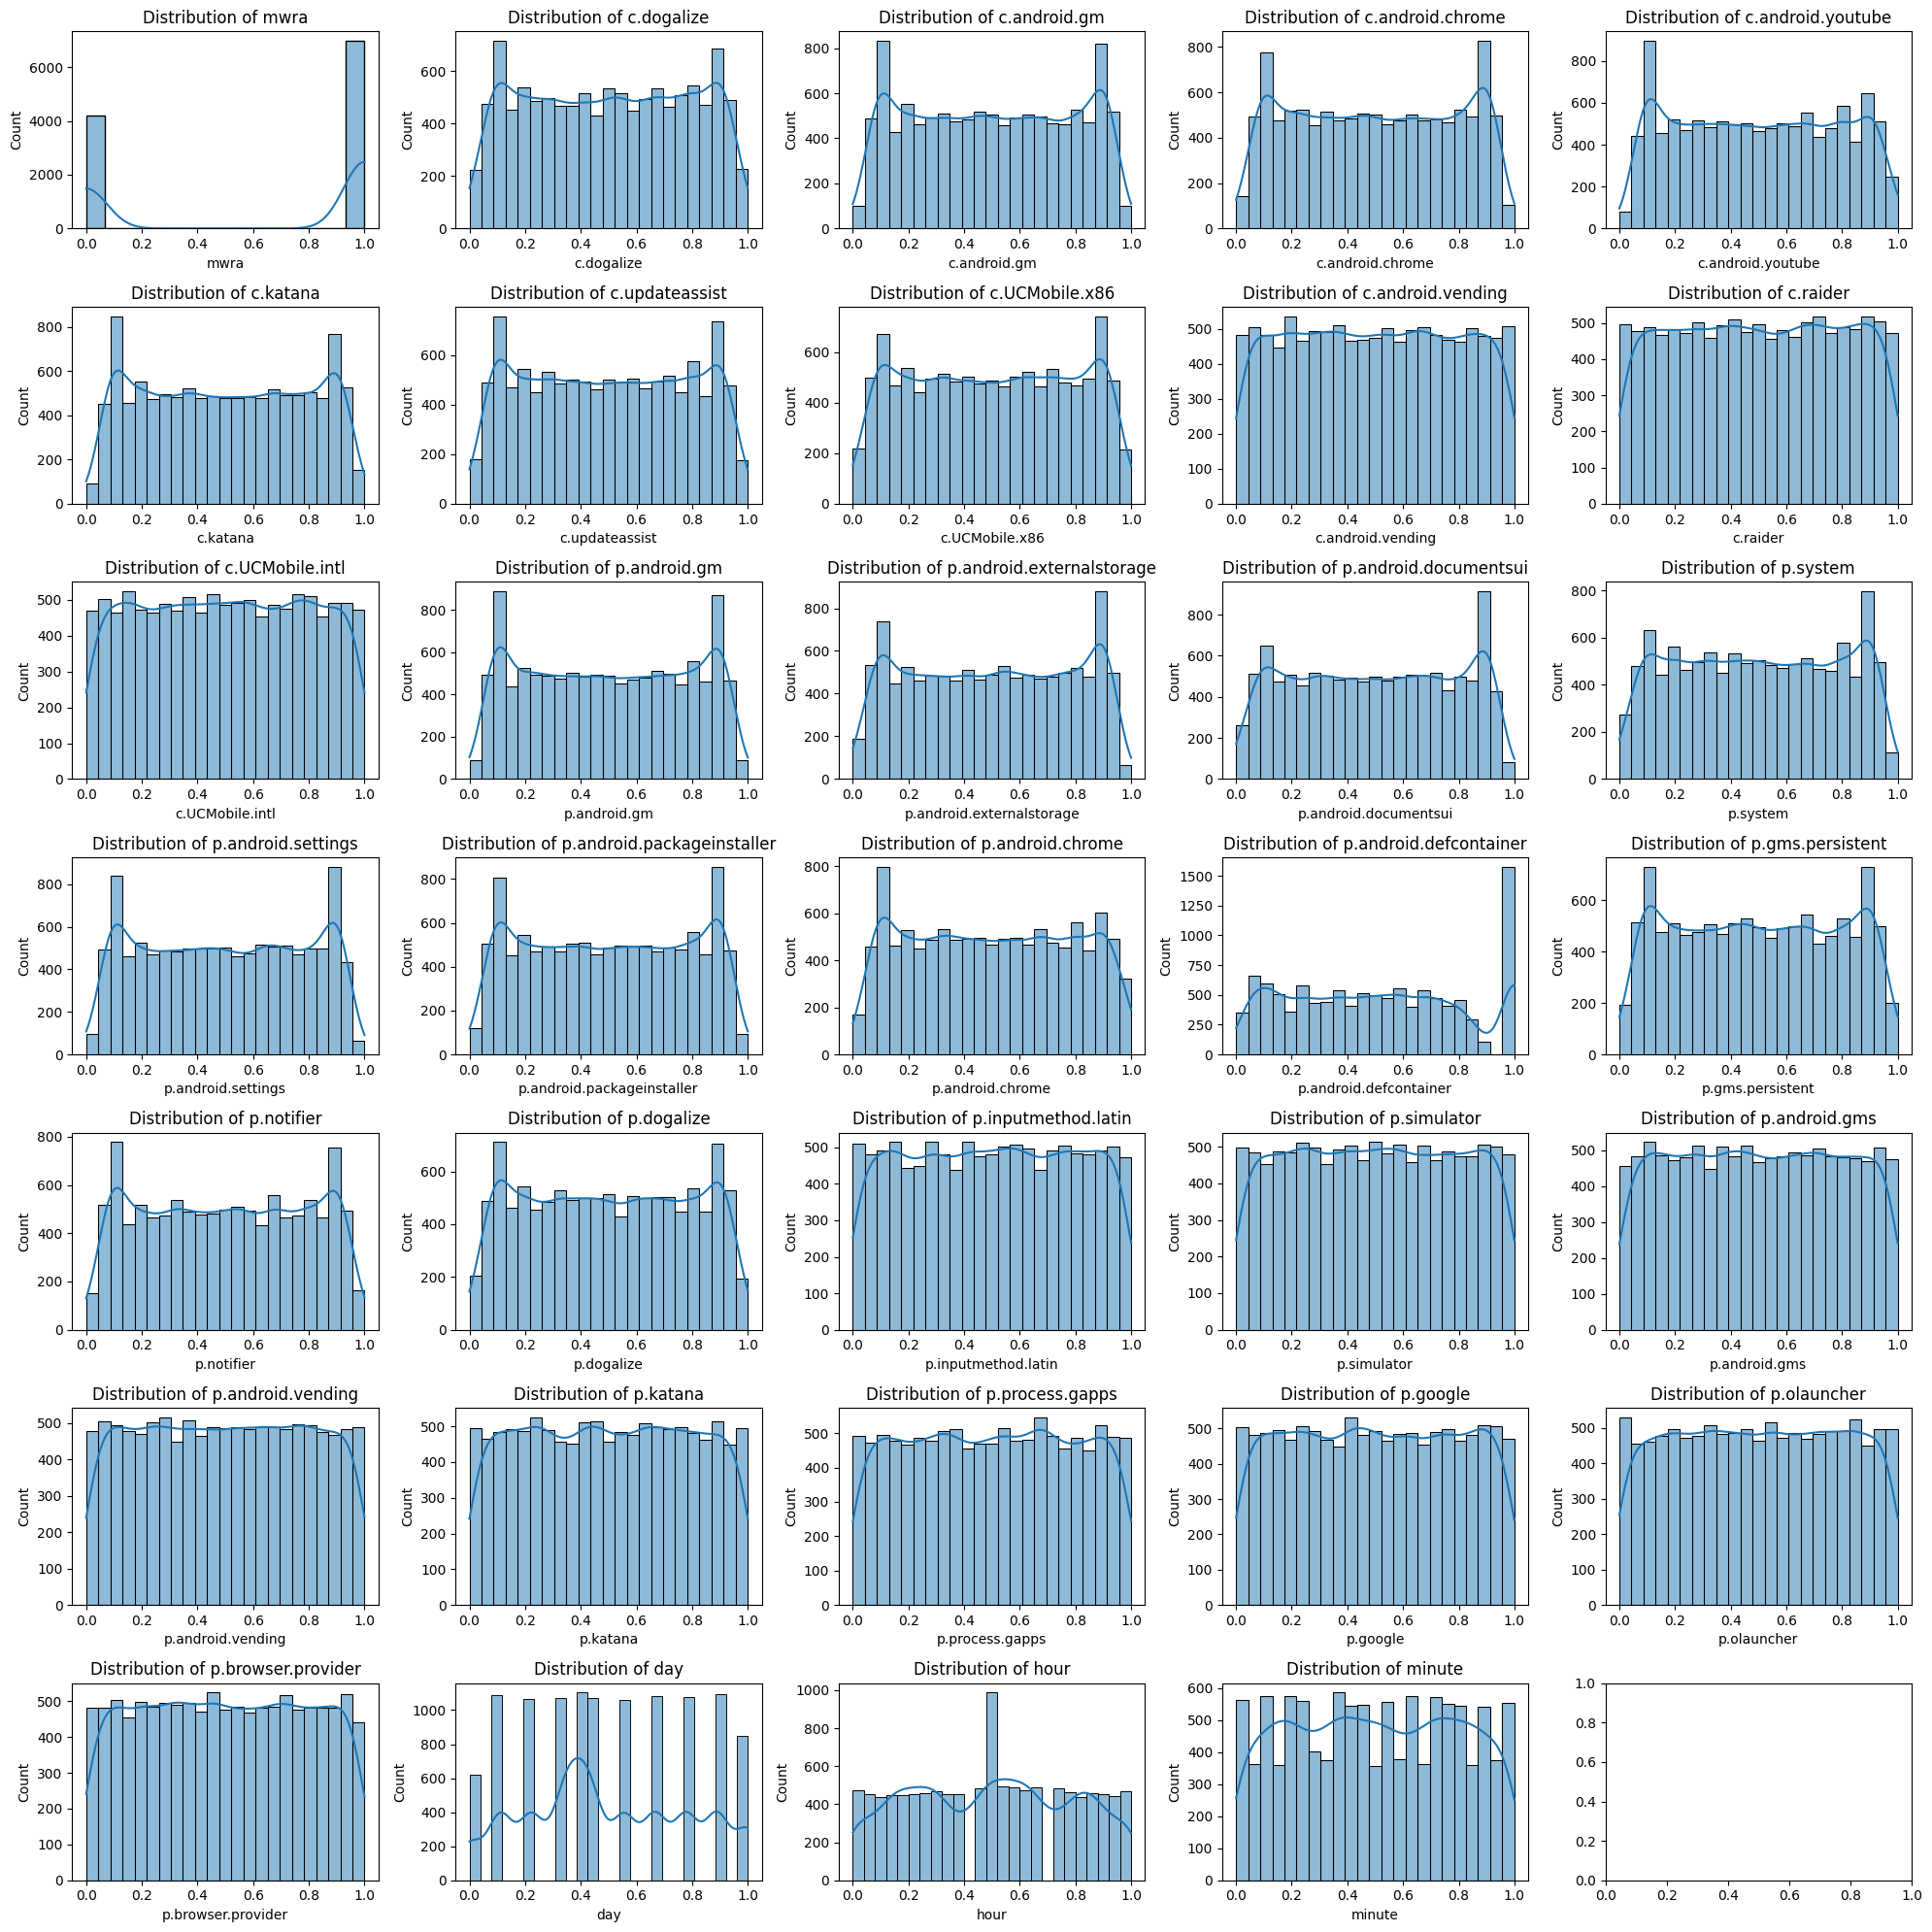

In [79]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(data_quantile_transformer.columns):
    sns.histplot(data_quantile_transformer[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

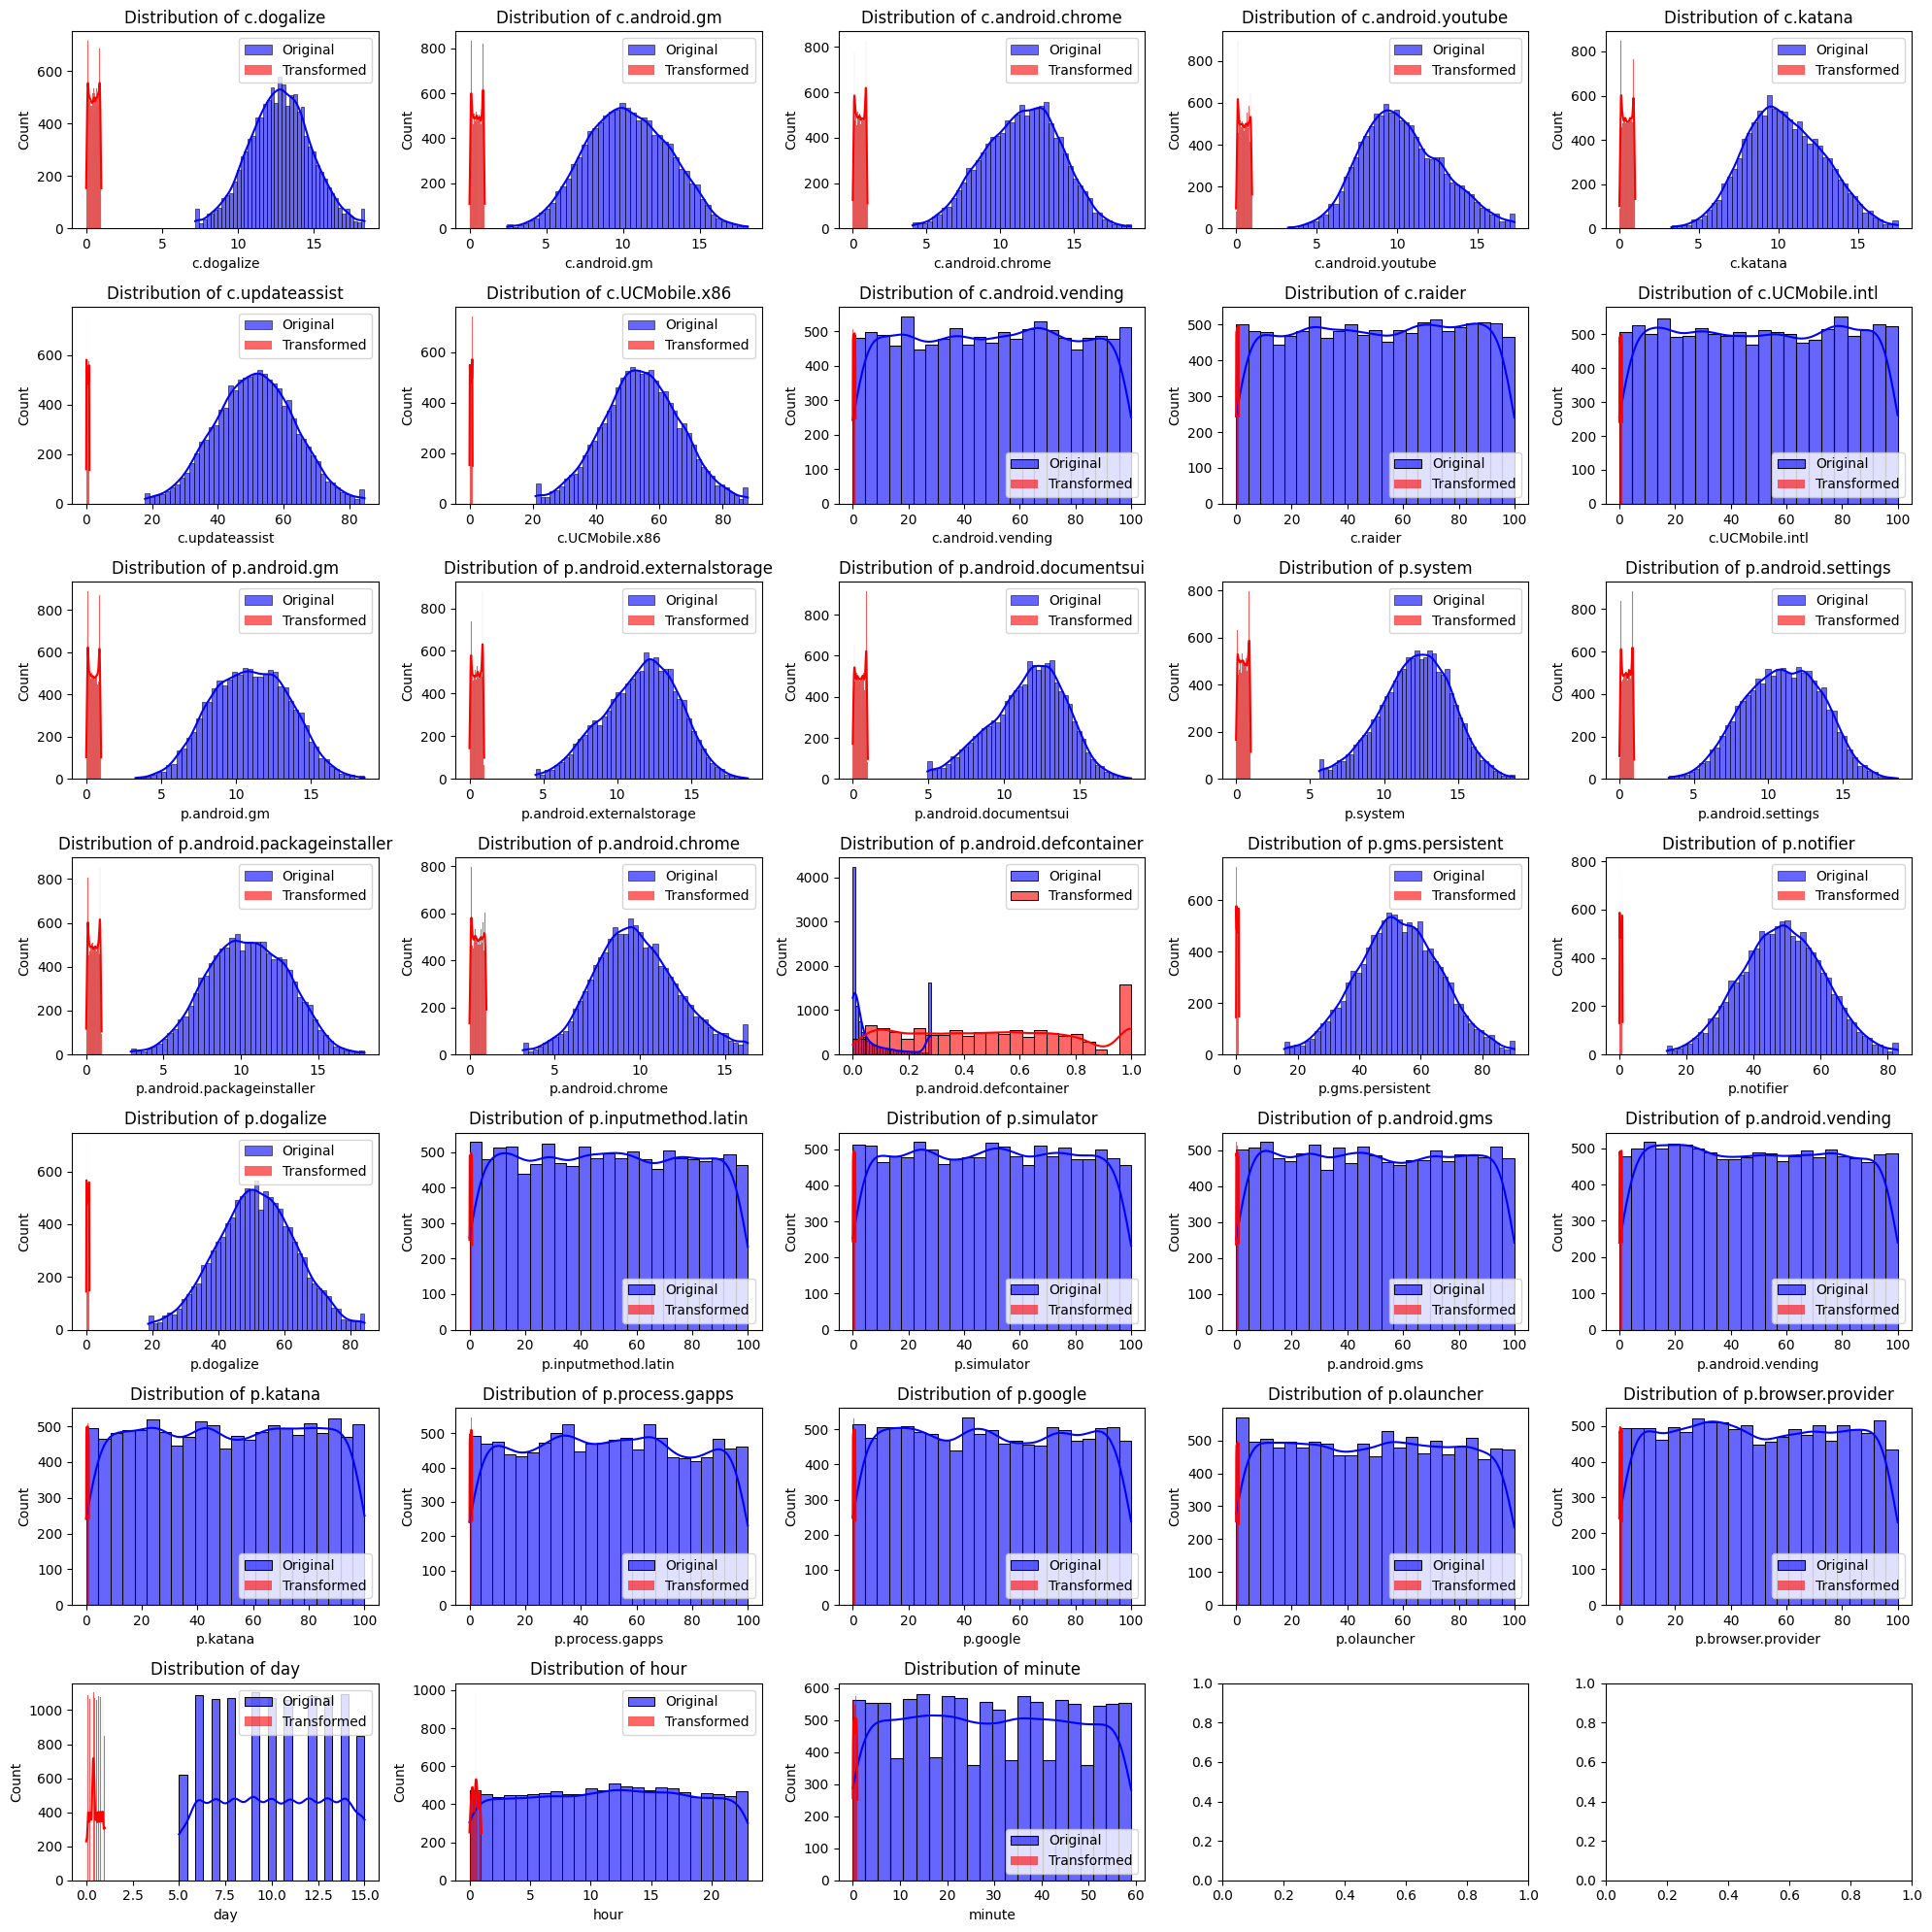

In [80]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(train_df_transform.columns):
    sns.histplot(train_df_transform[col], kde=True, ax=axes[i], color='blue', label='Original', alpha=0.6)
    sns.histplot(data_quantile_transformer[col], kde=True, ax=axes[i], color='red', label='Transformed', alpha=0.6)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].legend()

plt.tight_layout()
plt.show()

Grafy vyššie zobrazujú distribúcie atribútov po použití Quantile Transformer. Môžeme si všimnúť, že transformované údaje sú prerozdelené tak, aby mali rovnomerné rozdelenie, čo môže byť veľmi užitočné pri aplikácii niektorých algoritmov strojového učenia.

#### Transformers - porovnanie

- **Power Transformer (Yeo-Johnson)** efektívne zlepšuje normalitu rozdelenia atribútov a umožňuje transformácie aj pre záporné hodnoty.
- **Quantile Transformer** transformuje atribúty tak, aby sa prispôsobili rovnomernému rozdeleniu. Je robustný voči outlierom a môže byť užitočný, keď je cieľom zabezpečiť presné rozdelenie.

Keďže pre účely machine learningu potrebujeme, aby dáta mali čo najnormálnejšie rozdelenia, budeme ďalej používať **Power Transformer (Yeo-Johnson)**.

## D
Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

V rámci predspracovania dát sme prešli niekoľkými krokmi:
- Odstránili zbytočné atribúty, aby sme zjednodušili dataset
- Identifikovali a náhradili sme vychýlené hodnoty (outliers) hraničnými hodnotami
- Škálovanie dát: použili sme StandardScaler a RobustScaler. Rozhodli sme sa, že budeme ďalej používať StandardScaler, kvôli tomu, že potrebujeme normálne distribúcie dát.
- Transformácia dát: použili sme Power Transformer a Quantile Transformer. Rozhodli sme sa, že budeme ďalej používať Power Transformer, kvôli tomu, že potrebujeme normálne distribúcie dát.

Zhodnotenie: Celkový proces predspracovania dát zlepšil kvalitu a pripravenosť datasetu pre ďalšie kroky v strojovom učení.

# 2.2 Výber atribútov pre strojové učenie

## A
Zistite, ktoré atribúty (features) vo vašich dátach pre ML sú informatívne k predikovanej premennej (minimálne 3 techniky s porovnaním medzi sebou).

Najskôr si trénovací dataset upravíme vybranými metódami z predošlej časti:

In [81]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
scaler = StandardScaler()
transformer = PowerTransformer(method='yeo-johnson')

scaled_data = scaler.fit_transform(train_df.drop(columns="mwra"))
transformed_data = transformer.fit_transform(scaled_data)

transformed_df = pd.DataFrame(transformed_data, columns=train_df.drop(columns="mwra").columns)
transformed_df = pd.concat([transformed_df, train_df["mwra"].reset_index(drop=True)], axis=1)

### SelectKBest s F-testom pre klasifikáciu

In [82]:
from sklearn.feature_selection import f_classif, SelectKBest

X = transformed_df.drop(columns="mwra")
y = transformed_df["mwra"]

anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(X, y)
anova_scores = anova_selector.scores_
selected_columns = X.columns

anova_features_scores = sorted(zip(selected_columns, anova_scores), key=lambda x: x[1], reverse=True)

for feature, score in anova_features_scores:
    print(f"Feature: {feature:28} Score: {score}")


Feature: c.katana                     Score: 5145.373094547513
Feature: c.android.chrome             Score: 4979.479872344019
Feature: p.android.packageinstaller   Score: 4700.840859694603
Feature: p.system                     Score: 1027.552545481326
Feature: p.android.chrome             Score: 1002.3371852494698
Feature: c.android.youtube            Score: 975.793793206565
Feature: p.android.externalstorage    Score: 965.8916413462977
Feature: p.android.documentsui        Score: 941.0930950457282
Feature: c.android.gm                 Score: 830.2298642914669
Feature: p.android.defcontainer       Score: 736.6678178276051
Feature: p.notifier                   Score: 2.8545974669998615
Feature: c.UCMobile.x86               Score: 2.806680196904368
Feature: p.gms.persistent             Score: 2.7990454146320514
Feature: c.raider                     Score: 1.5514550043513833
Feature: day                          Score: 1.2573623350493928
Feature: c.android.vending            Score: 1.1503

Tu sme použili filter metódu, ktorá vyhodnocuje jednotlivé príznaky na základe ich štatistickej dôležitosti pre cieľovú premennú. V tomto prípade F-test skúma, do akej miery sú hodnoty jednotlivých príznakov odlišné medzi kategóriami cieľovej premennej mwra.

Výsledky ukazujú, že medzi najvýznamnejšie features patria:
- c.katana:                   5145.37       
- c.android.chrome:           4979.48       
- p.android.packageinstaller: 4700.84       
- p.system:                   1027.55     
- p.android.chrome:           1002.34  
- c.android.youtube:          975.79   
- p.android.externalstorage:  965.89
- p.android.documentsui:      941.09
- c.android.gm:               830.23
- p.android.defcontainer:      736.67  

### Recursive Feature Elimination s Random Forest Regressorom

In [83]:
from sklearn.ensemble import RandomForestRegressor

X = transformed_df.drop(columns="mwra")
y = transformed_df["mwra"]

rf_model = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X, y)

feature_importances = rf_model.feature_importances_
all_columns = X.columns

all_features_with_scores = zip(all_columns, feature_importances)
sorted_features = sorted(all_features_with_scores, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_features:
    print(f"Feature: {feature:28} Importance: {importance}")

Feature: c.katana                     Importance: 0.40824190476549294
Feature: c.android.chrome             Importance: 0.18866040667497588
Feature: p.android.packageinstaller   Importance: 0.172860691964232
Feature: p.system                     Importance: 0.05454634728610449
Feature: p.android.externalstorage    Importance: 0.02208818494683545
Feature: c.android.youtube            Importance: 0.014842622995502871
Feature: p.android.defcontainer       Importance: 0.014427562429092395
Feature: p.android.documentsui        Importance: 0.013838411764765121
Feature: c.android.gm                 Importance: 0.013325895281872164
Feature: p.android.chrome             Importance: 0.01250183477929532
Feature: c.dogalize                   Importance: 0.008647105970657267
Feature: p.android.settings           Importance: 0.0068644975622803
Feature: p.android.gm                 Importance: 0.005843480515040645
Feature: c.raider                     Importance: 0.005084855483738253
Feature: p.proce

Tu sme použili metódu Recursive Feature Elimination s modelom Random Forest Regressor, ktorá patrí medzi wrapper metódy. Táto metóda iteratívne hodnotí význam príznakov a postupne eliminuje tie menej dôležité, až kým neostane požadovaný počet príznakov. Výsledky ukazujú, že medzi najvýznamnejšie príznaky patria:

- c.katana: 0.40764
- c.android.chrome: 0.18938
- p.android.packageinstaller: 0.17316
- p.system: 0.05319
- p.android.externalstorage: 0.02083
- p.android.defcontainer: 0.01550
- p.android.documentsui: 0.01448
- c.android.youtube: 0.01414
- c.android.gm: 0.01367
- p.android.chrome: 0.01207

### SelectFromModel s Logistic Regression

In [84]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

X = transformed_df.drop(columns="mwra")
y = transformed_df["mwra"]

sfm_selector = SelectFromModel(estimator=LogisticRegression(max_iter=1000)).fit(X, y)

feature_names = X.columns
feature_coefficients = np.abs(sfm_selector.estimator_.coef_[0])

all_features_with_scores = zip(feature_names, feature_coefficients)
sorted_features = sorted(all_features_with_scores, key=lambda x: x[1], reverse=True)

for feature, score in sorted_features:
    print(f"Feature: {feature:28} Score: {score}")

Feature: p.android.packageinstaller   Score: 1.0698337110561162
Feature: c.katana                     Score: 1.0129395111434747
Feature: p.android.externalstorage    Score: 0.9072571145646434
Feature: p.android.documentsui        Score: 0.7568799249312921
Feature: p.android.chrome             Score: 0.6623896282904269
Feature: p.system                     Score: 0.5573421814420492
Feature: c.android.gm                 Score: 0.5446673175672985
Feature: c.android.youtube            Score: 0.45749472621374493
Feature: c.android.chrome             Score: 0.3227845890743512
Feature: p.android.defcontainer       Score: 0.30639218372479193
Feature: c.dogalize                   Score: 0.2962981076090484
Feature: p.android.gm                 Score: 0.1941630236306677
Feature: p.android.settings           Score: 0.08560916403487945
Feature: p.simulator                  Score: 0.0564668853890959
Feature: p.process.gapps              Score: 0.04937819235152684
Feature: p.inputmethod.latin        

Tu sme použili metódu SelectFromModel s modelom Logistic Regression, ktorá patrí medzi embedded metódy. Tento prístup vyberá príznaky na základe koeficientov z logistickej regresie, čo umožňuje priamo hodnotiť význam príznakov pre klasifikačný model. Výsledky ukazujú, že medzi najvýznamnejšie príznaky patria:

- p.android.packageinstaller: 1.0698
- c.katana: 1.0129
- p.android.externalstorage: 0.9072
- p.android.documentsui: 0.7568
- p.android.chrome: 0.6623
- p.system: 0.5573
- c.android.gm: 0.5446
- c.android.youtube: 0.4574
- c.android.chrome: 0.3227
- p.android.defcontainer: 0.3063
- c.dogalize: 0.2962
- p.android.gm: 0.1941

## B
Zoraďte zistené atribúty v poradí podľa dôležitosti.

Ako môžme vidieť, použité metódy sa celkom zhodujú v tom, ktoré features sú najdôležitejšie, v top 10 majú veľa rovnakých atribútov. Atribúty sme sa podľa ich dôležitostí v jednotlicých technikách rozhodli zoradiť následovne:

- 1 - c.katana - V prvých dvoch metódach sa umiestnil na 1. mieste, v tretej na 2.
- 2 - p.android.packageinstaller - V prvých dvoch metódach sa umiestnil na 3. mieste, v tretej na 1.
- 3 - c.android.chrome - V prvých dvoch metódach sa umiestnil na 2. mieste, ale v tretej až na 9.
- 4 - p.system - V prvých dvoch metódach sa umiestnil na 4. mieste, v tretej na 7.
- 5 - p.android.externalstorage - Umiestnil sa na 3., 5. a 7. mieste.
- 6 - p.android.chrome - V prvej a tretej metóde sa umiestnil na 5. mieste, ale v druhej až na 10.
- 7 - p.android.documentsui - Umiestnil sa na 4., 7. a 8. mieste.
- 8 - c.android.youtube - V druhej a tretej metóde sa umiestnil na 8. mieste, v prvej na 6.
- 9 - c.android.gm - V prvých dvoch metódach sa umiestnil na 9. mieste, v tretej na 6.
- 10 - p.android.defcontainer - V prvej a tretej metóde sa umiestnil na 10. mieste, v druhej na 6.

Ďalej sme na základe dôležitostí atribútov v jednotlivých technikách usúdili, že ostatné atribúty nie sú dostatočne informatívne ku predikovanej premennej mwra.

## C
Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

V rámci výberu atribútov pre strojové učenie sme sa rozhodli ďalej pracovať s 10 atribútmi, ktorými sú:
- c.katana
- p.android.packageinstaller
- c.android.chrome
- p.system
- p.android.externalstorage
- p.android.chrome
- p.android.documentsui
- c.android.youtube
- c.android.gm
- p.android.defcontainer

Pre týchto 10 atribútov sme sa rozhodli na základe vyššie vykonaného feature selection, kde sme vyskúšali 3 rôzne metódy, pričom práve tieto atribúty nám vyšli ako najdôležitejšie z hľadiska strojového učenia. Ostatné atribúty nevykazovali dostatočnú dôležitosť, a preto sme sa rozhodli ich z nášho modelu odstrániť a ďalej s nimi nepracovať.

# 2.3 Replikovateľnosť predspracovania

## A
Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny v kontexte strojového učenia.

## B
Využite možnosti sklearn.pipeline


In [85]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin

columns = ['mwra', 'c.katana', 'p.android.packageinstaller', 'c.android.chrome', 'p.system',
          'p.android.externalstorage', 'p.android.chrome', 'p.android.documentsui', 'c.android.youtube',
          'c.android.gm', 'p.android.defcontainer']

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns].copy()

class DateTimeExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['ts'] = pd.to_datetime(X['ts'], errors='raise')
        X['year'] = X['ts'].dt.year
        X['month'] = X['ts'].dt.month
        X['day'] = X['ts'].dt.day
        X['hour'] = X['ts'].dt.hour
        X['minute'] = X['ts'].dt.minute
        X['second'] = X['ts'].dt.second
        X = X.drop(columns=['ts'])
        return X

class DropSingleValueColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_drop = []
        self.columns_to_keep = []

    def fit(self, X, y=None):
        self.columns_to_drop = [col for col in X.columns if X[col].nunique() == 1]
        self.columns_to_keep = [col for col in X.columns if col not in self.columns_to_drop]
        return self

    def transform(self, X):
        X = X.copy()
        X = X.drop(columns=self.columns_to_drop)
        return X

class MeanImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.means = X.select_dtypes(include=[np.number]).mean()
        return self

    def transform(self, X):
        X = X.copy()
        for column in self.means.index:
            X[column] = X[column].fillna(self.means[column])
        return X

class OutlierReplacer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for column in X.select_dtypes(include=[np.number]).columns:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            X[column] = np.where(X[column] < lower_bound, lower_bound, X[column])
            X[column] = np.where(X[column] > upper_bound, upper_bound, X[column])
        return X

class ScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, exclude_column):
        self.exclude_column = exclude_column
        self.scaler = StandardScaler()
        self.transformer = PowerTransformer(method='yeo-johnson')

    def fit(self, X, y=None):
        self.feature_names = X.columns.drop(self.exclude_column)
        self.scaler.fit(X[self.feature_names])
        self.transformer.fit(self.scaler.transform(X[self.feature_names]))
        return self

    def transform(self, X):
        X = X.copy()
        scaled = self.scaler.transform(X[self.feature_names])
        transformed = self.transformer.transform(scaled)

        X_scaled = pd.DataFrame(transformed, columns=self.feature_names, index=X.index)
        X_scaled[self.exclude_column] = X[self.exclude_column].values
        return X_scaled

pipeline = Pipeline([
    ('datetime_extractor', DateTimeExtractor()),
    ('drop_single_value_columns', DropSingleValueColumns()),
    ('column_selector', ColumnSelector(columns=columns)),
    ('mean_imputer', MeanImputer()),
    ('outlier_replacer', OutlierReplacer()),
    ('scaler', ScalerTransformer(exclude_column="mwra"))
])

train_df = train_df_backup
pipeline.fit(train_df)
transformed_test_df = pipeline.transform(test_df)
test_df = pd.DataFrame(transformed_test_df, columns=columns)

test_df.head()

mwra  c.katana  p.android.packageinstaller  c.android.chrome  p.system  \
8694    0.0  1.300065                    0.561053         -1.010839 -2.136848   
12235   0.0  1.142174                    1.539453         -0.422663 -0.804175   
6702    0.0  0.347217                    0.354890          1.483328  1.020911   
2357    0.0  1.353147                    0.410709         -2.076418 -1.219471   
6699    0.0  2.008742                    1.064148          0.364411 -2.447338   

       p.android.externalstorage  p.android.chrome  p.android.documentsui  \
8694                    0.091697         -1.868644              -0.793447   
12235                  -0.348324          1.933358               1.143584   
6702                    0.161123          0.292590               0.247703   
2357                    0.097681         -0.873475              -0.153634   
6699                    0.882709         -2.768619              -1.137907   

       c.android.youtube  c.android.gm  p.android.defcontainer  
8694           -1.547737      0.615974               -0.283183  
12235          -0.280557      0.305945               -0.769738  
6702            0.778925      0.378549               -0.168523  
2357           -0.853774      0.284694               -0.277202  
6699            1.493472     -2.877092                1.311077

Vyššie je zobrazená pipeline, ktorú sme vytvorili na základe experimentov s rôznymi metódami v predchádzajúcich častiach. V našej pipeline je potrebné vykonať nasledovné kroky, pre ktoré sme zvolili tieto metódy:
- **zmena timestampu** -> trieda DateTimeExtractor(), ktorá rozloží timestamp na jednotlivé zložky do samostatných stĺpcov
- **odstránenie stĺpcov, kde je len jedna hodnota** -> trieda DropSingleValueColumns(), ktorá odstráni stĺpce, v ktorých sú všetky hodnoty rovnaké
- **nahradenie chýbajúcich hodnôt priemerom** -> trieda MeanImputer(), ktorá nahradí chýbajúce hodnoty priemerom v danom stĺpci
- **nahradenie outlierov** -> trieda OutlierReplacer(), ktorá nahradí outlierov hraničnými hodnotami
- **škálovanie** -> na škálovanie sme sa rozhodli použiť triedu StandardScaler()
- **transformácia** -> na transformovanie dát sme sa rozhodli použiť PowerTransformer s metódou Yeo-Johnson

In [86]:
test_df.to_csv('test_data.csv', index=False)

Exportovanie testovacích dát do csv súboru.

# Záver

V tejto fáze projektu sme sa venovali predspracovaniu dát pre strojové účenie. Najskôr sme si dáta rozdelili na trénovaciu a na testovaciu množinu, pričom sme ďalej pracovali už len s trénovacou množinou. Na tejto trénovacej množine sme testovali vplyvy rôznych metód, aby sme následne vedeli vyhodnotiť, aké metódy budeme používať v našej pipeline.

Postupne sme transformovali trénovacie dáta pre strojové učenie tak, že sme všetky atribúty premenili na numerické atribúty, odstránili sme duplikáty, nahradili sme outlierov hraničnými hodnotami a tak ďalej. V ďalšej časti tohto zadania sme skúsili 2 techniky škálovania a 2 techniky transormerov, z ktorých sme si vybrali tie, ktoré mali na naše dáta lepší vplyv. V našom prípade išlo o techniky: **StandardScaler** pre škálovanie a **PowerTransformer** pre transformovanie dát.

Ako ďalšie bolo potrebné zvoliť stĺpce ktoré sú doležité pre predikovanie hodnoty **mwra**. Na feature selection sme použili 3 metódy, z ktorých nám vyšlo 10 dôležitých stĺpcov, s ktorými budeme následne pracovať.

V závere sme tieto techniky uložili do pipeline a otestovali sme funkcionalitu na trénovacích, ale aj testovacích dátach.

# 3.1 Jednoduchý klasifikátor na základe závislosti v dátach

## A
Naimplementujte jednoduchý ID3 klasifikátor s hĺbkou min 2 (vrátane root/koreň)

In [87]:
class ID3Classifier:

    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
    
    def __init__(self, max_depth=2):
        self.max_depth = max_depth
        self.tree = None

    def entropy(self, y):
        value_counts = np.bincount(y.astype(int))
        probabilities = value_counts / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    
    def information_gain(self, X, y, feature_index):
        total_entropy = self.entropy(y)
        values, counts = np.unique(X[:, feature_index], return_counts=True)
        weighted_entropy = sum(
            (counts[i] / sum(counts)) * self.entropy(y[X[:, feature_index] == value])
            for i, value in enumerate(values)
        )
        return total_entropy - weighted_entropy

    def best_feature(self, X, y):
        features = range(X.shape[1])
        gains = [(self.information_gain(X, y, feature), feature) for feature in features]
        best_gain, best_feature_index = max(gains, key=lambda x: x[0])
        return best_gain, best_feature_index

    def build_tree(self, X, y, depth=0):
        if len(set(y)) == 1 or depth == self.max_depth:
            return self.Node(value=np.bincount(y.astype(int)).argmax())
        gain, feature_index = self.best_feature(X, y)
        threshold = np.median(X[:, feature_index])
        if gain == 0:
            return self.Node(value=np.bincount(y.astype(int)).argmax())
        left_indices = X[:, feature_index] <= threshold
        right_indices = X[:, feature_index] > threshold
        left_child = self.build_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self.build_tree(X[right_indices], y[right_indices], depth + 1)
        return self.Node(feature=feature_index, threshold=threshold, left=left_child, right=right_child)

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.tree = self.build_tree(X, y)

    def predict_value(self, tree, x):
        if tree.value is not None:
            return tree.value
        if x[tree.feature] <= tree.threshold:
            return self.predict_value(tree.left, x)
        else:
            return self.predict_value(tree.right, x)

    def predict(self, X):
        return np.array([self.predict_value(self.tree, x) for x in X])

Naša implementácia ID3 klasifikátoru obsahuje podtriedu pre uzly stromu, metódu entropy na výpočet entrópie, metódu information_gain pre výpočet informačného zisku pri rozdelení dát podľa konkrétneho atribútu a iné ďalšie potrebné metódy. 

Metódou build_tree následne rekurzívne vytvára rozhodovací strom, pričom v každom kroku vyberá najlepší atribút na rozdelenie a rozdeľuje dáta na základe prahovej hodnoty, ktorou je medián hodnôt daného atribútu.

In [88]:
from sklearn.model_selection import train_test_split

df = pipeline.transform(pair_df)

X = df.drop(columns='mwra').values
y = df['mwra'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

id3_classifier = ID3Classifier(max_depth=8)
id3_classifier.fit(X_train, y_train)

## B
Vyhodnoťte Váš ID3 klasifikátor pomocou metrík accuracy, precision a recall.

In [89]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

test_predictions = id3_classifier.predict(X_test)

test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
print("\nTestovacia množina:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")


Testovacia množina:
Accuracy: 0.8856088560885609
Precision: 0.8882175226586103
Recall: 0.9368029739776952


Nami implementovaný ID3 klasifikátor dosahuje na testovacej množine pri maximálnej hĺbke = 8 **accuracy 88,56%**.

## C
Zistite či Váš ID3 klasifikátor má overfit.

In [90]:
train_predictions = id3_classifier.predict(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)
print("Trénovacia množina:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")

Trénovacia množina:
Accuracy: 0.8836604596544204
Precision: 0.8937435367114788
Recall: 0.9244551410616393


Ako môžme vidieť, klasifikátor na trénovacej množine dosahuje **accuracy 88,37%**, čo je o 0,19% horšie ako pri testovacej množine. 
Malý rozdiel, ako je tento, môže byť jednoducho dôsledkom štatistickej variability medzi trénovacou a testovacou množinou.
Vzhľadom na to, že rozdiel je veľmi malý, náš ID3 klasifikátor **nemá** overfit.


# 3.2 Trénovanie a vyhodnotenie klasifikátorov strojového učenia

In [91]:
from sklearn.model_selection import train_test_split

df = pipeline.transform(pair_df)

X = df.drop(columns='mwra')
y = df['mwra']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Príprava trénovacích a testovacích dát pred algoritmami.

## A
Na trénovanie využite jeden stromový algoritmus v scikit-learn.

In [92]:
from sklearn.tree import DecisionTreeClassifier

dtc_model = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=42)

dtc_model.fit(X_train, y_train)

dtc_pred = dtc_model.predict(X_test)

In [93]:
dtc_accuracy = accuracy_score(y_test, dtc_pred)

print(f"Accuracy: {dtc_accuracy}")

Accuracy: 0.8960080509896008


Ako stromový algoritmus na trénovanie sme si zvolili algoritmus **DecisionTreeClassifier** s kritériom entropy, ktorému sme však museli obmedziť maximálnu hĺbku na 5, aby sme predišli pretrénovaniu.

Môžeme vidieť, že takto natrénovaný algoritmus dosahuje presnosť 89,60%

## B
Porovnajte s jedným iným nestromovým algoritmom v scikit-learn.

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train, y_train)

log_reg_pred = log_reg_model.predict(X_test)

In [95]:
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)

print(f"Accuracy: {log_reg_accuracy}")

Accuracy: 0.9137873196913787


Ako nestromový algoritmus na trénovanie sme si zvolili algoritmus **LogisticRegression**.

Môžeme vidieť, že takto natrénovaný algoritmus dosahuje presnosť 91,38%.

### Porovnanie - DecisionTreeClassifier vs. LogisticRegression

Z prvotne natrénovaných modelov môžeme vidieť, že dosahujú veľmi podobnú accuracy:
- **DecisionTreeClassifier** dosahuje accuracy: 89,60%
- **LogisticRegression** dosahuje accuracy: 91,38%

Vidíme, že tieto dva algoritmy sa líšia, pričom rozdiel v ich accuracy je takmer 2%. Algoritmus LogisticRegression je na tom o trochu lepšie.

## C
Porovnajte výsledky s ID3 z prvého kroku.

Keď chceme porovnať výsledky, ktoré máme z modelov DecisionTreeClassifier a LogisticRegression s nami implementovaným ID3 klasifikátorom, vidíme takéto rozdiely v accuracy:
- **DecisionTreeClassifier** dosahuje accuracy: 89,60%
- **LogisticRegression** dosahuje accuracy: 91,38%
- **ID3 klasifikátor** dosahuje accuracy: 88,56%

Ako môžme vidieť, najlepšiu presnosť dosiahol algoritmus logistickej regresie, druhý je klasifikátor rozhodovacieho stromu a najhoršiu presnosť z týchto troch má náš ID3 klasifikátor, ale rozdiely nie sú až také veľké.

## D
Vizualizujte natrénované pravidlá minimálne pre jeden Vami vybraný algoritmus.

### DecisionTreeClassifier - vizualizácia

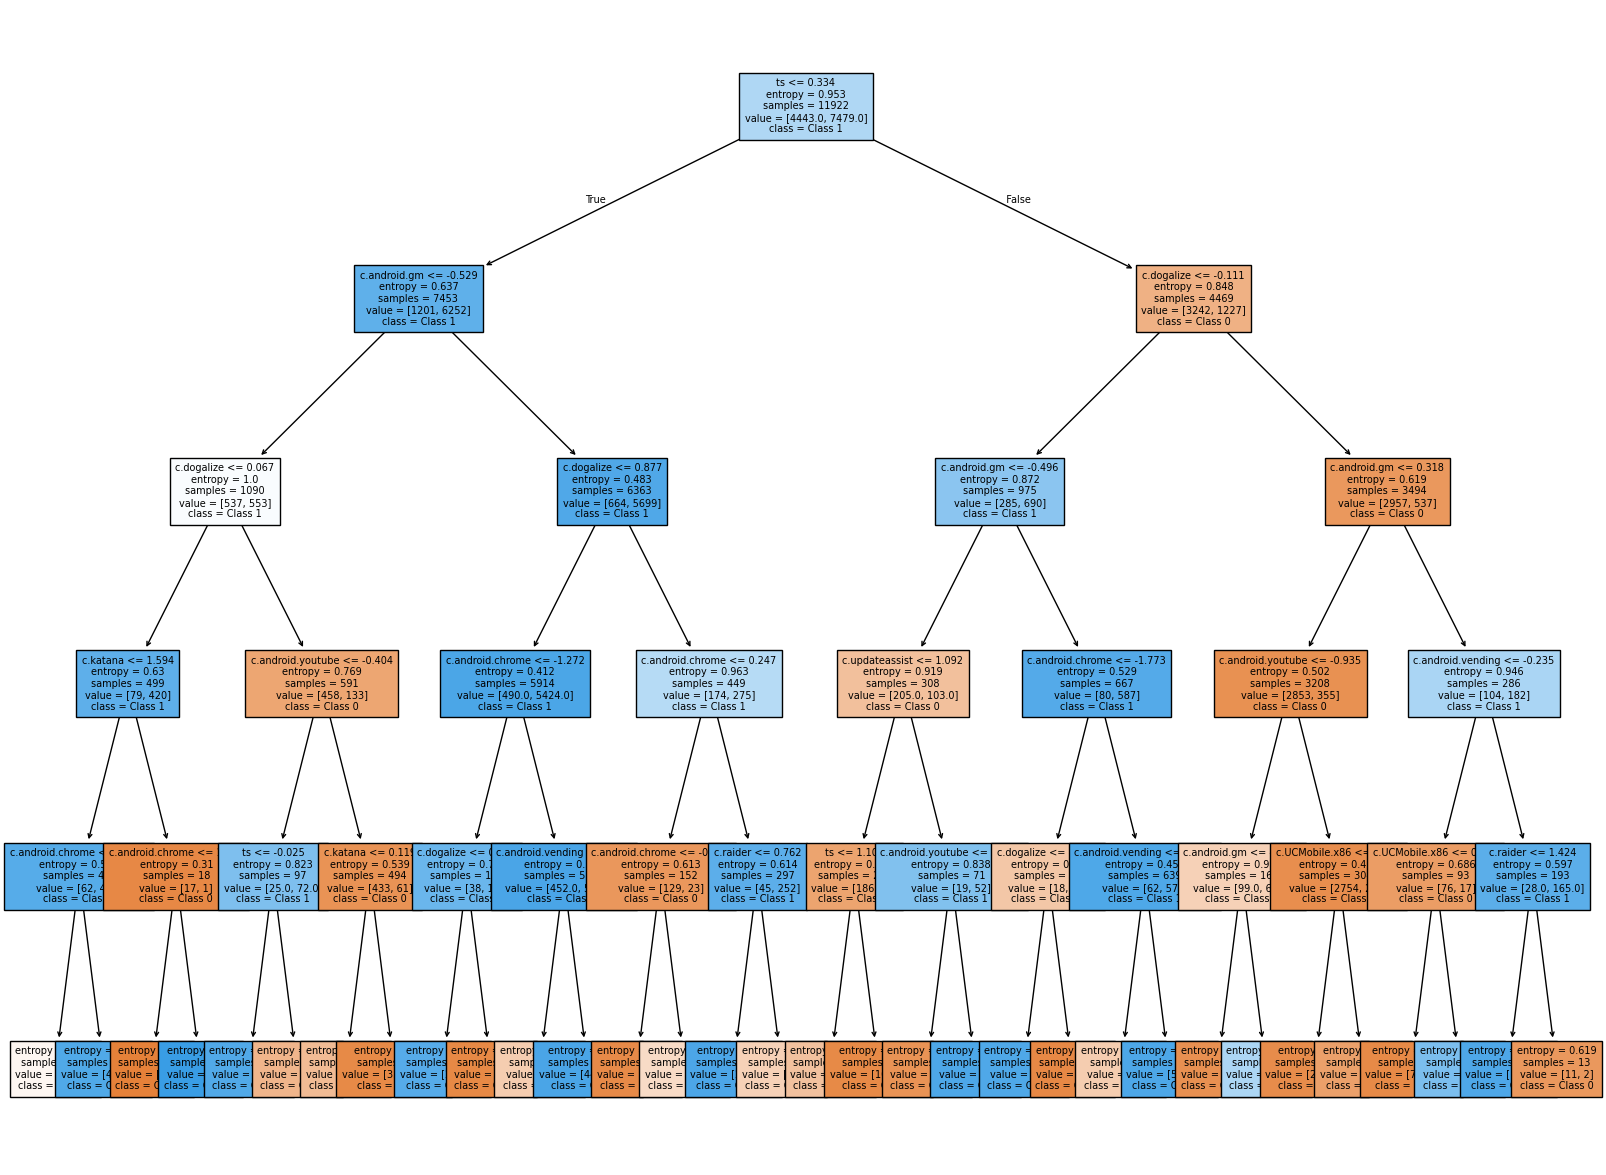

In [96]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 15))
plot_tree(
    dtc_model, 
    feature_names=train_df.drop(columns="mwra").columns, 
    class_names=['Class 0', 'Class 1'], 
    filled=True, 
    fontsize=7
)
plt.show()

Pre vizualizáciu sme si zvolili algoritmus **DecisionTreeClassifier**, pretože na tomto algoritme sa dá pekne vykresliť strom pravidiel. Keďže sme jeho hĺbku obmedzili na 5, tak aj z vizualizácie môžeme vidieť, že je strom v tejto hĺbke zrezaný.

## E
Vyhodnoťte natrénované modely pomocou metrík accuracy, precision a recall.

In [97]:
from sklearn.metrics import accuracy_score, classification_report

decision_tree_accuracy = accuracy_score(y_test, dtc_pred)
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
decision_tree_report = classification_report(y_test, dtc_pred, output_dict=True)
log_reg_report = classification_report(y_test, log_reg_pred, output_dict=True)

print("Vyhodnotenie modelov:")
print("\nDecisionTreeClassifier:")
print(f"  Presnosť (Accuracy): {decision_tree_accuracy:.3f}")
print(f"  Precision: {decision_tree_report['weighted avg']['precision']:.3f}")
print(f"  Recall: {decision_tree_report['weighted avg']['recall']:.3f}")

print("\nLogistická regresia:")
print(f"  Presnosť (Accuracy): {log_reg_accuracy:.3f}")
print(f"  Precision: {log_reg_report['weighted avg']['precision']:.3f}")
print(f"  Recall: {log_reg_report['weighted avg']['recall']:.3f}")

Vyhodnotenie modelov:

DecisionTreeClassifier:
  Presnosť (Accuracy): 0.896
  Precision: 0.896
  Recall: 0.896

Logistická regresia:
  Presnosť (Accuracy): 0.914
  Precision: 0.914
  Recall: 0.914


Z výpisu vyššie môžeme vidieť, že existuje rozdiel v accuracy medzi algoritmami **DecisionTreeClassifier** a **LogisticRegression**. Tento rozdiel nie je veľký, ale aj napriek tomu nám, ako lepší algoritmus vyššiel LogisticRegression.

# 3.3 Optimalizácia alias hyperparameter tuning

## A
Vyskúšajte rôzne nastavenie hyperparametrov (tuning) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).


Keďže s algoritmami v časti 3.2 nie sme úplne spokojní, skúsime ešte použiť algoritmus **RandomForest**.

In [98]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(max_depth=10, random_state=42)
random_forest_model.fit(X_train, y_train)

random_forest_pred = random_forest_model.predict(X_test)

In [99]:
rf_accuracy = accuracy_score(y_test, random_forest_pred)

print(f"Accuracy: {rf_accuracy}")

Accuracy: 0.9191546460919154


Vidíme, že pri tomto algoritme je accuracy pomerne vysoká.

Pre lepšiu predstavu si to ešte skúsime vizualizovať.

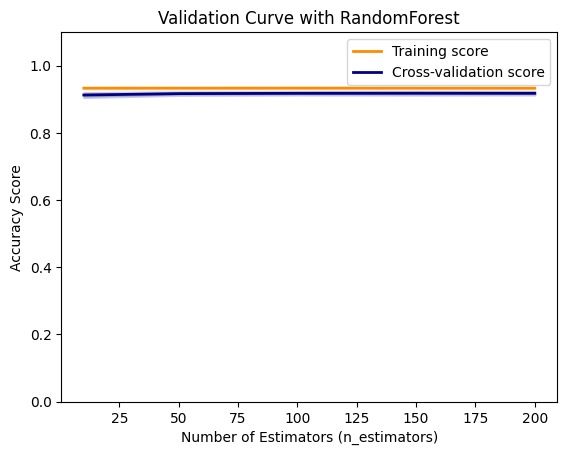

In [100]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def plot_valid_curve(param_range, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std):
    plt.title("Validation Curve with RandomForest")
    plt.xlabel("Number of Estimators (n_estimators)")
    plt.ylabel("Accuracy Score")
    plt.ylim(0.0, 1.1)
    lw = 2

    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)

    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)

    plt.legend(loc="best")
    plt.show()

param_range = [10, 50, 100, 150, 200]

train_scores, test_scores = validation_curve(RandomForestClassifier(max_depth=10, random_state=1),
                                             X=X_train,
                                             y=y_train,
                                             param_name='n_estimators',
                                             param_range=param_range,
                                             scoring="accuracy",
                                             cv=3)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plot_valid_curve(param_range, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std)

Môžeme vidieť, že naprieč všetkými hodnotami "n_estimators" nie je veľký rozdiel medzi accuracy, ktorá bola dosiahnutá na trénovacej množine a ktorá bola dosiahnutá krížovou validáciou. To znamená, že náš algoritmus nie je pretrénovaný.

Hyperparameter tuning sme sa rozhodli realizovať práve pre algoritmus **RandomForest**, pretože pri ňom nám vychádza najlepšia accuracy, už aj bez hyperparameter tuningu.

In [101]:
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters found:  {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
accuracy: 0.9201610197920161
precision: 0.9207161125319693
recall: 0.9559214020180563


Ako môžme vidieť, RandomForest s najlepšími nájdenými parametrami dosahuje presnosť 92,02%, čiže pomocou hyperparameter tuningu sa nám podarilo jeho výkon o trochu zlepšiť.

In [102]:
best_model = RandomForestClassifier(criterion="gini", max_depth=20, min_samples_split=5, n_estimators=300, random_state=42)
best_model.fit(X_train, y_train)

best_model_pred = best_model.predict(X_test)

In [103]:
best_model_accuracy = accuracy_score(y_test, best_model_pred)
best_model_report = classification_report(y_test, best_model_pred, output_dict=True)

print(f"Presnosť (Accuracy): {best_model_accuracy}")
print(f"Precision: {best_model_report['weighted avg']['precision']}")
print(f"Recall: {best_model_report['weighted avg']['recall']}")

Presnosť (Accuracy): 0.9201610197920161
Precision: 0.9201220659155281
Recall: 0.9201610197920161


Preistotu sme výkon ešte overili pomocou funkcie classification_report, ktorá na výpočet precision a recall používa váhované priemery, na rozdiel od funkcii precision_score a recall_score, ktoré defaultne používajú binárny priemer.

Ako môžme vidieť, precision a recall hodnoty sú o trochu nižšie ako pri predošlom spôsobe.

In [104]:
train_predictions = best_model.predict(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)
print("Trénovacia množina:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")

Trénovacia množina:
Accuracy: 0.9506794162053347
Precision: 0.9425818882466281
Recall: 0.9811472121941436


Na koniec sme ešte overili výkon takto upraveného RandomForest algoritmu na trénovacej množine pomocou funkcií accuracy_score, precision_score a recall_score. Ako môžme vidieť, rozdiel hodnôt týchto funkcií na trénovacej a testovacej množine nie je veľký, čiže algortimus nemá overfit.

## B
Vyskúšajte kombinácie modelov (ensemble) pre zvolený algoritmus tak, aby ste
optimalizovali výkonnosť (bez underfitingu).

In [119]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

rf = RandomForestClassifier(criterion="gini", max_depth=20, min_samples_split=5, n_estimators=300, random_state=42, n_jobs=-1)
lr = LogisticRegression(random_state=42)
knn = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)

ensemble_model = VotingClassifier(
    estimators=[('rf', rf), ('lr', lr), ('knn', knn)], 
    voting='hard'
)

ensemble_model.fit(X_train, y_train)

print("Accuracy (trénovacie dáta):", ensemble_model.score(X_train, y_train))
print("Accuracy (testovacie dáta):", ensemble_model.score(X_test, y_test))

Accuracy (trénovacie dáta): 0.9255997315886596
Accuracy (testovacie dáta): 0.9215028513921503


Po otestovaní viacerých kombinácií modelov (RandomForestClassifier, LogisticRegression, KNeighborsClassifier, GradientBoostingClassifier, SVC, DecisionTreeClassifier) sme vybrali na skombinovanie nasledujúce modely:
- **RandomForestClassifier** - náš najlepší model získaný z hyperparameter tuningu
- **LogisticRegression**
- **KNeighborsClassifier**

Prvé 2 modely sme vybrali aj z toho dôvodu, že sme s nimi pracovali v predchádzajúcich častiach. Pri KneighborsClassifier sme si všimli, že keď ho použijeme, dostávame lepšiu accuracy, a preto sme zahrnuli aj tento model.

Celkovo táto kombinácia modelov dosahuje na testovacej množine **accuracy = 92,15%**.

## C
Využite krížovú validáciu (cross validation) na trénovacej množine.

In [106]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5)

print("Krížová validácia skóre:", cv_scores)
print("Priemerné skóre krížovej validácie:", cv_scores.mean())

Krížová validácia skóre: [0.92327044 0.92159329 0.92533557 0.9102349  0.93204698]
Priemerné skóre krížovej validácie: 0.9224962362641229


Ako model, na ktorom sme skúšali krížovú validáciu, sme si zvolili náš ensemble model z predchádzajúcej úlohy. Kríženie sme nastavili na hodnotu 5.

Môžeme vidieť, že po použití krížovej validácie, sme dosiahli **priemernú accuracy = 92,25%**.

## D
Dokážte že Váš nastavený najlepší model je bez overfitingu.

Dokážeme, že náš najlepší model, ktorý sme dosiahli v časti 3.3B (teda ensemble model), nemá overfit:

In [107]:
train_accuracy = ensemble_model.score(X_train, y_train)
test_accuracy = ensemble_model.score(X_test, y_test)

print("Tréningová presnosť:", train_accuracy)
print("Testovacia presnosť:", test_accuracy)

Tréningová presnosť: 0.9252642174131857
Testovacia presnosť: 0.9215028513921503


Na základe presnosti tréningovej a testovacej sady vidíme, že rozdiel medzi nimi je len minimálny, a teda náš model **nie je** overfitnutý.

Pre lepšiu predstavu si to ešte vizualizujeme:

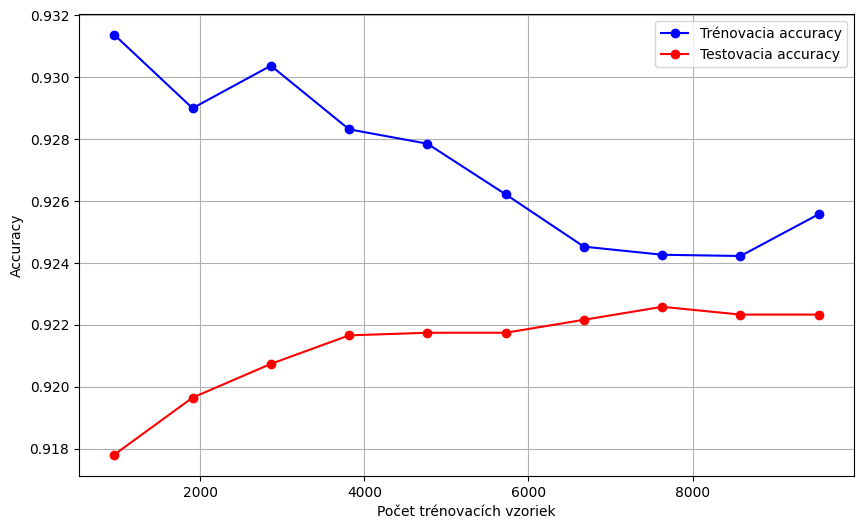

In [108]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

model = ensemble_model

train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Trénovacia accuracy")
plt.plot(train_sizes, val_mean, 'o-', color="red", label="Testovacia accuracy")

plt.xlabel("Počet trénovacích vzoriek")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


Taktiež aj z grafov môžeme vidieť, že:
- rozdiel medzi tréningovou a testovacou presnosťou nie je veľký, čo naznačuje, že model nie je prispôsobený konkrétnym tréningovým dátam
- testovacia presnosť (červená čiara) sa stabilizuje, keď sa zvyšuje počet tréningových vzoriek, čo znamená, že model nie je ani overfitnutý, ani underfitnutý
- tréningová presnosť klesá s narastajúcim počtom vzoriek, pretože model má s väčším množstvom dát viac variácie, ktorú sa musí naučiť, tento pokles však nie je výrazný, čo naznačuje, že model má dostatočnú kapacitu na zvládnutie dát

# 3.4 Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu
Vyhodnoťte Vami zvolené stratégie riešenia projektu z hľadiska classification accuracy, či sú
učinné pre Váš dataset:

## A
Stratégie riešenia chýbajúcich hodnôt a outlierov

Pre vyhodnotenie stratégií riešenia chýbajúcich hodnôt a outlierov si implementujeme ďalšie rôzne stratégie do nášho predspracovacieho pipelinu, vyskúšame všetky ich kombinácie a vypíšeme dosiahnuté výsledky.

In [109]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin

columns = ['mwra', 'c.katana', 'p.android.packageinstaller', 'c.android.chrome', 'p.system',
          'p.android.externalstorage', 'p.android.chrome', 'p.android.documentsui', 'c.android.youtube',
          'c.android.gm', 'p.android.defcontainer']

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns].copy()

class DateTimeExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['ts'] = pd.to_datetime(X['ts'], errors='raise')
        X['year'] = X['ts'].dt.year
        X['month'] = X['ts'].dt.month
        X['day'] = X['ts'].dt.day
        X['hour'] = X['ts'].dt.hour
        X['minute'] = X['ts'].dt.minute
        X['second'] = X['ts'].dt.second
        X = X.drop(columns=['ts'])
        return X

class DropSingleValueColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_drop = []
        self.columns_to_keep = []

    def fit(self, X, y=None):
        self.columns_to_drop = [col for col in X.columns if X[col].nunique() == 1]
        self.columns_to_keep = [col for col in X.columns if col not in self.columns_to_drop]
        return self

    def transform(self, X):
        X = X.copy()
        X = X.drop(columns=self.columns_to_drop)
        return X

class MeanImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.means = X.select_dtypes(include=[np.number]).mean()
        return self

    def transform(self, X):
        X = X.copy()
        for column in self.means.index:
            X[column] = X[column].fillna(self.means[column])
        return X

class NoOpTransformer(BaseEstimator, TransformerMixin):
    """A transformer that does nothing (acts as a placeholder)."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X


class MedianImputer(BaseEstimator, TransformerMixin):
    """Impute missing values with median."""
    def fit(self, X, y=None):
        self.medians = X.select_dtypes(include=[np.number]).median()
        return self

    def transform(self, X):
        X = X.copy()
        for column in self.medians.index:
            X[column] = X[column].fillna(self.medians[column])
        return X

class ReplaceOutliersWithBoundaries(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for column in X.select_dtypes(include=[np.number]).columns:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            X[column] = np.where(X[column] < lower_bound, lower_bound, X[column])
            X[column] = np.where(X[column] > upper_bound, upper_bound, X[column])
        return X

class RemoveOutliers(BaseEstimator, TransformerMixin):
    """Remove rows containing outliers based on IQR."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for column in X.select_dtypes(include=[np.number]).columns:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            X = X[(X[column] >= lower_bound) & (X[column] <= upper_bound)]
        return X

class ReplaceOutliersWithMean(BaseEstimator, TransformerMixin):
    """Replace outliers with the mean value of the column."""
    def fit(self, X, y=None):
        self.means = X.select_dtypes(include=[np.number]).mean()
        return self

    def transform(self, X):
        X = X.copy()
        for column in X.select_dtypes(include=[np.number]).columns:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            X[column] = np.where(X[column] < lower_bound, self.means[column], X[column])
            X[column] = np.where(X[column] > upper_bound, self.means[column], X[column])
        return X

class ReplaceOutliersWithMedian(BaseEstimator, TransformerMixin):
    """Replace outliers with the median value of the column."""
    def fit(self, X, y=None):
        self.medians = X.select_dtypes(include=[np.number]).median()
        return self

    def transform(self, X):
        X = X.copy()
        for column in X.select_dtypes(include=[np.number]).columns:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            X[column] = np.where(X[column] < lower_bound, self.medians[column], X[column])
            X[column] = np.where(X[column] > upper_bound, self.medians[column], X[column])
        return X

class ScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, exclude_column):
        self.exclude_column = exclude_column
        self.scaler = StandardScaler()
        self.transformer = PowerTransformer(method='yeo-johnson')

    def fit(self, X, y=None):
        self.feature_names = X.columns.drop(self.exclude_column)
        self.scaler.fit(X[self.feature_names])
        self.transformer.fit(self.scaler.transform(X[self.feature_names]))
        return self

    def transform(self, X):
        X = X.copy()
        scaled = self.scaler.transform(X[self.feature_names])
        transformed = self.transformer.transform(scaled)

        X_scaled = pd.DataFrame(transformed, columns=self.feature_names, index=X.index)
        X_scaled[self.exclude_column] = X[self.exclude_column].values
        return X_scaled

missing_value_strategies = [
    ("No Handling", NoOpTransformer()),
    ("Mean Imputation", MeanImputer()),
    ("Median Imputation", MedianImputer())
]

outlier_strategies = [
    ("No Handling", NoOpTransformer()),
    ("Replace Outliers with Boundaries", ReplaceOutliersWithBoundaries()),
    ("Replace Outliers with Mean", ReplaceOutliersWithMean()),
    ("Replace Outliers with Median", ReplaceOutliersWithMedian())
]

results = []

for missing_name, missing_transformer in missing_value_strategies:
    for outlier_name, outlier_transformer in outlier_strategies:
        preprocessing_pipeline = Pipeline([
            ('datetime_extractor', DateTimeExtractor()),
            ('drop_single_value_columns', DropSingleValueColumns()),
            ('column_selector', ColumnSelector(columns=columns)),
            ('missing_values', missing_transformer),
            ('outlier_replacer', outlier_transformer),
            ('scaler', ScalerTransformer(exclude_column="mwra"))
        ])
        
        train_df, test_df = train_test_split(pair_df, test_size=0.25, random_state=42)
        X_train_preprocessed = preprocessing_pipeline.fit_transform(train_df)
        X_test_preprocessed = preprocessing_pipeline.transform(test_df)
        X_train = X_train_preprocessed.drop(columns=['mwra'])
        y_train = X_train_preprocessed['mwra']
        X_test = X_test_preprocessed.drop(columns=['mwra'])
        y_test= X_test_preprocessed['mwra']

        classifier = ensemble_model
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        results.append({
            "Missing Value Strategy": missing_name,
            "Outlier Handling Strategy": outlier_name,
            "Accuracy": accuracy
        })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="Accuracy", ascending=False))

   Missing Value Strategy         Outlier Handling Strategy  Accuracy
1             No Handling  Replace Outliers with Boundaries  0.921363
5         Mean Imputation  Replace Outliers with Boundaries  0.921363
9       Median Imputation  Replace Outliers with Boundaries  0.921363
0             No Handling                       No Handling  0.920827
8       Median Imputation                       No Handling  0.920827
4         Mean Imputation                       No Handling  0.920827
10      Median Imputation        Replace Outliers with Mean  0.918948
2             No Handling        Replace Outliers with Mean  0.918948
6         Mean Imputation        Replace Outliers with Mean  0.918948
3             No Handling      Replace Outliers with Median  0.918680
7         Mean Imputation      Replace Outliers with Median  0.918680
11      Median Imputation      Replace Outliers with Median  0.918680


Z výsledkov vidíme, že od stratégie nahrádzania chýbajúcich hodnôt **nezáleží**, to je preto, že v našich dátach **chýbajúce hodnoty nie sú**. Hlavný vplyv majú stratégie nahrádzania **vychýlených hodnôt**. Najlepšie skóre sú pri nahrádzaní vychýlených hodnôt **hraničnými hodnotami**, tak ako sme to urobili v priebehu zadania. 

O trochu nižšie skóre je, keď vychýlené hodnoty necháme tak ako sú. Na konci sú nahrádzania priemerom a mediánom, nahrádzanie priemerom vyšlo o malinkú trochu lepšie z týchto dvoch, ale sú skoro identické. Táto podobnosť sa dá pripísať faktu, že v dátach sú priemery a mediány našich features veľmi blízke.

## B
Dátová transformácia (scaling, transformer, …)

Na vyhodnotenie vplyvu stratégií škálovania a transformerov urobíme podobný postup ako v bode A.

In [110]:
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score

class GeneralScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, exclude_column, scaler=None, transformer=None):
        self.exclude_column = exclude_column
        self.scaler = scaler
        self.transformer = transformer

    def fit(self, X, y=None):
        self.feature_names = X.columns.drop(self.exclude_column)
        if self.scaler is not None:
            self.scaler.fit(X[self.feature_names])
            X_scaled = self.scaler.transform(X[self.feature_names])
        else:
            X_scaled = X[self.feature_names].values
        if self.transformer is not None:
            self.transformer.fit(X_scaled)
        return self

    def transform(self, X):
        X = X.copy()
        X_features = X[self.feature_names]
        if self.scaler is not None:
            X_scaled = self.scaler.transform(X_features)
        else:
            X_scaled = X_features.values
        if self.transformer is not None:
            X_transformed = self.transformer.transform(X_scaled)
        else:
            X_transformed = X_scaled
        X_scaled_df = pd.DataFrame(X_transformed, columns=self.feature_names, index=X.index)
        X_scaled_df[self.exclude_column] = X[self.exclude_column].values
        return X_scaled_df

scalers = [
    ("No Scaling", None),
    ("StandardScaler", StandardScaler()),
    ("MinMaxScaler", MinMaxScaler()),
    ("MaxAbsScaler", MaxAbsScaler()),
    ("RobustScaler", RobustScaler()),
]

transformers = [
    ("No Transformation", None),
    ("PowerTransformer (Yeo-Johnson)", PowerTransformer(method='yeo-johnson')),
    ("QuantileTransformer (Uniform)", QuantileTransformer(output_distribution='uniform', random_state=0)),
    ("QuantileTransformer (Normal)", QuantileTransformer(output_distribution='normal', random_state=0)),
]

results = []

for scaler_name, scaler in scalers:
    for transformer_name, transformer in transformers:
        preprocessing_pipeline = Pipeline([
            ('datetime_extractor', DateTimeExtractor()),
            ('drop_single_value_columns', DropSingleValueColumns()),
            ('column_selector', ColumnSelector(columns=columns)),
            ('missing_values', NoOpTransformer()),  
            ('outlier_replacer', ReplaceOutliersWithBoundaries()),
            ('scaler_transformer', GeneralScalerTransformer(exclude_column="mwra", scaler=scaler, transformer=transformer))
        ])
        
        train_df, test_df = train_test_split(pair_df, test_size=0.25, random_state=42)
        
        X_train_preprocessed = preprocessing_pipeline.fit_transform(train_df)
        X_test_preprocessed = preprocessing_pipeline.transform(test_df)
        
        X_train = X_train_preprocessed.drop(columns=['mwra'])
        y_train = X_train_preprocessed['mwra']
        X_test = X_test_preprocessed.drop(columns=['mwra'])
        y_test = X_test_preprocessed['mwra']

        rf = RandomForestClassifier(criterion="gini", max_depth=20, min_samples_split=5, n_estimators=300, random_state=42, n_jobs=-1)
        lr = LogisticRegression(random_state=42, max_iter=1000) 
        knn = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)

        ensemble_model = VotingClassifier(
            estimators=[('rf', rf), ('lr', lr), ('knn', knn)],
            voting='hard',
            n_jobs=-1
        )
        classifier = ensemble_model
        classifier.fit(X_train, y_train)
        
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        results.append({
            "Scaler": scaler_name,
            "Transformer": transformer_name,
            "Accuracy": accuracy
        })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="Accuracy", ascending=False))

            Scaler                     Transformer  Accuracy
17    RobustScaler  PowerTransformer (Yeo-Johnson)  0.921632
5   StandardScaler  PowerTransformer (Yeo-Johnson)  0.921363
0       No Scaling               No Transformation  0.920827
1       No Scaling  PowerTransformer (Yeo-Johnson)  0.920827
15    MaxAbsScaler    QuantileTransformer (Normal)  0.920827
3       No Scaling    QuantileTransformer (Normal)  0.920827
11    MinMaxScaler    QuantileTransformer (Normal)  0.920827
7   StandardScaler    QuantileTransformer (Normal)  0.920827
12    MaxAbsScaler               No Transformation  0.920827
19    RobustScaler    QuantileTransformer (Normal)  0.920827
16    RobustScaler               No Transformation  0.920558
4   StandardScaler               No Transformation  0.920558
9     MinMaxScaler  PowerTransformer (Yeo-Johnson)  0.920558
13    MaxAbsScaler  PowerTransformer (Yeo-Johnson)  0.920558
8     MinMaxScaler               No Transformation  0.920290
2       No Scaling   Qua

Z výsledkov vidíme, že:
- najvyššiu presnosť sme dosiahli pri použití RobustScaler v kombinácii s PowerTransformer (Yeo-Johnson), kde presnosť dosiahla 92,16%.
- druhú najvyššiu presnosť sme dosiahli s StandardScaler a PowerTransformer (Yeo-Johnson), s presnosťou 92,14%.
- viaceré ďalšie konfigurácie s rôznymi škálovaniami a transformáciami dosiahli podobnú presnosť okolo 92,08%.
- viaceré ďalšie konfigurácie s rôznymi škálovaniami a transformáciami dosiahli podobnú presnosť okolo 92,06%.
- viaceré ďalšie konfigurácie s rôznymi škálovaniami a transformáciami dosiahli podobnú presnosť okolo 91,98%.

### Pozorovanie

Z toho vyplýva, že v predošlých bodoch zadania sme sa správne rozhodli použiť PowerTransformer s metódou Yeo-Johnson. Škálovanie sme si predtým vybrali štandardné, ale RobustScaler má o trochu (0,0279%) lepšie výsledky. 

Keďže RobustScaler vyšiel z testov lepšie, pokúsili sme sa pomocou neho nájsť nový najlepší model, no nepodarilo sa nám to. Robili sme to tak, že sme upravili predspracovací pipeline tak aby používal RobustScaler namiesto StandardScaleru, a na takto spracovaných dátach sme hľadali najlepší model. Najlepším individuálnym modelom bol opäť RandomForest, na ktorý sme použili hyperparameter tuning (rovnakým Grid Searchom ako je vyššie v časti 3.3) a nakoniec sme presnosť ešte zvýšili tým, že sme ho dali do ensamble s Logistickou Regresiou a KNN klasifikátorom, ale najlepšia dosiahnutá presnosť bola 92.13%, čiže to bolo mierne nižšie ako náš doposiaľ najlepší model. 

### Záver

Aj keď RobustScaler v tomto teste má lepšie výsledky, nevedeli sme s jeho použitím dosiahnuť lepší model ako je pôvodný ensamble, ktorý na predspracovanie používa StandardScaler. Tento neúspech môže byť spôsobený tým, že rozdiel vo výsledkoch tohoto testu v týchto dvoch stratégiach škálovania je maličký a zároveň výhoda RobustScalera, ktorá spočíva v tom, že lepšie zvláda vychýlené hodnoty je minimalizovaná, pretože vychýlené hodnoty spracovávame aj pomocou náhrádzania hraničnými hodnotami.

## C
Výber atribútov, výber algoritmov, hyperparameter tuning, ensemble learning.

Najprv sa pozrieme na výber atribútov. Dôležitosť výberu atribútov overíme tak, že nášmu najlepšiemu modelu dáme naučiť dáta, pre ktoré v predspracovacom pipeline vynecháme krok Column Selector, čiže v dátach ponecháme všetky stĺpce.

### Výber atribútov

In [118]:
train_df, test_df = train_test_split(pair_df, test_size=0.2, random_state=42)
all_columns_pipeline = Pipeline([
    ('datetime_extractor', DateTimeExtractor()),
    ('drop_single_value_columns', DropSingleValueColumns()),
    ('missing_values', NoOpTransformer()),  
    ('outlier_replacer', ReplaceOutliersWithBoundaries()),
    ('scaler_transformer', GeneralScalerTransformer(exclude_column="mwra", scaler=RobustScaler(), transformer=PowerTransformer(method='yeo-johnson')))
])

X_train_preprocessed = all_columns_pipeline.fit_transform(train_df)
X_test_preprocessed = all_columns_pipeline.transform(test_df)

X_train = X_train_preprocessed.drop(columns=['mwra'])
y_train = X_train_preprocessed['mwra']
X_test = X_test_preprocessed.drop(columns=['mwra'])
y_test = X_test_preprocessed['mwra']

classifier = ensemble_model
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9204964776920497


Ako môžme vidieť, keď použijeme všetky stĺpce, našu presnosť to **negatívne ovplyvní**. Rozdiel v presnosti sa môže zdať malý (iba 0.1%), ale zahrnutie všetkých stĺpcov má okrem presnosti impakt aj na čas potrebný na trénovanie. Zároveň jednoduchšie modely sú menej náchylné na pretrénovanie.

### Výber algoritmov

Ďalej sa pozrieme na dôležitosť výberu algoritmov. Na našom predspracovacom pipeline vyskúšame rôzne ďalšie algoritmy.

In [120]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

classifiers = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)),
    ("K-Nearest Neighbors", KNeighborsClassifier(n_jobs=-1)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("Naive Bayes", GaussianNB())
]

comparison_pipeline = Pipeline([
        ('datetime_extractor', DateTimeExtractor()),
        ('drop_single_value_columns', DropSingleValueColumns()),
        ('column_selector', ColumnSelector(columns=columns)),
        ('missing_values', NoOpTransformer()),
        ('outlier_replacer', ReplaceOutliersWithBoundaries()),
        ('scaler_transformer', GeneralScalerTransformer(exclude_column="mwra", scaler=RobustScaler(), transformer=PowerTransformer(method='yeo-johnson')))
])

train_df, test_df = train_test_split(pair_df, test_size=0.2, random_state=42)
X_train_preprocessed = comparison_pipeline.fit_transform(train_df)
X_test_preprocessed = comparison_pipeline.transform(test_df)

X_train = X_train_preprocessed.drop(columns=['mwra'])
y_train = X_train_preprocessed['mwra']
X_test = X_test_preprocessed.drop(columns=['mwra'])
y_test = X_test_preprocessed['mwra']


results = []

for clf_name, clf in classifiers:
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
        
    results.append({
        'Algorithm': clf_name,
        'Accuracy': accuracy
    })

alg_results_df = pd.DataFrame(results)
print(alg_results_df.sort_values(by='Accuracy', ascending=False))

             Algorithm  Accuracy
1        Random Forest  0.919155
3  K-Nearest Neighbors  0.918148
4    Gradient Boosting  0.915800
2  Logistic Regression  0.913452
5          Naive Bayes  0.901375
0        Decision Tree  0.833948


Ako môžme vidieť, všetky algoritmy majú nižšiu presnosť ako náš najlepší nájdený ensamble model. Zároveň každý algoritmus má inú presnosť, čiže výber algoritmu **má** vplyv na presnosť predikcie.

### Hyperparameter tuning
Pre dokázanie účinnosti hyperparameter tuningu urobíme rovnaký GridSearch ako v časti 3.3.A, ale tentokrát vypíšeme  presnosti aj ostatných modelov, nie len toho najlepšieho. Skúšali sme to urobiť s GridSearchom z časti 3.3.A aby sme predišli vykonávaniu toho istého kódu dvakrát, ale z nám neznámeho dôvodu sa nám pri tom nedarilo pristúpiť k premennej cv_results_, ktorú pre túto úlohu potrebujeme...

In [123]:
model = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'random_state': [42],
    'n_jobs': [-1]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300], 'n_jobs': [-1],
                         'random_state': [42]},
             scoring='accuracy', verbose=1)

In [126]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df[[
    'params',
    'mean_test_score'
]]

results_df = results_df.sort_values(by='mean_test_score', ascending=False)
print("Accuracy from the best configuration:", results_df.iloc[0]['mean_test_score'])
print("Accuracy from the worst configuration:", results_df.iloc[-1]['mean_test_score'])

Accuracy from the best configuration: 0.9198958113488948
Accuracy from the worst configuration: 0.9088239204761301


Z výpisu vidíme, že správna kombinácia parametrov **má vplyv** na presnosť modelu, najlepšia konfigurácia prametrov má o 1.1% lepšiu presnosť ako tá najhoršia. 

### Ensamble
Na dokázanie účinnosti ensamble learningu porovnáme presnosť nášho ensamble modelu a presnosť najlepšieho individuálneho modelu.

In [127]:
clf1 = RandomForestClassifier(criterion="gini", max_depth=20, min_samples_split=5, n_estimators=300, random_state=42, n_jobs=-1)
clf1.fit(X_train, y_train)

rf = RandomForestClassifier(criterion="gini", max_depth=20, min_samples_split=5, n_estimators=300, random_state=42, n_jobs=-1)
lr = LogisticRegression(random_state=42)
knn = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)

ensemble_model = VotingClassifier(
    estimators=[('rf', rf), ('lr', lr), ('knn', knn)], 
    voting='hard'
)

clf2 = ensemble_model
clf2.fit(X_train, y_train)

clf1_y_pred = clf1.predict(X_test)
clf2_y_pred = clf2.predict(X_test)

accuracy1 = accuracy_score(y_test, clf1_y_pred)
accuracy2 = accuracy_score(y_test, clf2_y_pred)

print("Presnosť najlepšieho individuálneho modelu: ", accuracy1)
print("Presnosť ensemble modelu: ", accuracy2)

Presnosť najlepšieho individuálneho modelu:  0.9201610197920161
Presnosť ensemble modelu:  0.9215028513921503


Ako môžme vidieť, náš ensamble model dosahuje lepšie výsledky ako najlepší nájdený RandomForestClassifier osamote. To znamená, že ensamble učenie **je účinné** pre naše dáta.

## D
Ktorý model je Váš najlepší model pre nasadenie (deployment)?

Náš najlepší model je kombinácia (ensamble) RandomForest klasifikátoru, Logistickej Regresie a KNN klasifikátoru.

In [116]:
rf = RandomForestClassifier(criterion="gini", max_depth=20, min_samples_split=5, n_estimators=300, random_state=42, n_jobs=-1)
lr = LogisticRegression(random_state=42)
knn = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)

ensemble_model = VotingClassifier(
    estimators=[('rf', rf), ('lr', lr), ('knn', knn)], 
    voting='hard'
)

## E
Aký je data pipeline pre jeho vybudovanie na základe Vášho datasetu v produkcii?

Pipeline pre neho obsahuje kroky pre vyčistenie dát, výber najdôležiťejších features, nahradenie vychýlených hodnôt hraničnými hodnotami, Robust Scaler a PowerTransformer s metódou Yeo-Johnson.

In [117]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin

columns = ['mwra', 'c.katana', 'p.android.packageinstaller', 'c.android.chrome', 'p.system',
          'p.android.externalstorage', 'p.android.chrome', 'p.android.documentsui', 'c.android.youtube',
          'c.android.gm', 'p.android.defcontainer']

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns].copy()

class DateTimeExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['ts'] = pd.to_datetime(X['ts'], errors='raise')
        X['year'] = X['ts'].dt.year
        X['month'] = X['ts'].dt.month
        X['day'] = X['ts'].dt.day
        X['hour'] = X['ts'].dt.hour
        X['minute'] = X['ts'].dt.minute
        X['second'] = X['ts'].dt.second
        X = X.drop(columns=['ts'])
        return X

class DropSingleValueColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_drop = []
        self.columns_to_keep = []

    def fit(self, X, y=None):
        self.columns_to_drop = [col for col in X.columns if X[col].nunique() == 1]
        self.columns_to_keep = [col for col in X.columns if col not in self.columns_to_drop]
        return self

    def transform(self, X):
        X = X.copy()
        X = X.drop(columns=self.columns_to_drop)
        return X

class ReplaceOutliersWithBoundaries(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for column in X.select_dtypes(include=[np.number]).columns:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            X[column] = np.where(X[column] < lower_bound, lower_bound, X[column])
            X[column] = np.where(X[column] > upper_bound, upper_bound, X[column])
        return X

class ScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, exclude_column):
        self.exclude_column = exclude_column
        self.scaler = RobustScaler()
        self.transformer = PowerTransformer(method='yeo-johnson')

    def fit(self, X, y=None):
        self.feature_names = X.columns.drop(self.exclude_column)
        self.scaler.fit(X[self.feature_names])
        self.transformer.fit(self.scaler.transform(X[self.feature_names]))
        return self

    def transform(self, X):
        X = X.copy()
        scaled = self.scaler.transform(X[self.feature_names])
        transformed = self.transformer.transform(scaled)

        X_scaled = pd.DataFrame(transformed, columns=self.feature_names, index=X.index)
        X_scaled[self.exclude_column] = X[self.exclude_column].values
        return X_scaled


pipeline = Pipeline([
        ('datetime_extractor', DateTimeExtractor()),
        ('drop_single_value_columns', DropSingleValueColumns()),
        ('column_selector', ColumnSelector(columns=columns)),
        ('missing_values', NoOpTransformer()),
        ('outlier_replacer', ReplaceOutliersWithBoundaries()),
        ('scaler_transformer', GeneralScalerTransformer(exclude_column="mwra", scaler=RobustScaler(), transformer=PowerTransformer(method='yeo-johnson')))
])

# Záver

V tejto časti projektu sme sa venovali jendotlivým modelom strojového učenia a hľadali sme ten s najlepšou presnosťou pre naše dáta. Sekcie 3.1 až 3.3 sa dajú zhrnúť následovne:
- Najprv sme implementovali vlastný ID3 klasifikátor, s ním sme dosiahli najvyššiu presnosť 88,56%.
- Ďalej sme vyskúšali DecisionTree Classifier, s ním sme dosiahli najvyššiu presnosť 89,60%.
- Potom sme vyskúšali Logistickú Regresiu, s ňou sme dosiahli najvyššiu presnosť 91,38%.
- Následne sme vyskúšali RandomForest klasifikátor, s ním sme dosiahli najvyššiu presnosť 91,92%.
- Na RandomForest sme ešte použili hyperparameter tuning, ktorým sme presnosť zvýšili na 92,02%.
- Nakoniec sme ešte vyskúšali ensamble RandomForestu, Logistickej Regresie a KNN, kde sme dosiahli presnosť 92.15%.

V sekcii 3.4 sme sa venovali kvantifikovaniu vplyvu stratégii, ktoré sme si počas priebehu projektu vybrali, na presnosť modelu. Hlavné poznatky z tejto časti sú:
- Stratégia riešenia chýbajúcich hodnôt **nemá vplyv** na výkon, lebo v našich dátach chýbajúce hodnoty nie sú.
- Stratégia riešenia vychýlených hodnôt **má vplyv**, s tým že najlepšou stratégiou je nahrádzať ich hraničnými hodnotami, tak ako sme si to v 2 fáze zvolili.
- Výber transformera **má vplyv** na presnosť, najvhodnejší transformer pre naše dáte je Power Transformer s metódou Yeo-johnson, tak ako sme si to zvolili v 2. fáze.
- Výber techniky škálovania **má vplyv** na presnosť, my sme si v 2. fáze vybrali StandardScaler, ale v teste lepšiu presnosť dosiahol RobustScaler. Aj napriek tomu náš najlepší nájdený model používa StandardScaler, zdôvodnenie je v závere danej časti.
- Výber algoritmu na učenie **má vplyv** na presnosť, najlepší samostatný model je RandomForest.
- Hyperparamer tuning **má vplyv** na presnosť, najlepšia konfigurácia Random Forestu dosahuje v priemere o 1.1% vyššiu presnosť ako tá najhoršia.
- Použitie ensamble **má vplyv** na presnosť, náš najlepší ensamble model má vyššiu presnosť ako najlepší samostatný model.